# Inpainting Project

importing libraries we are going to need :

In [80]:
import imageio as iio
import numpy as np
import skimage.morphology as morpho  
from skimage import img_as_float
import matplotlib.pyplot as plt

### Image Reading

In [81]:
im=iio.imread('BW.png')
sizex , sizey = im.shape[:2]
print(sizex , sizey)

256 256


/tmp/ipykernel_11710/394247033.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im=iio.imread('BW.png')


### Image Display

In [82]:
def view(data, size=(10, 10), dpi=100):
    """
    Image Dispaly
    """
    fig = plt.figure()
    fig.set_size_inches(size)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(data)
    plt.show()

### Rectangular mask creating function

In [83]:
def mask(im, x1, x2 , y1 , y2):
    """
    Takes into argument image , and four coodinates and
    produces mask that has image size 
    """
    shape = im.shape
    mask = np.ones((shape[0],shape[1]), dtype=int)
    for i in range(x1,x2):
        for j in range(y1,y2):
            mask[i,j]=0
    return mask

def read_mask(filename):
    return iio.imread(filename,as_grey=True)

In [84]:
def delete_zone(im,mask):
    """
    Takes as argument image and mask and produces image with
    nullified zone 
    """
    n,m,k=im.shape
    new_im = np.zeros((n,m,k),dtype=int)
    for i in range(3):
        new_im[:,:,i]=im[:,:,i]*mask
    return new_im

## Patch manipulations :

In [85]:
def get_patch(image,p,patch_size=8):
    """
    Returns a patch centered on p
    """
    r = patch_size//2
    clip = np.array(image[p[0]-r:p[0]+r+1,p[1]-r:p[1]+r+1])
    return clip 


def similarity(patch1 , patch2 , maskpatch):
    d=0
    for i in range(3): 
        d+= np.sum(maskpatch*(patch1[:,:,i]-patch2[:,:,i])**2)
    return d

# Let's calculate the priority term

## Confidence term

In [86]:
def c_matrix(mask):
    n,m= mask.shape
    c=np.zeros(mask.shape)
    for k in range(n):
        for l in range(m):
            patch = get_patch(mask,(k,l))
            c[k,l]=np.sum(patch)/(patch.shape[0]*patch.shape[1])
    return c

#view(c_matrix(mask(im, 10, 100 , 20, 200)))

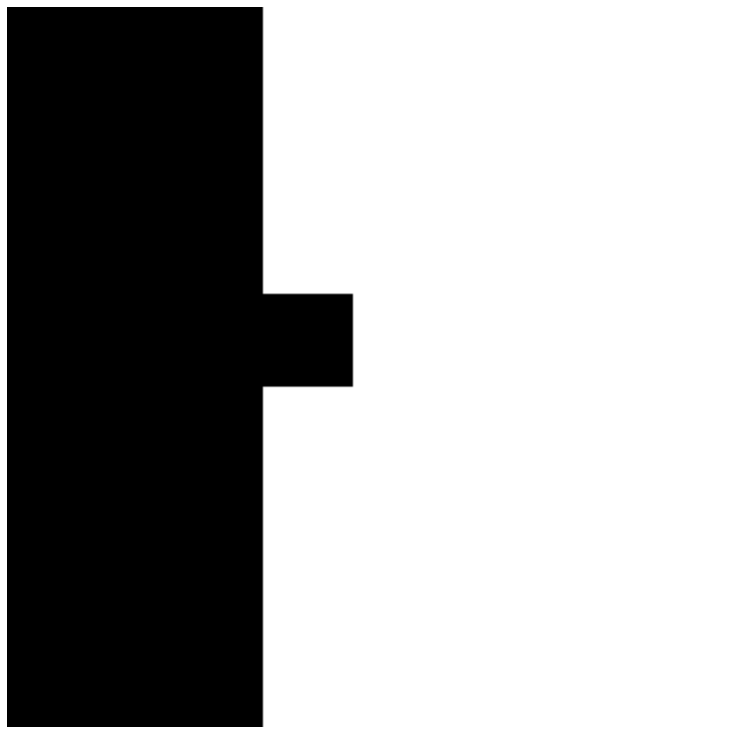

In [87]:
mask_1=mask(im, 102, 135 , 30+35, 88+35)
view(delete_zone(im,mask_1))

In [88]:
#Bords du mask rectangulaire
# We need to find out how to do it in general case 
## Border using morphology
def init_bord_m(mask):
    n,m=mask.shape
    strell=morpho.disk(1)
    bords= mask-morpho.erosion(mask,strell)
    L=[]
    for i in range(n):
        for j in range(m):
            if(bords[i,j]==1):
                L.append((i,j))
    return L

def bord_matrix(mask,bord):
    """
    frontiere in a matrix ( for display purpuses only)
    """
    n,m=mask.shape
    bord_matrix=np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            if((i,j) in bord):
                bord_matrix[i,j]=1
    return bord_matrix

In [89]:
bord = init_bord_m(mask_1)
#view(bord_matrix(mask,old))
#update_bord(old , mask , (20,20))
#view(bord_matrix(mask,old))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


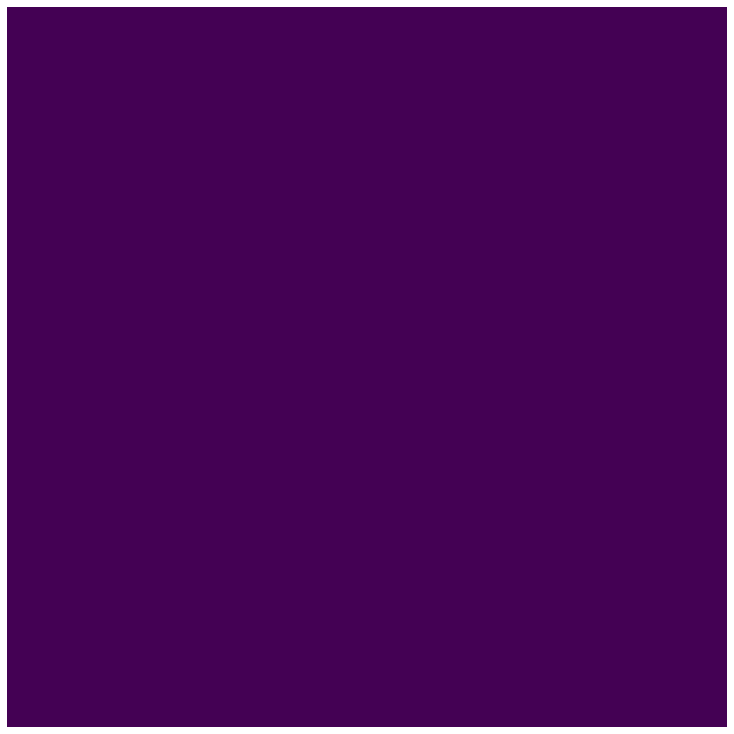

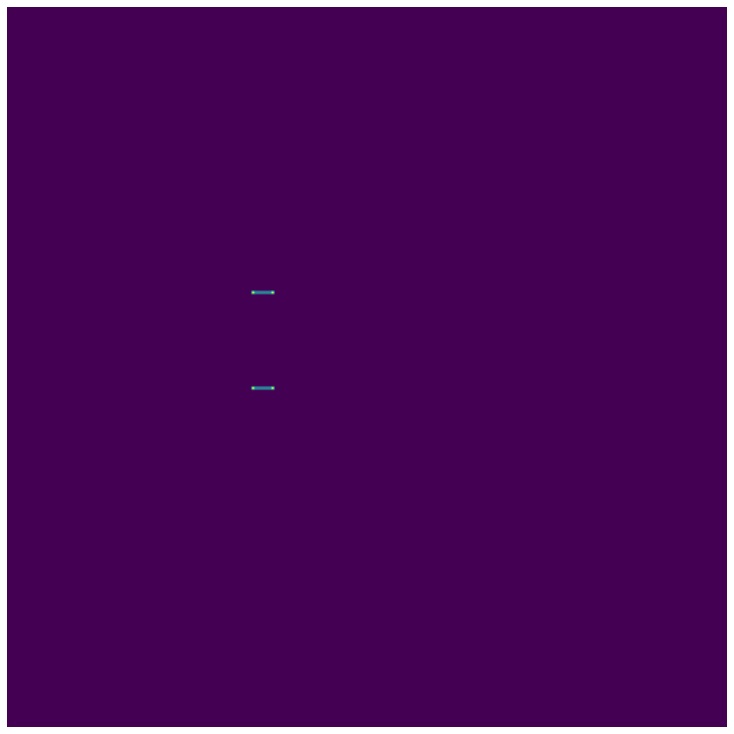

In [90]:
def gradient_I(image ,mask, bordure):
        """
        We compute I(p) for all p in delta(\Omega)
        """
        h, w = image.shape[:2]
        c=image.copy()
        c_r= img_as_float(c[:,:,0])
        c_g= img_as_float(c[:,:,1])
        c_b= img_as_float(c[:,:,2])
        # We fill the outside of the mask with nones
        c_r[mask == 0] = np.NaN
        c_g[mask == 0] = np.NaN
        c_b[mask == 0] = np.NaN
        # We compute the gradient 
        fgradx,fgrady = np.array([np.zeros([h, w]),np.zeros([h, w])])
        for point in bordure:
            patch_r=get_patch(c_r,point)
            patch_g=get_patch(c_g,point)
            patch_b=get_patch(c_b,point)
            
            gradientR = np.nan_to_num(np.gradient(patch_r))
            gradientG = np.nan_to_num(np.gradient(patch_g))
            gradientB = np.nan_to_num(np.gradient(patch_b))
            
            normeR= np.sqrt(gradientR[0]**2 + gradientR[1]**2)
            normeG= np.sqrt(gradientG[0]**2 + gradientG[1]**2)
            normeB= np.sqrt(gradientB[0]**2 + gradientB[1]**2)
            
            norme = np.maximum(normeR,normeG,normeB)
     
            max_patch = np.unravel_index(
                norme.argmax(),
                norme.shape
            )
            fgradx[point[0], point[1]] = gradientR[0][max_patch]
            fgrady[point[0], point[1]] = gradientR[1][max_patch]

        return [fgradx,fgrady]
    
    
I=gradient_I(im , mask_1 ,bord)    
print(I[1])
view(I[0])
view(I[1])

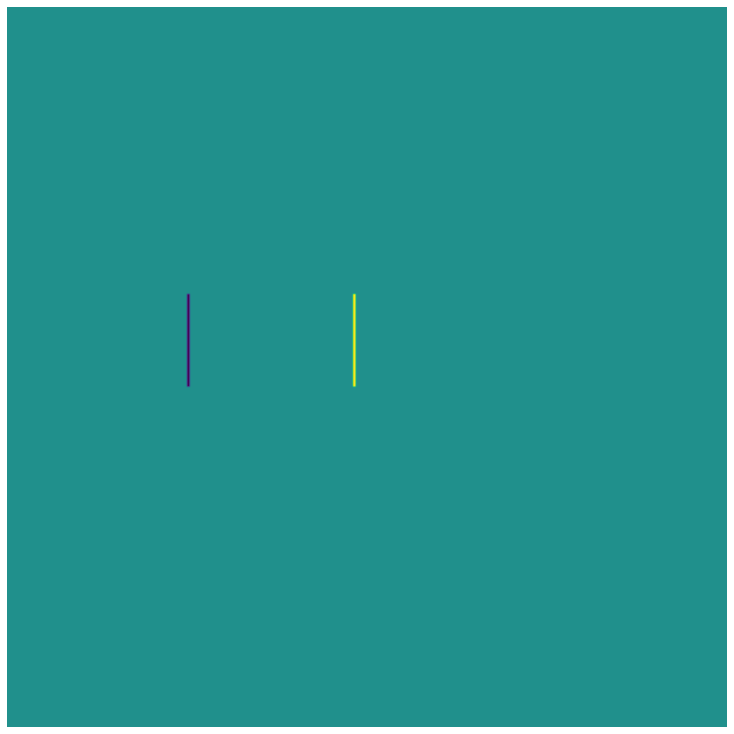

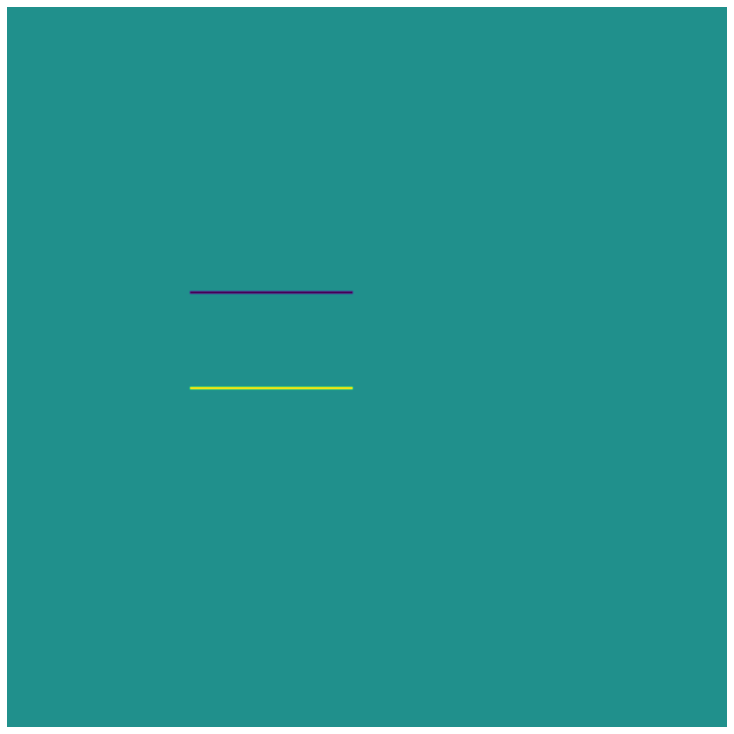

In [91]:
def normal_vect(image,mask,bord) : #n(p)
    h, w = mask.shape[:2]
    coordx , coordy= np.zeros((h, w)),np.zeros((h, w))
    for p in bord:
        i,j=p
        patch = get_patch(mask,(i,j))
        grad = len(patch)*len(patch[0])*np.nan_to_num(np.array(np.gradient(patch)))
        gradX = grad[0]
        gradY = grad[1]
        centerX, centerY = patch.shape[0]//2 ,patch.shape[1]//2
        coordx[i][j] =gradX[centerX][centerY]
        coordy[i][j] =gradY[centerX][centerY]
    return coordy,coordx
n=normal_vect(im,mask_1,init_bord_m(mask_1))
view(n[0])
view(n[1])

In [92]:
def P(image,mask,bordure):
    
    "Computes P for points of the bordure"
    
    h, w = mask.shape[:2]
    P=np.zeros((h,w))
    C=c_matrix(mask)
    I=gradient_I(image ,mask, bordure)
    N=normal_vect(image,mask,bordure)
    for (i,j) in bordure:
        P[i][j]=np.abs(I[0][i][j]*N[0][i][j]+
            I[1][i][j]*N[1][i][j])/255 * C[i][j]
    return P

def maxP(image,mask,bordure):
    
    "Finds point with max value of P"
    
    p=P(image,mask,bordure)
    maximum=p[bordure[0]]
    argmax=bordure[0]
    for point in bordure:
        i,j=point
        if(p[i][j]>=maximum):
            maximum = p[i][j]
            argmax=point
    return argmax  

/tmp/ipykernel_11710/2695204252.py:7: RuntimeWarning: invalid value encountered in long_scalars
  c[k,l]=np.sum(patch)/(patch.shape[0]*patch.shape[1])


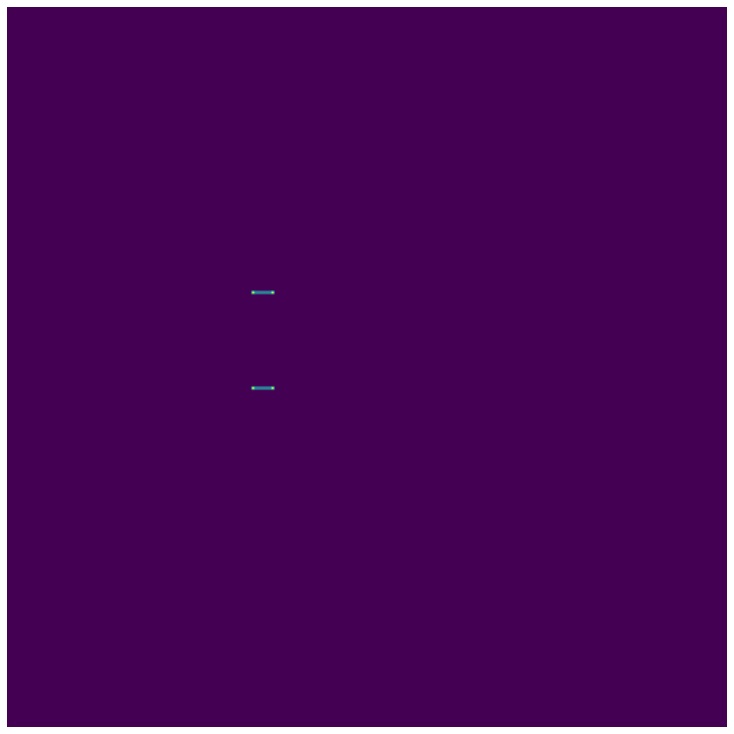

(135, 94)


In [93]:
view(P(im,mask_1,init_bord_m(mask_1)))
print(maxP(im,mask_1,init_bord_m(mask_1)))

# Iteration Of the algorithm

In [94]:
def iterate(image , firstmask , patch_size = 8 ,make_gif=True):
    mask=np.copy(firstmask)
    frt = init_bord_m(mask)
    new_image= delete_zone(image,mask)
    view(new_image)
    K=0
    ps=patch_size//2
    
    while (len(frt)>0):
        p_point= maxP(new_image,mask,frt)
        p_patch=get_patch(new_image,p_point)
        new_patch = get_patch(new_image, (ps,ps))
        d = similarity(new_patch,p_patch,get_patch(mask,(ps,ps)))
        print(d)
        chosenX,chosenY = p_point
        print("point chosen is: {0},{1}".format(chosenX,chosenY))
        maskpatch = get_patch(mask,(chosenX,chosenY))
        # Looking for a patch that is the closest to the content of uncomplete patch
        for x in range(ps, new_image.shape[0]-ps):
            for y in range(ps,new_image.shape[1]-ps):
                potential = True
                firstpatch=get_patch(firstmask,(x,y))
                for i in range(patch_size):
                    for j in range(patch_size):
                        if(firstpatch[i,j]==0):
                            potential=False
                if (potential):
                    testPatch = get_patch(new_image,(x,y))
                    dtest = similarity(p_patch,testPatch,maskpatch)
                    if dtest < d :
                        d = dtest
                        print(dtest)
                        print('coordinates are {0} {1}'.format(x,y))
                        new_patch = np.copy(testPatch)
        view(new_patch)
        # Filling
        for i in range(-ps,ps+1) :
            for j in range(-ps,ps+1):
                if(mask[chosenX+i,chosenY+j]==0):
                    new_image[chosenX+i,chosenY+j]= new_patch[ps+i,ps+j]
                    mask[chosenX+i,chosenY+j]= 1
        frt=init_bord_m(mask)
        view(new_image)
        iio.imwrite("output/"+str(K)+".jpg", new_image)
        print(len(frt))
        K+=1

/tmp/ipykernel_11710/2360692970.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im=iio.imread('RGB.png')


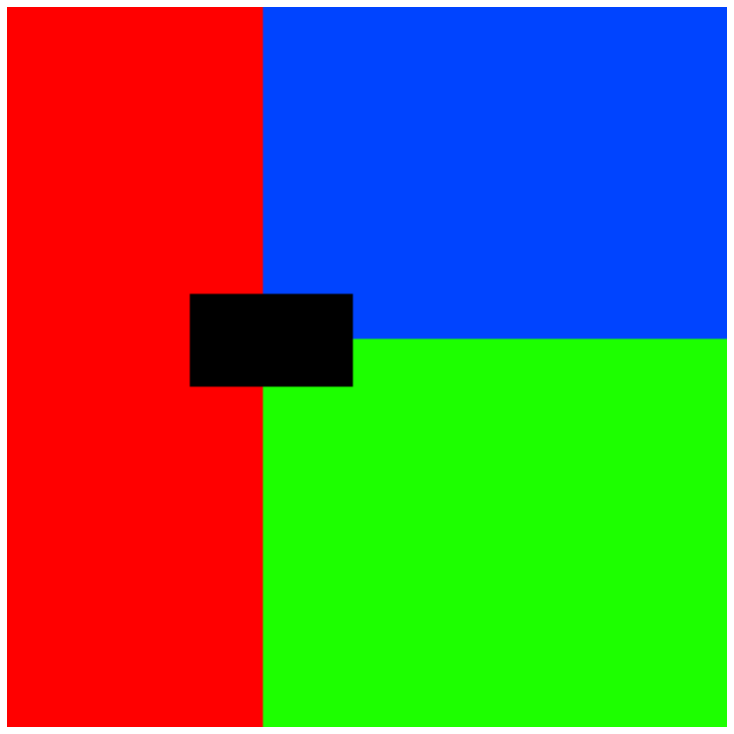

/tmp/ipykernel_11710/2695204252.py:7: RuntimeWarning: invalid value encountered in long_scalars
  c[k,l]=np.sum(patch)/(patch.shape[0]*patch.shape[1])


7727860
point chosen is: 101,94
5386960
coordinates are 4 4
4713590
coordinates are 4 87
4040220
coordinates are 4 88
3366850
coordinates are 4 89
2693480
coordinates are 4 90
2020110
coordinates are 4 91
1346740
coordinates are 4 92
673370
coordinates are 4 93
0
coordinates are 4 94


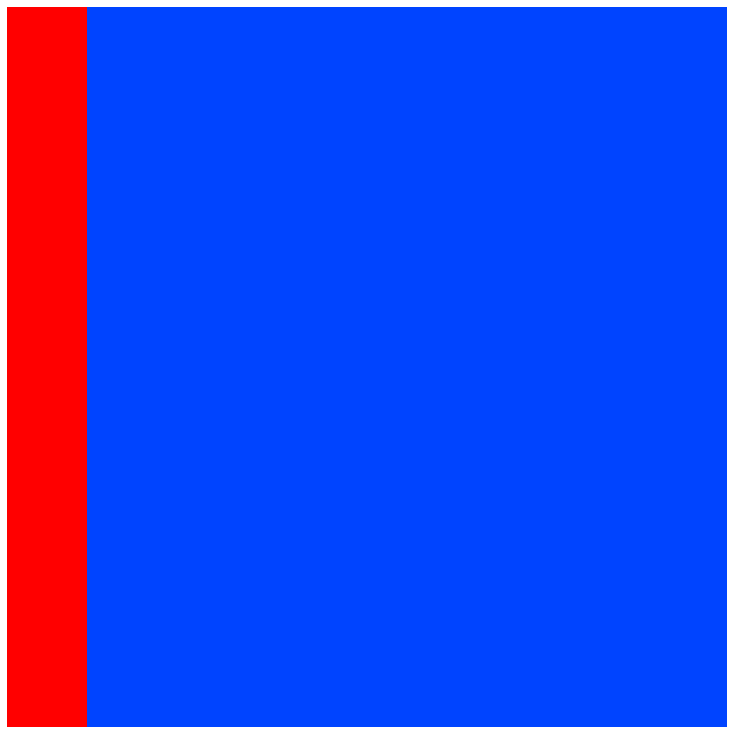

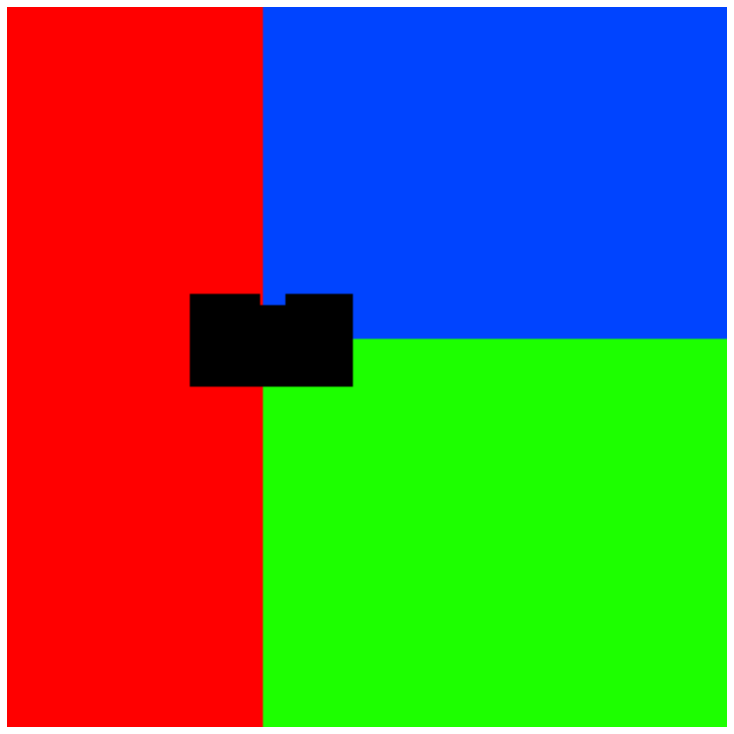

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


188
3032766
point chosen is: 101,87
1212066
coordinates are 4 4
0
coordinates are 4 87


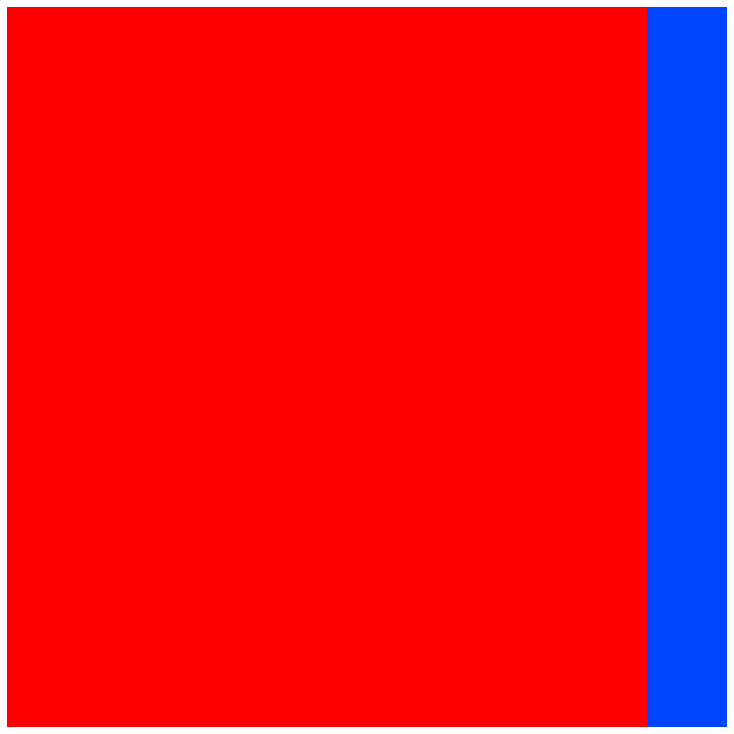

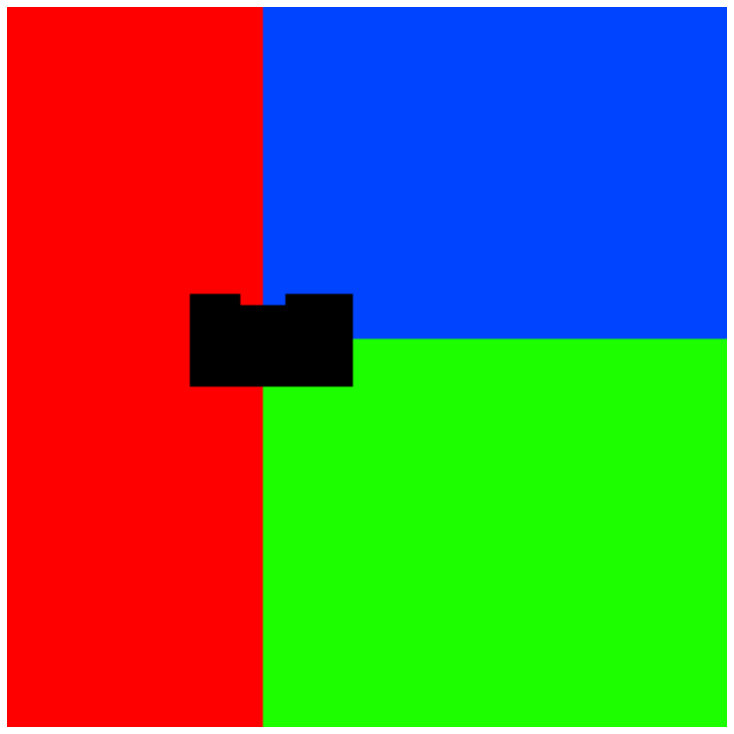

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


188
7727860
point chosen is: 105,94
5386960
coordinates are 4 4
4713590
coordinates are 4 87
4040220
coordinates are 4 88
3366850
coordinates are 4 89
2693480
coordinates are 4 90
2020110
coordinates are 4 91
1346740
coordinates are 4 92
673370
coordinates are 4 93
0
coordinates are 4 94


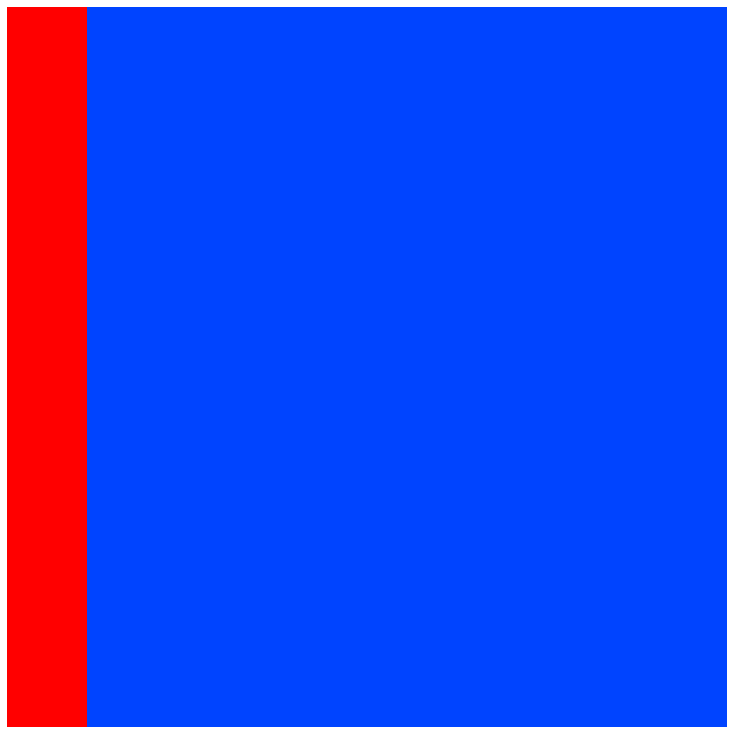

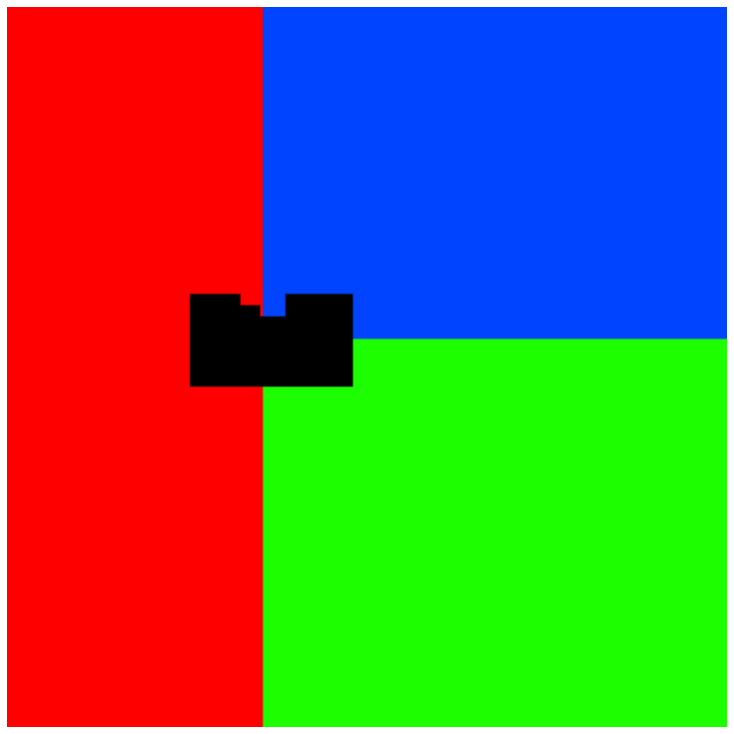

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


195
3032766
point chosen is: 105,87
1212066
coordinates are 4 4
0
coordinates are 4 87


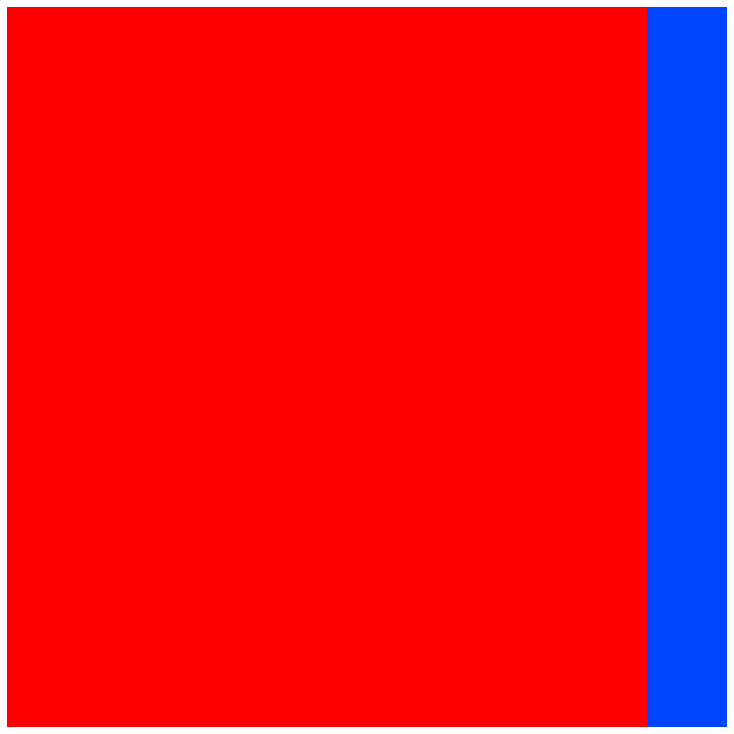

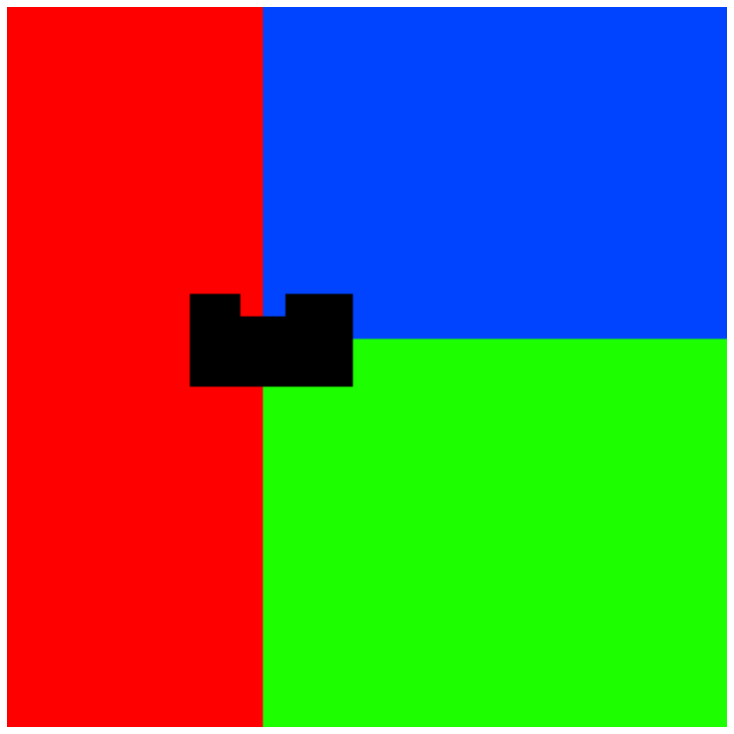

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


196
7727860
point chosen is: 109,94
5386960
coordinates are 4 4
4713590
coordinates are 4 87
4040220
coordinates are 4 88
3366850
coordinates are 4 89
2693480
coordinates are 4 90
2020110
coordinates are 4 91
1346740
coordinates are 4 92
673370
coordinates are 4 93
0
coordinates are 4 94


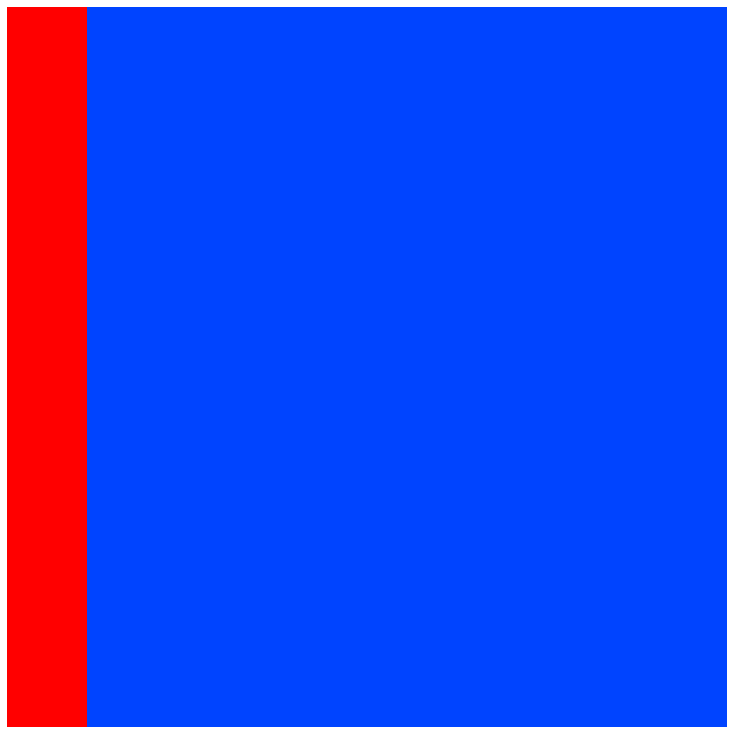

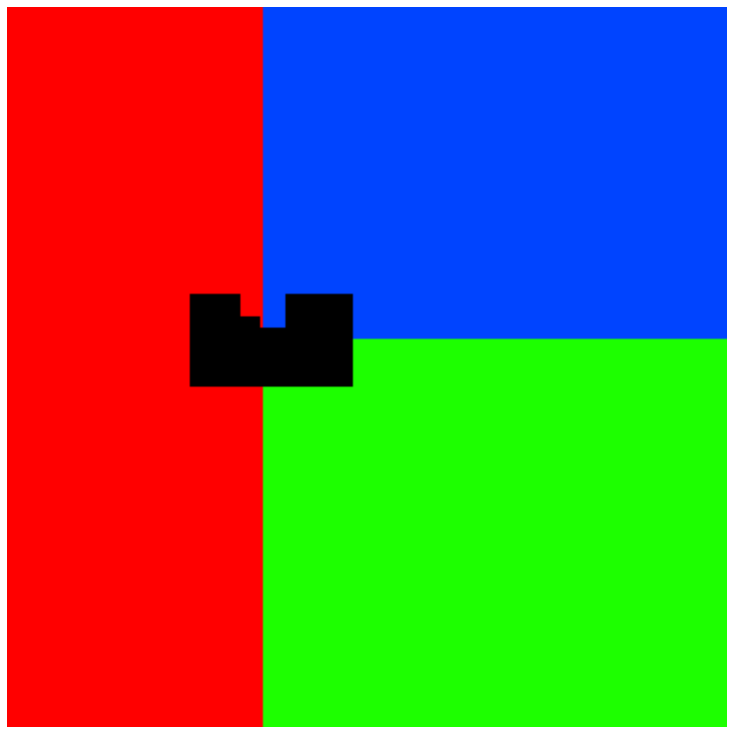

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


203
3032766
point chosen is: 109,87
1212066
coordinates are 4 4
0
coordinates are 4 87


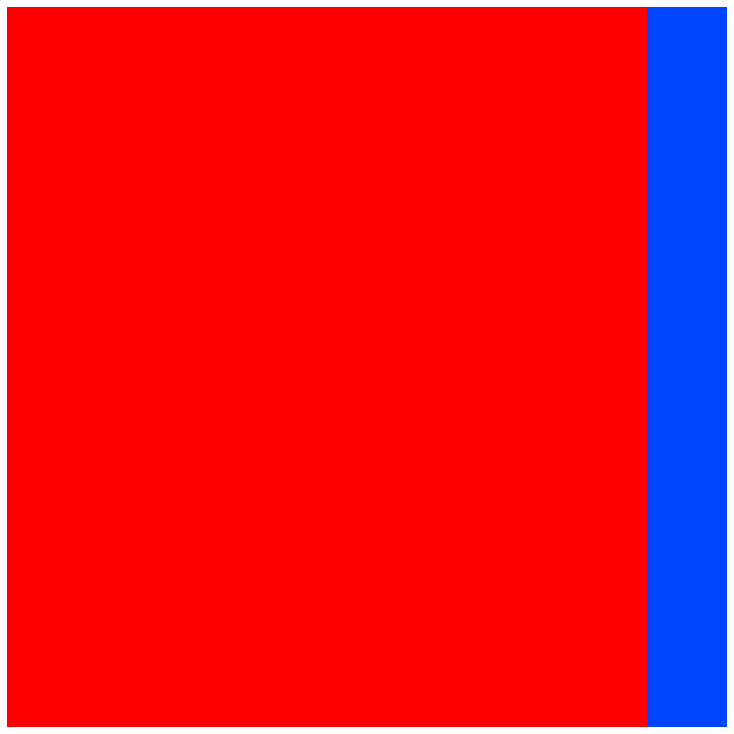

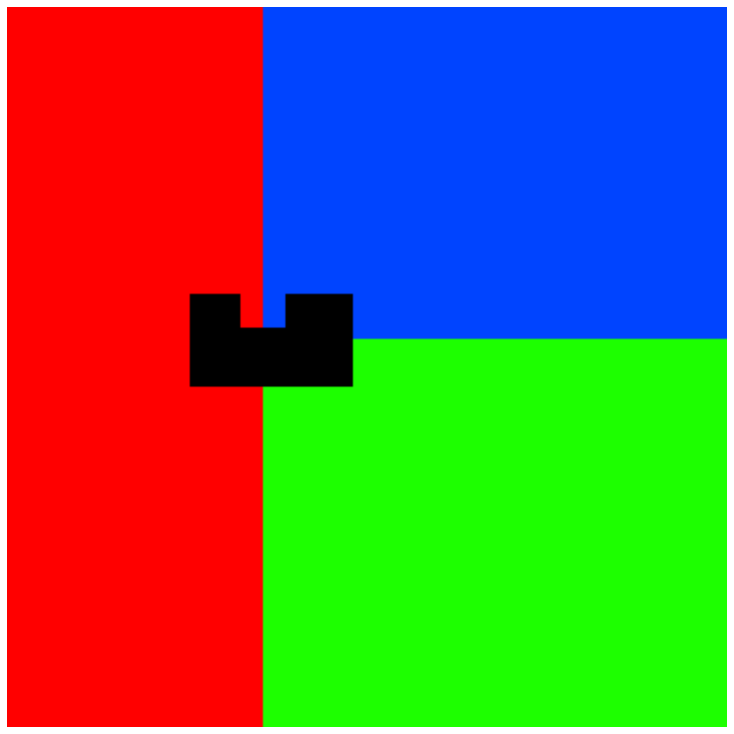

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


204
7727860
point chosen is: 113,94
5386960
coordinates are 4 4
4713590
coordinates are 4 87
4040220
coordinates are 4 88
3366850
coordinates are 4 89
2693480
coordinates are 4 90
2020110
coordinates are 4 91
1346740
coordinates are 4 92
673370
coordinates are 4 93
0
coordinates are 4 94


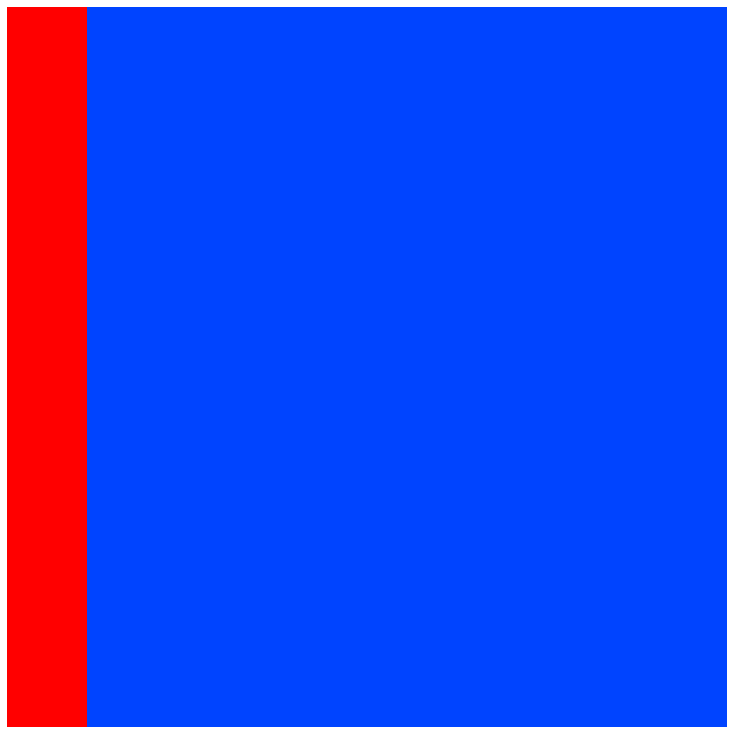

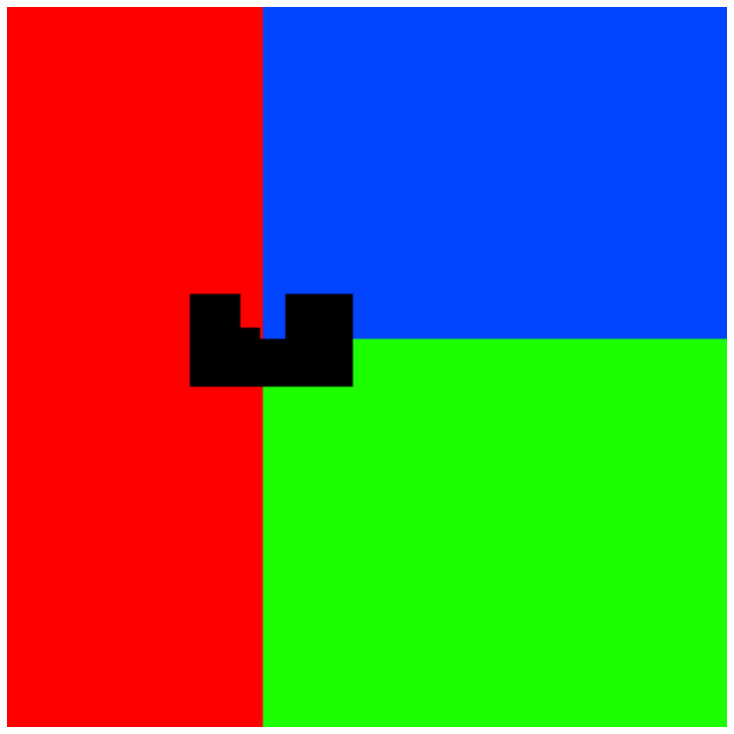

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


211
3032766
point chosen is: 113,87
1212066
coordinates are 4 4
0
coordinates are 4 87


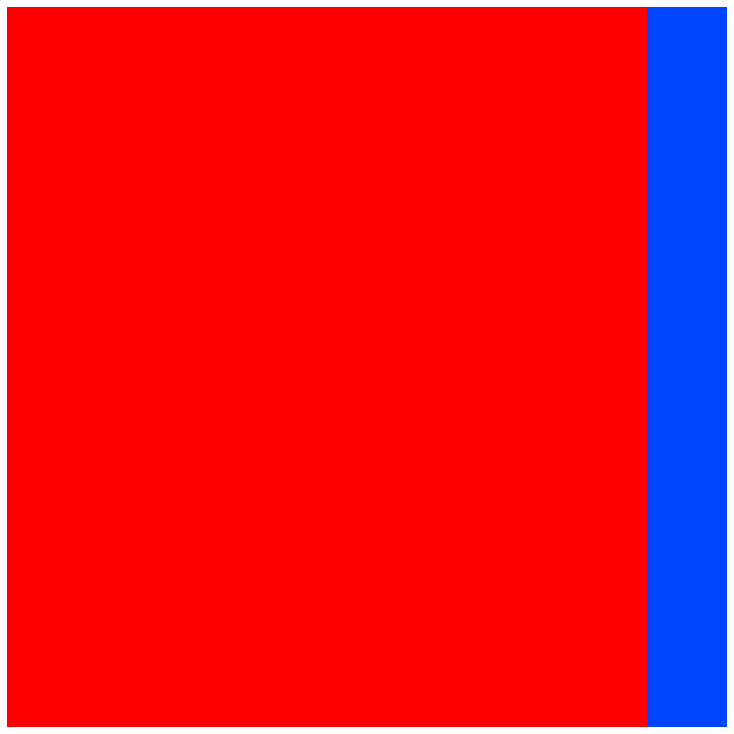

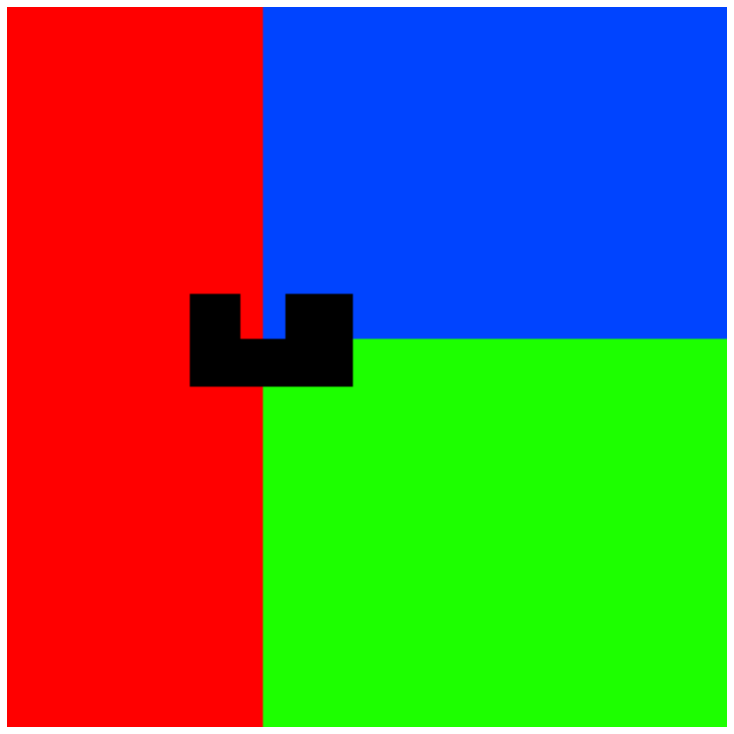

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


212
7727860
point chosen is: 117,94
5386960
coordinates are 4 4
4713590
coordinates are 4 87
4040220
coordinates are 4 88
3366850
coordinates are 4 89
2693480
coordinates are 4 90
2020110
coordinates are 4 91
1346740
coordinates are 4 92
673370
coordinates are 4 93
0
coordinates are 4 94


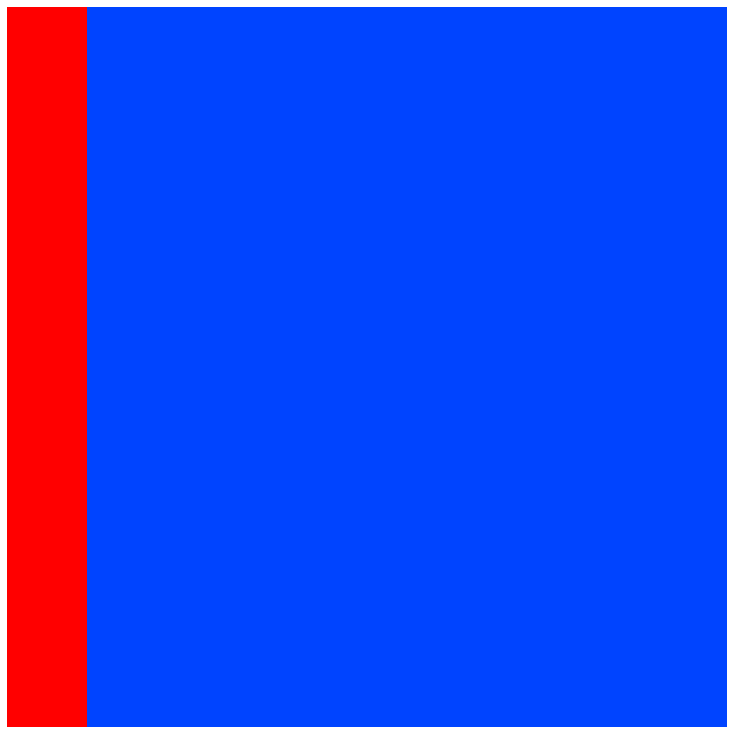

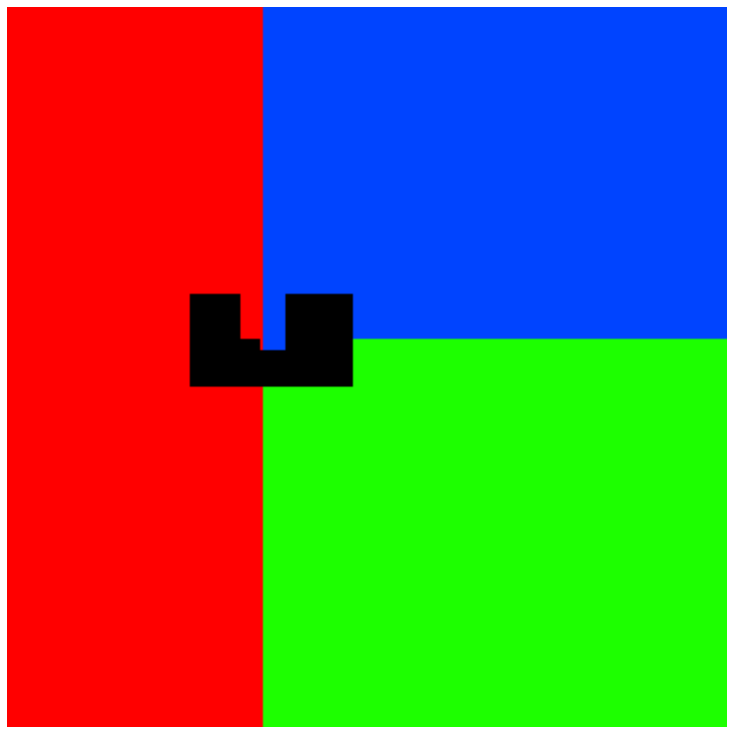

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


219
3032766
point chosen is: 117,87
1212066
coordinates are 4 4
0
coordinates are 4 87


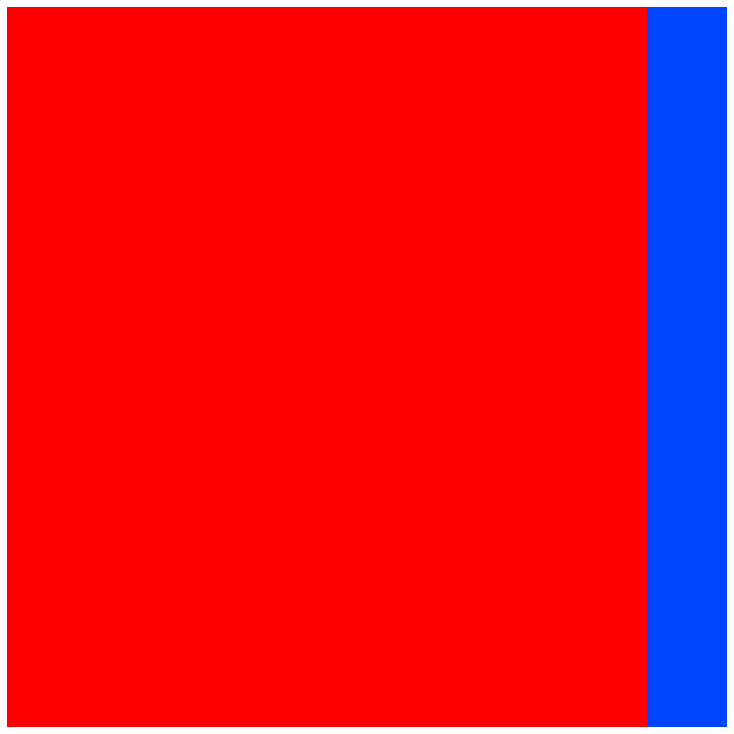

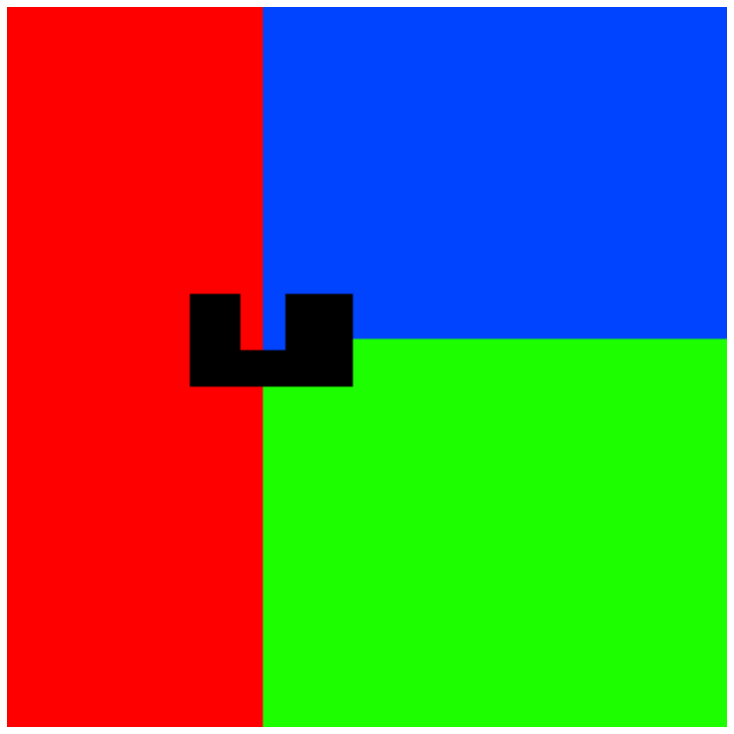

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


220
7727860
point chosen is: 121,94
5386960
coordinates are 4 4
4713590
coordinates are 4 87
4040220
coordinates are 4 88
3366850
coordinates are 4 89
2693480
coordinates are 4 90
2020110
coordinates are 4 91
1346740
coordinates are 4 92
673370
coordinates are 4 93
0
coordinates are 4 94


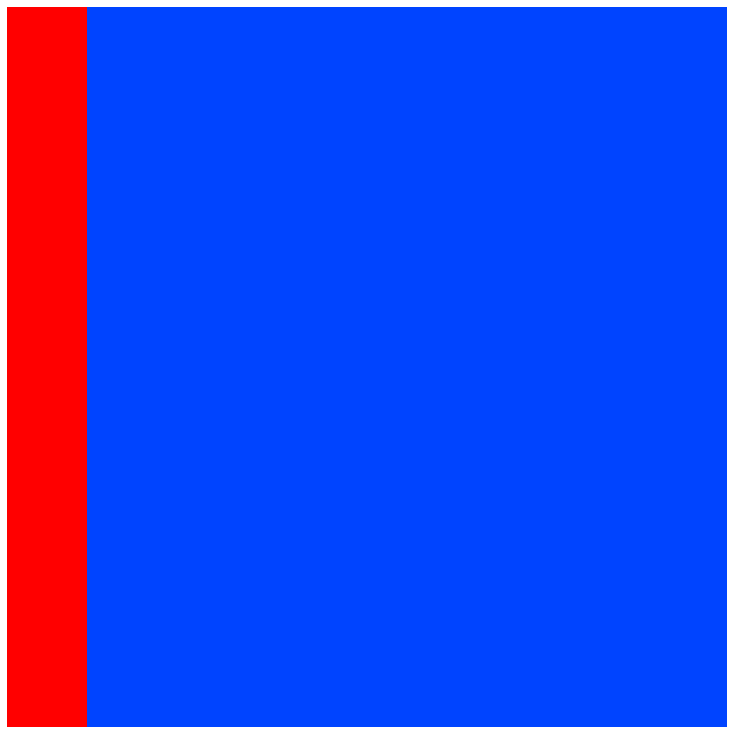

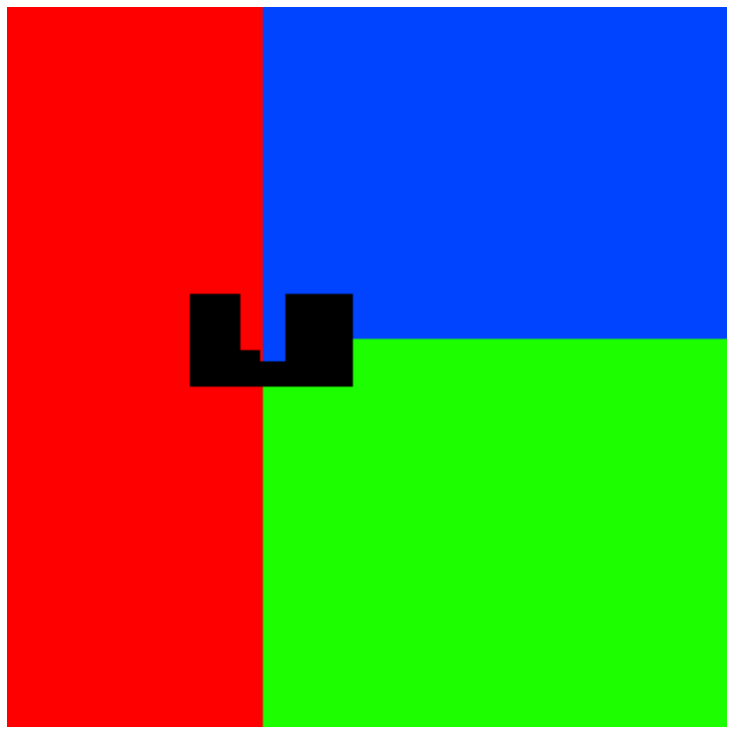

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


227
3032766
point chosen is: 121,87
1212066
coordinates are 4 4
0
coordinates are 4 87


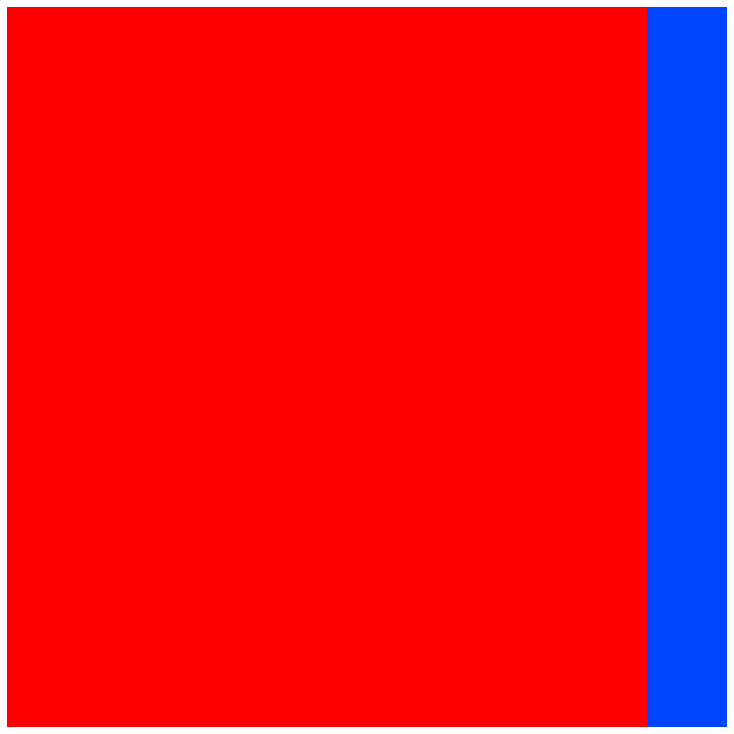

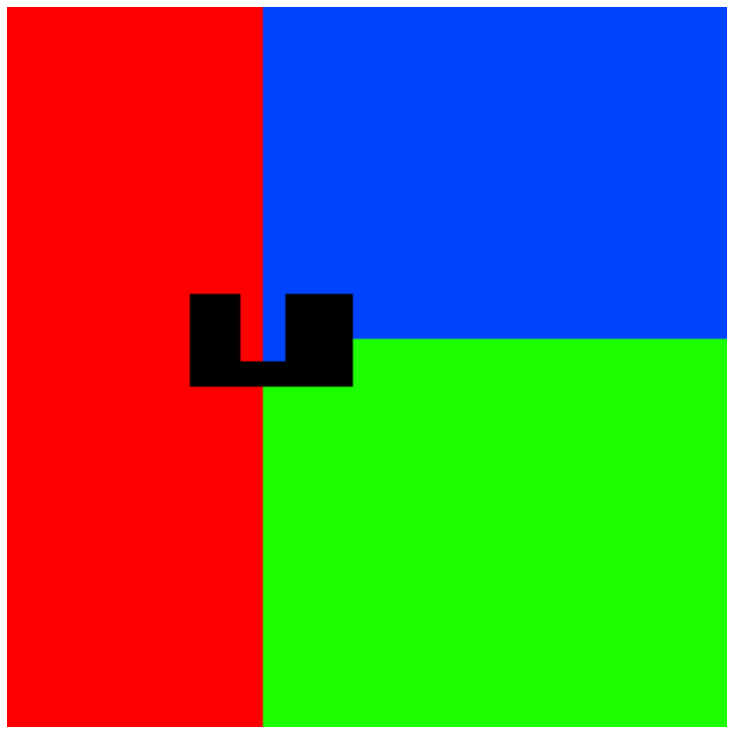

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


228
7727860
point chosen is: 125,94
5386960
coordinates are 4 4
4713590
coordinates are 4 87
4040220
coordinates are 4 88
3366850
coordinates are 4 89
2693480
coordinates are 4 90
2020110
coordinates are 4 91
1346740
coordinates are 4 92
673370
coordinates are 4 93
0
coordinates are 4 94


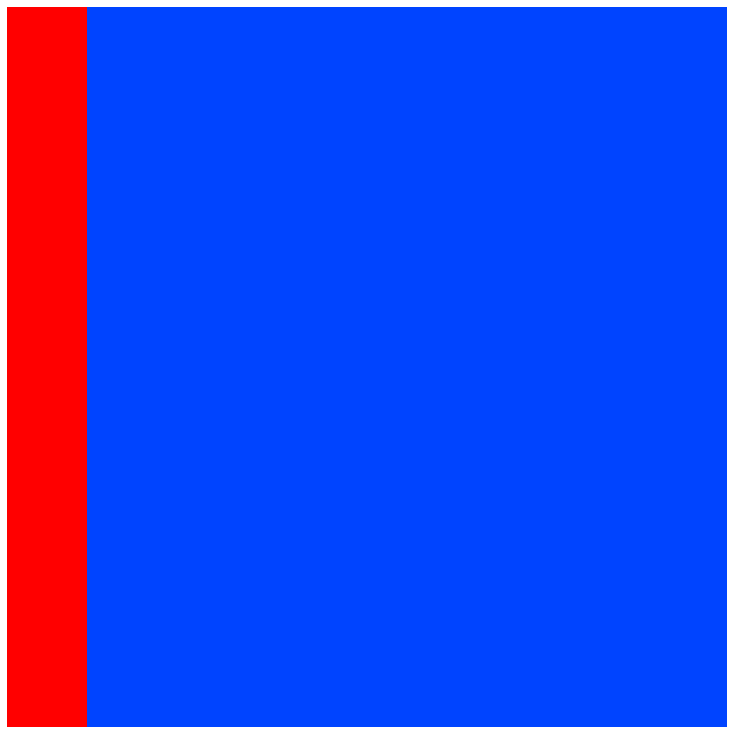

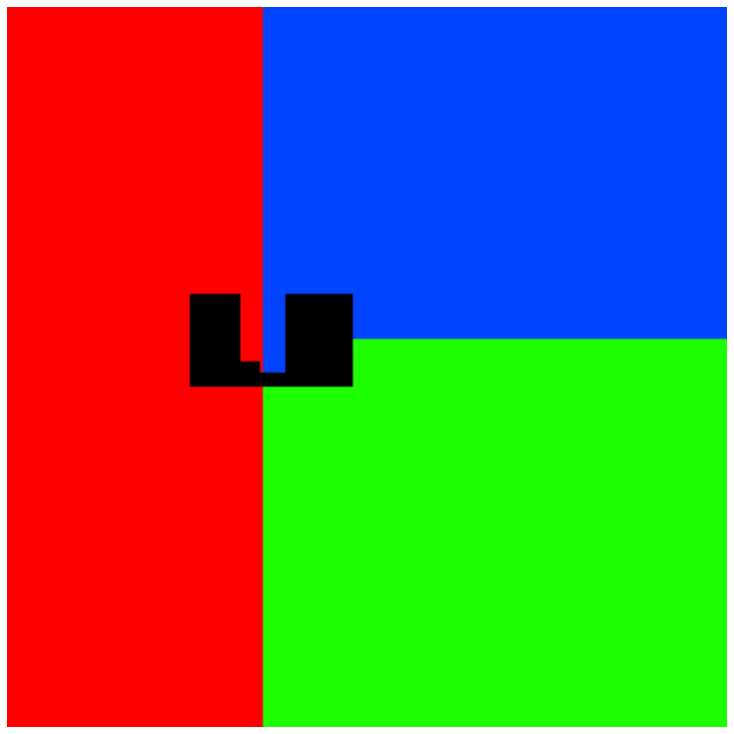

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


235
3032766
point chosen is: 125,87
1212066
coordinates are 4 4
0
coordinates are 4 87


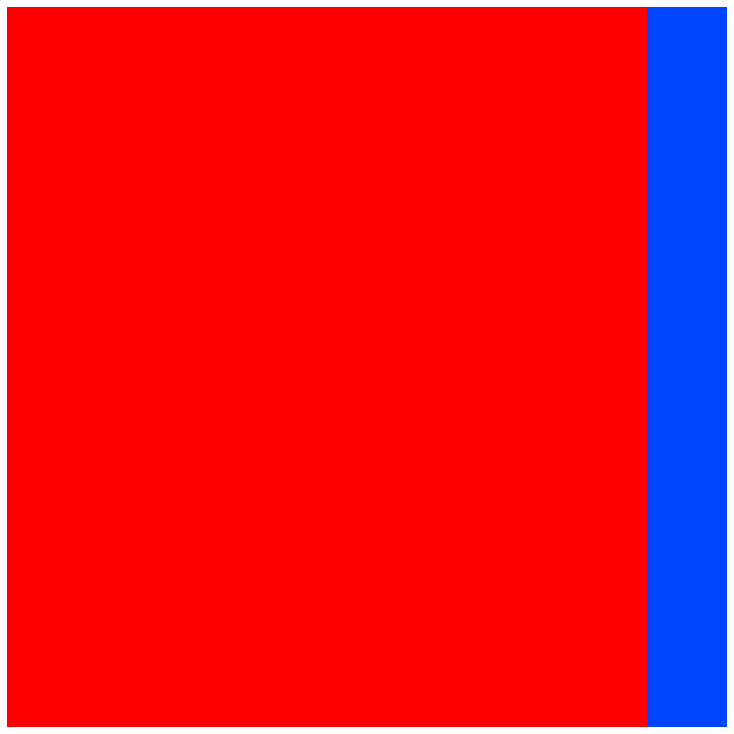

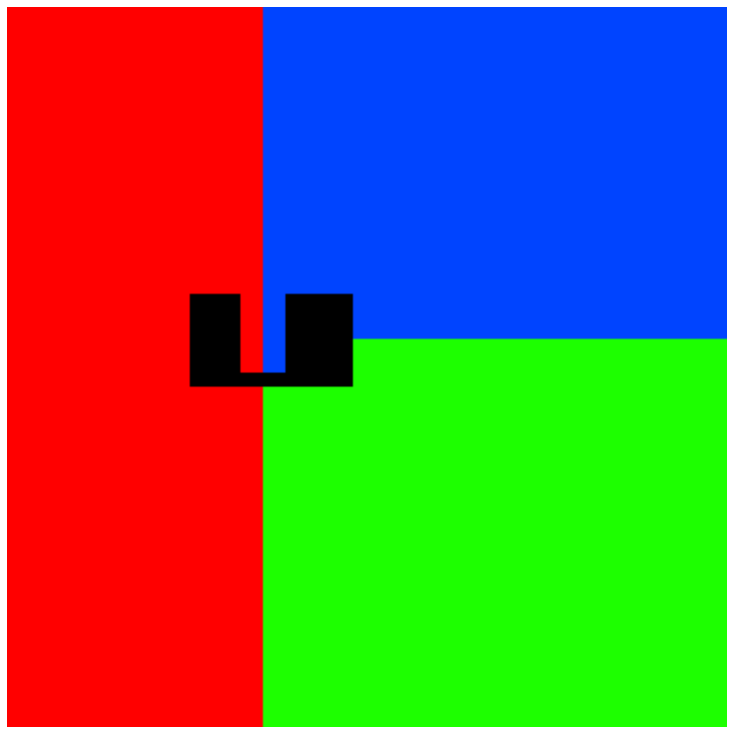

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


236
7727860
point chosen is: 129,94
5386960
coordinates are 4 4
4713590
coordinates are 4 87
4040220
coordinates are 4 88
3366850
coordinates are 4 89
2693480
coordinates are 4 90
2020110
coordinates are 4 91
1346740
coordinates are 4 92
673370
coordinates are 4 93
0
coordinates are 4 94


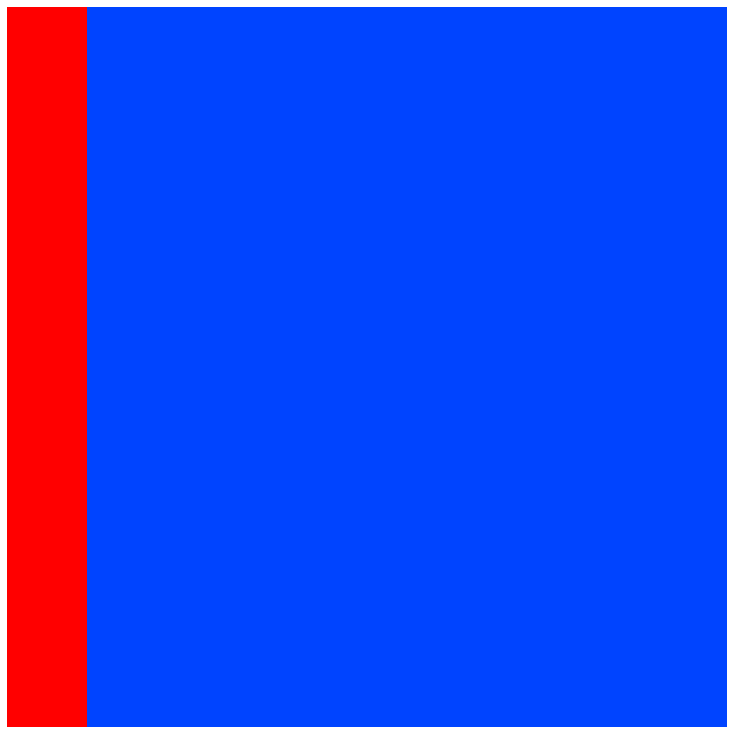

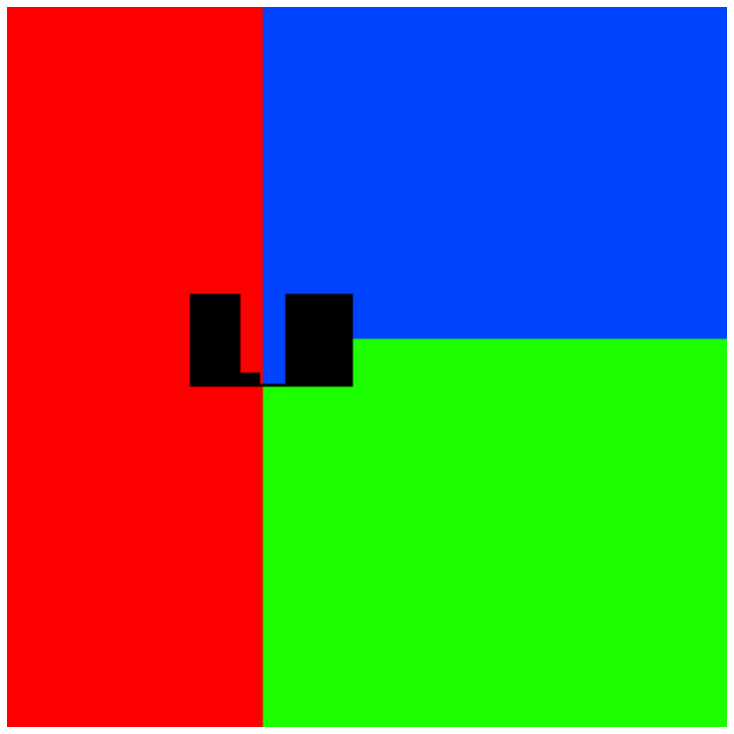

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


243
8461441
point chosen is: 135,94
7876216
coordinates are 4 4
7395864
coordinates are 4 87
6915512
coordinates are 4 88
6435160
coordinates are 4 89
5954808
coordinates are 4 90
5474456
coordinates are 4 91
4994104
coordinates are 4 92
4513752
coordinates are 4 93
4033400
coordinates are 4 94
3460286
coordinates are 115 127
2635033
coordinates are 116 127
1809780
coordinates are 117 127
984527
coordinates are 118 127


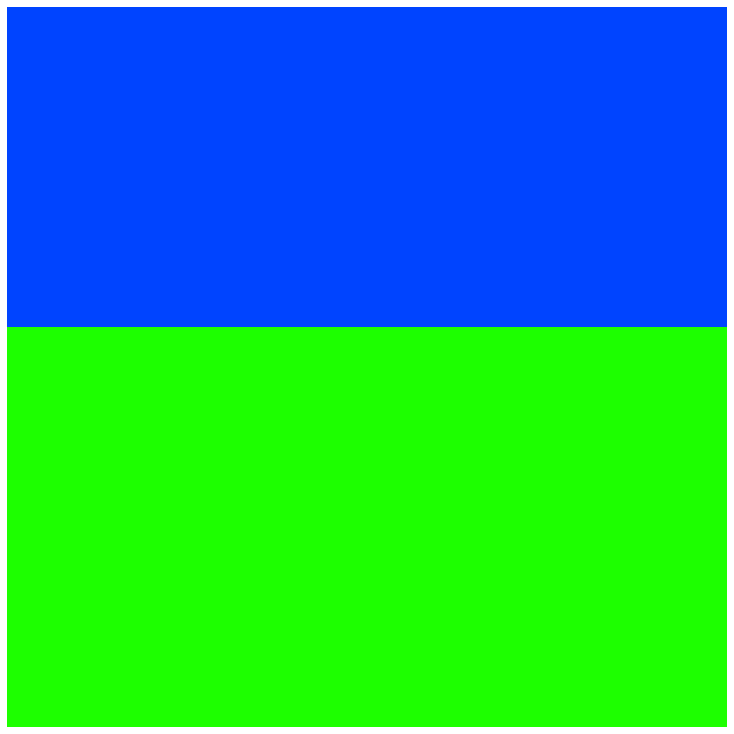

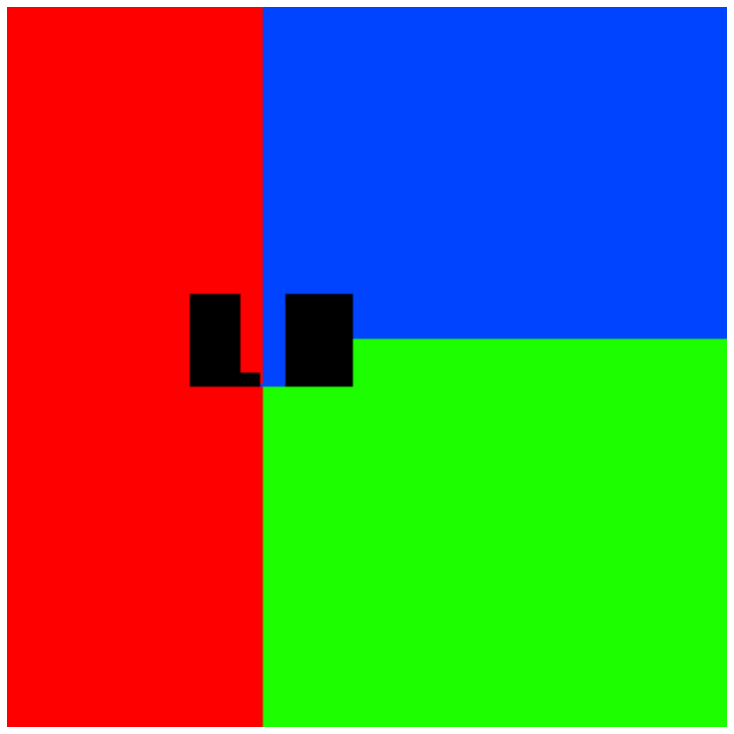

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


229
6209146
point chosen is: 131,90
4908646
coordinates are 4 4
3815988
coordinates are 4 87
2723330
coordinates are 4 88
1630672
coordinates are 4 89
538014
coordinates are 4 90


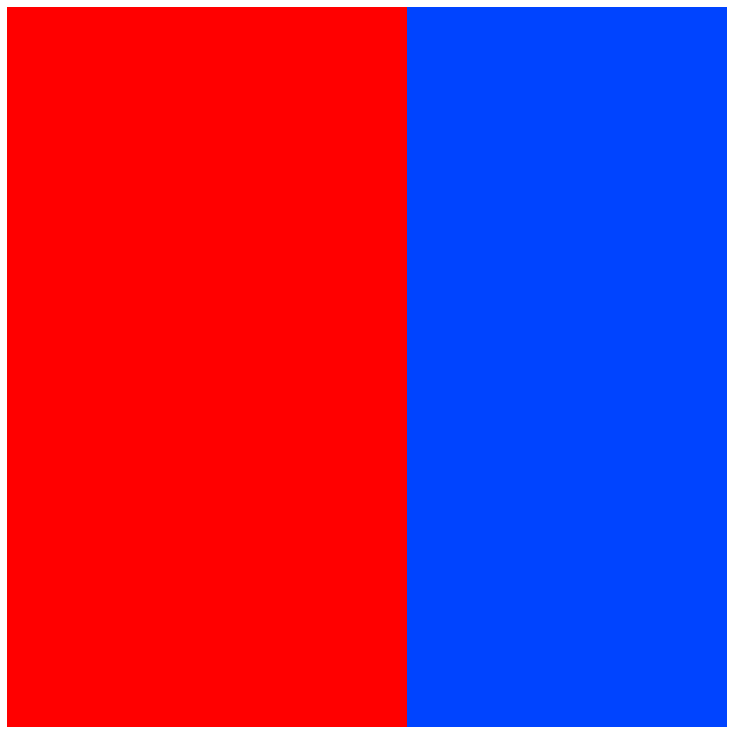

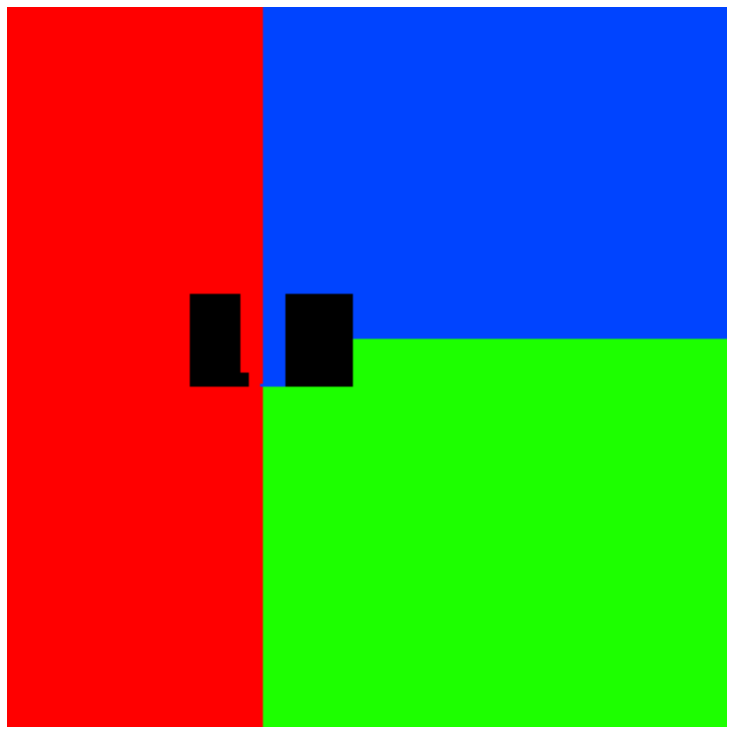

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


221
1695274
point chosen is: 130,86
134674
coordinates are 4 4
69649
coordinates are 98 61


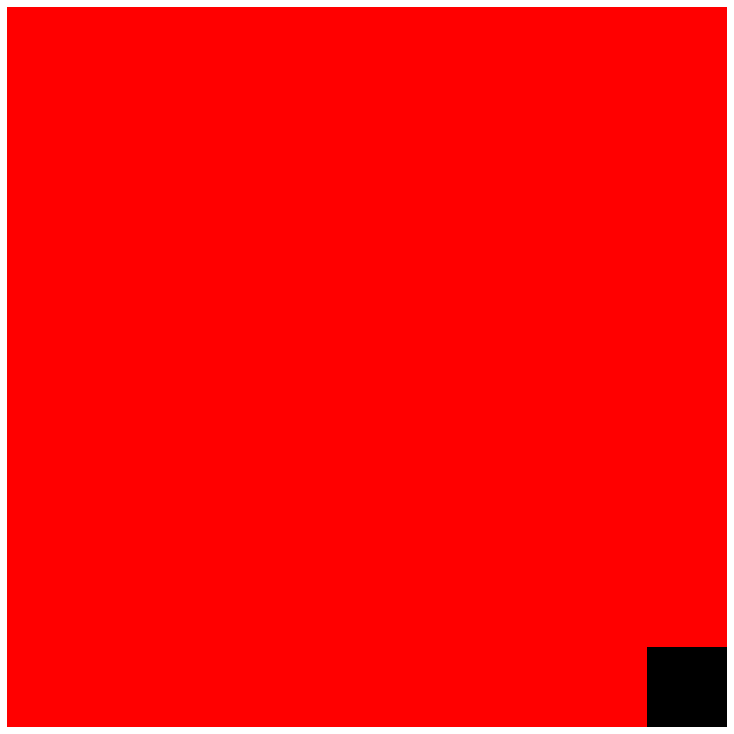

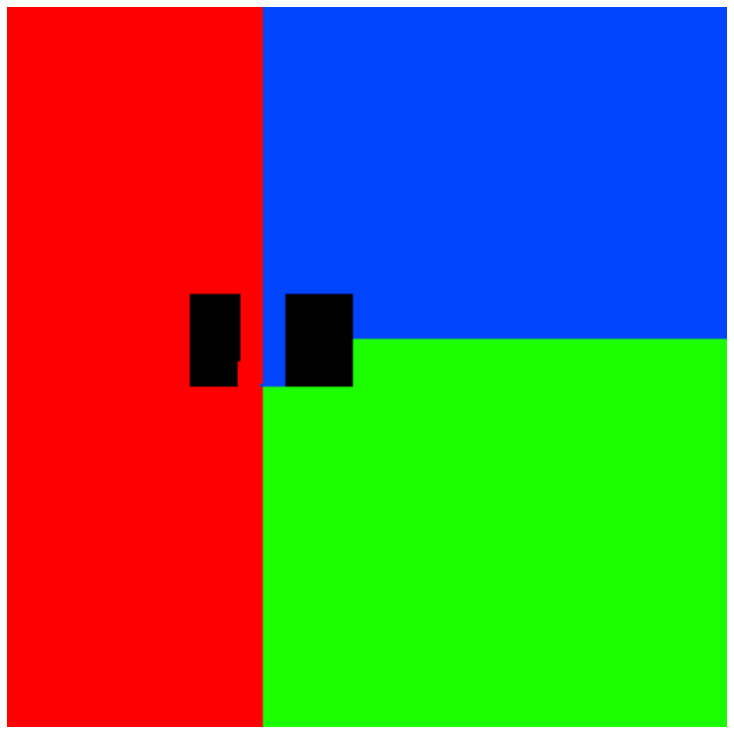

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


215
8512669
point chosen is: 131,98
6431869
coordinates are 4 4
6416603
coordinates are 4 87
6401337
coordinates are 4 88
6386071
coordinates are 4 89
6370805
coordinates are 4 90
5278147
coordinates are 4 91
4185489
coordinates are 4 92
3092831
coordinates are 4 93
2000173
coordinates are 4 94
907515
coordinates are 4 95
872546
coordinates are 98 95
837577
coordinates are 98 96
802608
coordinates are 98 97
767639
coordinates are 98 98
732670
coordinates are 98 99
697701
coordinates are 98 100
662732
coordinates are 98 101
627763
coordinates are 98 102
592794
coordinates are 98 103
0
coordinates are 114 127


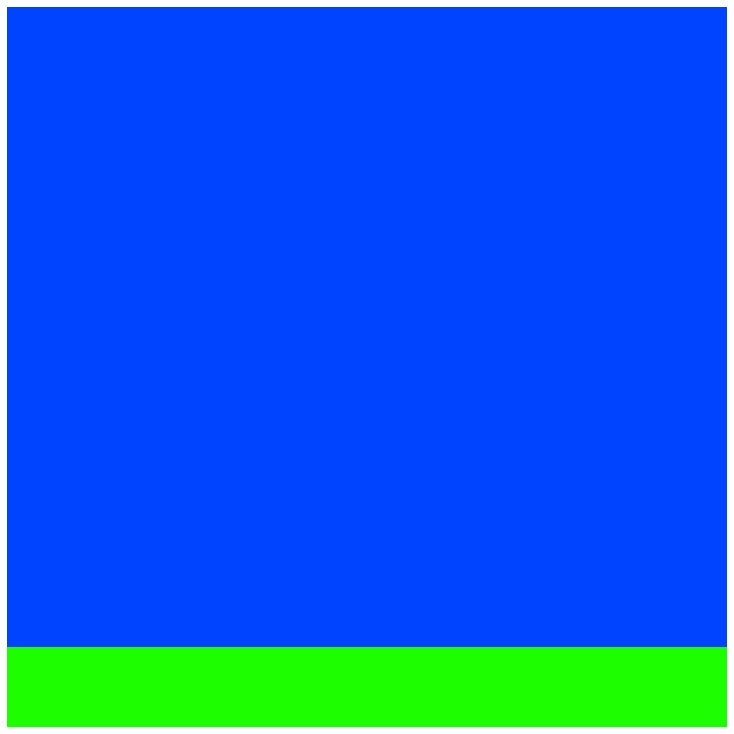

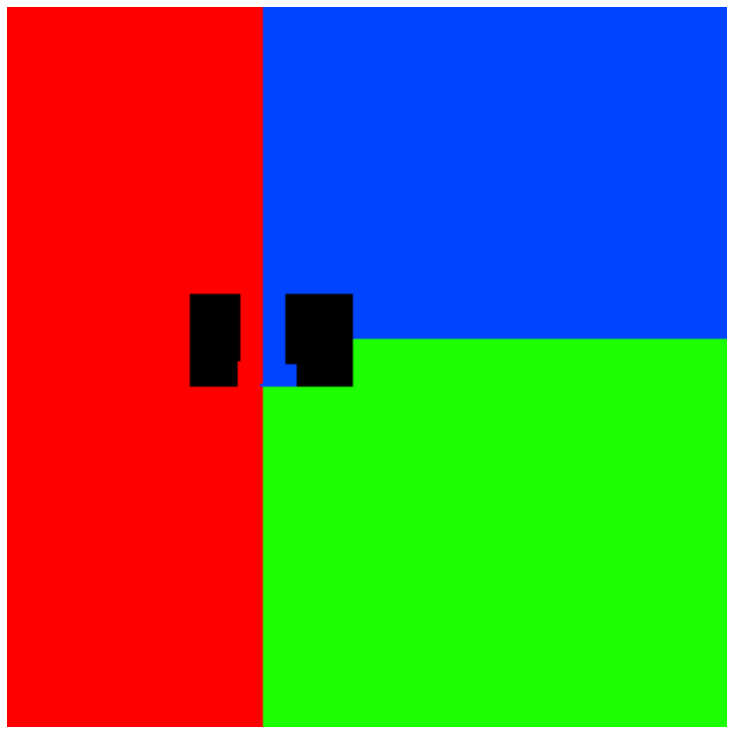

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


214
8512669
point chosen is: 131,102
6431869
coordinates are 4 4
6416603
coordinates are 4 87
6401337
coordinates are 4 88
6386071
coordinates are 4 89
6370805
coordinates are 4 90
5278147
coordinates are 4 91
4185489
coordinates are 4 92
3092831
coordinates are 4 93
2000173
coordinates are 4 94
907515
coordinates are 4 95
872546
coordinates are 98 95
837577
coordinates are 98 96
802608
coordinates are 98 97
767639
coordinates are 98 98
732670
coordinates are 98 99
697701
coordinates are 98 100
662732
coordinates are 98 101
627763
coordinates are 98 102
592794
coordinates are 98 103
0
coordinates are 114 127


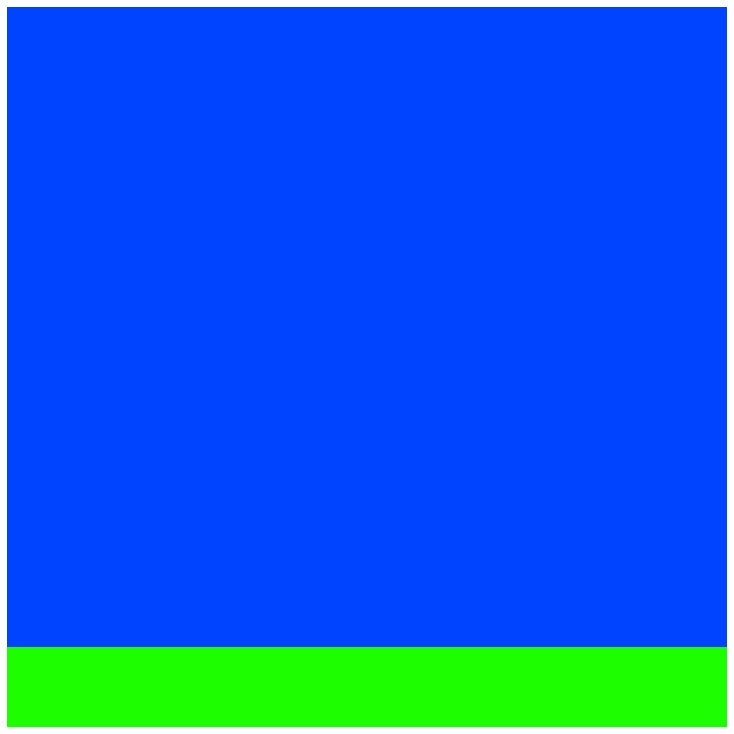

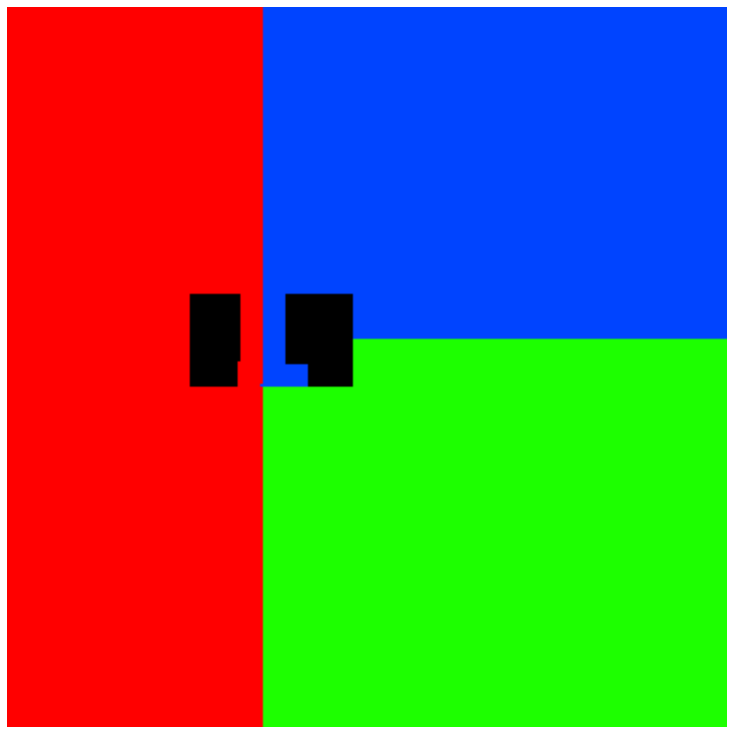

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


214
8512669
point chosen is: 131,106
6431869
coordinates are 4 4
6416603
coordinates are 4 87
6401337
coordinates are 4 88
6386071
coordinates are 4 89
6370805
coordinates are 4 90
5278147
coordinates are 4 91
4185489
coordinates are 4 92
3092831
coordinates are 4 93
2000173
coordinates are 4 94
907515
coordinates are 4 95
872546
coordinates are 98 95
837577
coordinates are 98 96
802608
coordinates are 98 97
767639
coordinates are 98 98
732670
coordinates are 98 99
697701
coordinates are 98 100
662732
coordinates are 98 101
627763
coordinates are 98 102
592794
coordinates are 98 103
0
coordinates are 114 127


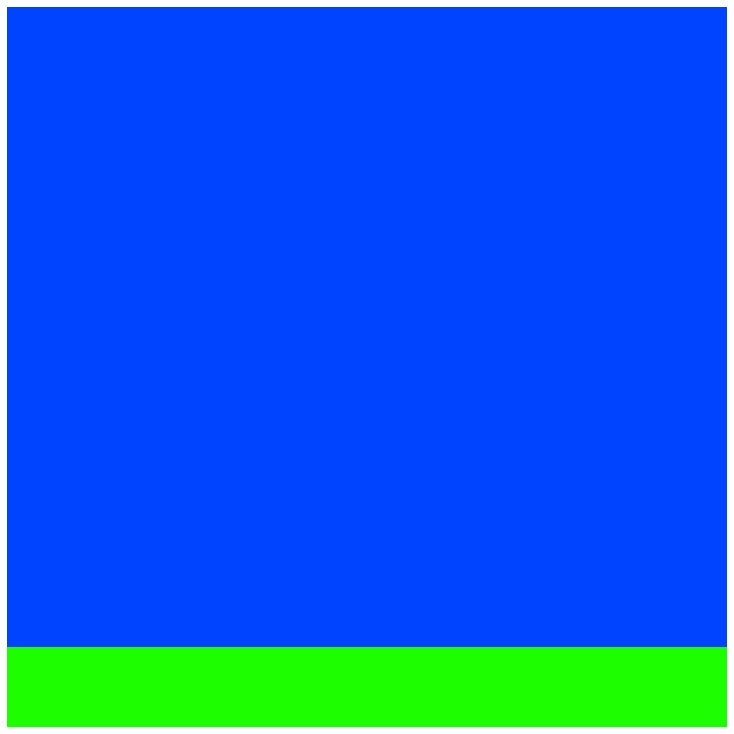

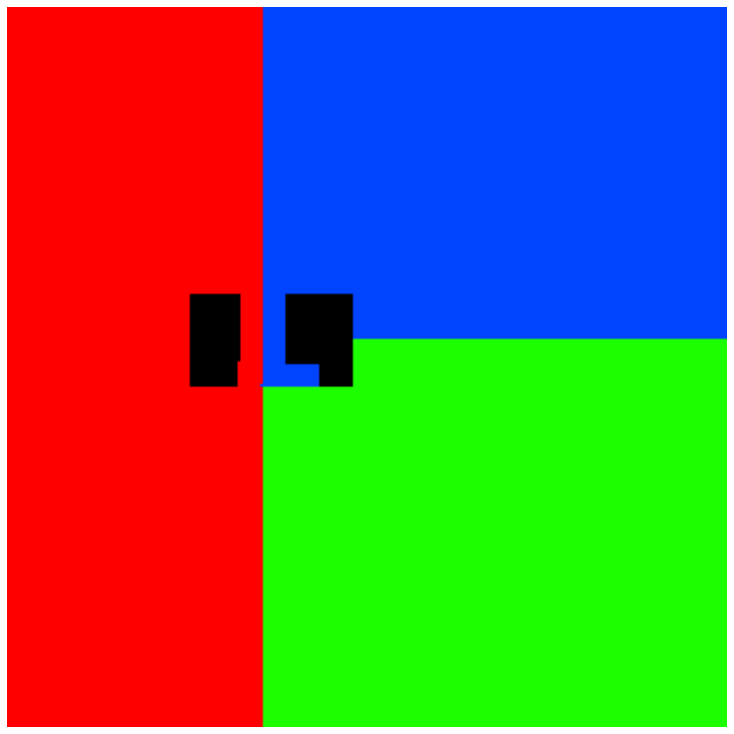

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


214
8512669
point chosen is: 131,110
6431869
coordinates are 4 4
6416603
coordinates are 4 87
6401337
coordinates are 4 88
6386071
coordinates are 4 89
6370805
coordinates are 4 90
5278147
coordinates are 4 91
4185489
coordinates are 4 92
3092831
coordinates are 4 93
2000173
coordinates are 4 94
907515
coordinates are 4 95
872546
coordinates are 98 95
837577
coordinates are 98 96
802608
coordinates are 98 97
767639
coordinates are 98 98
732670
coordinates are 98 99
697701
coordinates are 98 100
662732
coordinates are 98 101
627763
coordinates are 98 102
592794
coordinates are 98 103
0
coordinates are 114 127


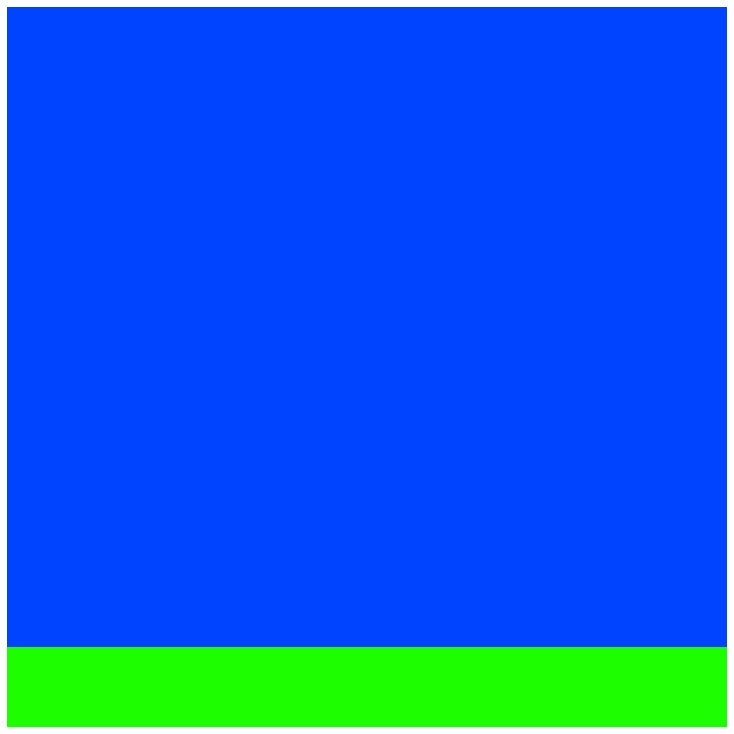

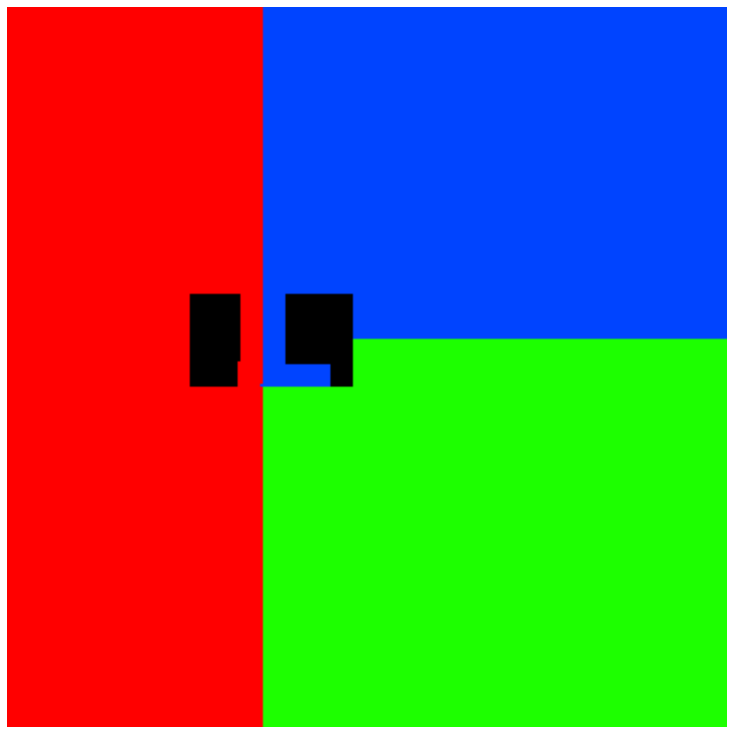

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


214
8512669
point chosen is: 131,114
6431869
coordinates are 4 4
6416603
coordinates are 4 87
6401337
coordinates are 4 88
6386071
coordinates are 4 89
6370805
coordinates are 4 90
5278147
coordinates are 4 91
4185489
coordinates are 4 92
3092831
coordinates are 4 93
2000173
coordinates are 4 94
907515
coordinates are 4 95
872546
coordinates are 98 95
837577
coordinates are 98 96
802608
coordinates are 98 97
767639
coordinates are 98 98
732670
coordinates are 98 99
697701
coordinates are 98 100
662732
coordinates are 98 101
627763
coordinates are 98 102
592794
coordinates are 98 103
0
coordinates are 114 127


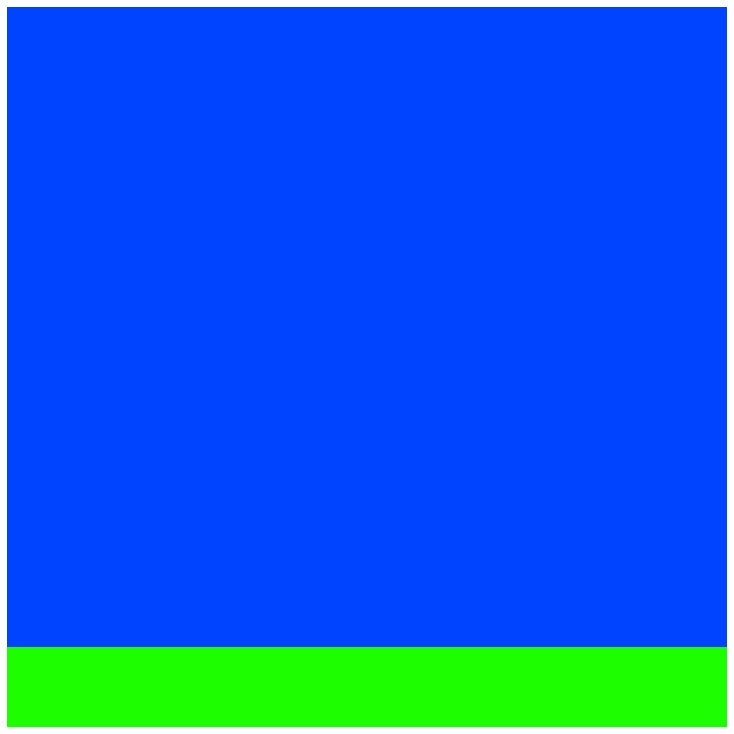

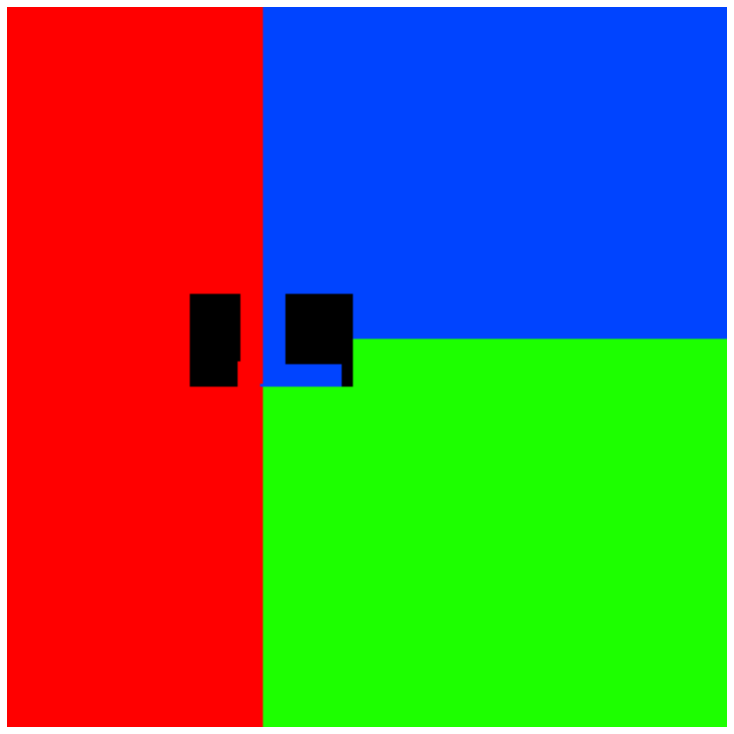

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


214
8512669
point chosen is: 131,118
6431869
coordinates are 4 4
6416603
coordinates are 4 87
6401337
coordinates are 4 88
6386071
coordinates are 4 89
6370805
coordinates are 4 90
5278147
coordinates are 4 91
4185489
coordinates are 4 92
3092831
coordinates are 4 93
2000173
coordinates are 4 94
907515
coordinates are 4 95
872546
coordinates are 98 95
837577
coordinates are 98 96
802608
coordinates are 98 97
767639
coordinates are 98 98
732670
coordinates are 98 99
697701
coordinates are 98 100
662732
coordinates are 98 101
627763
coordinates are 98 102
592794
coordinates are 98 103
0
coordinates are 114 127


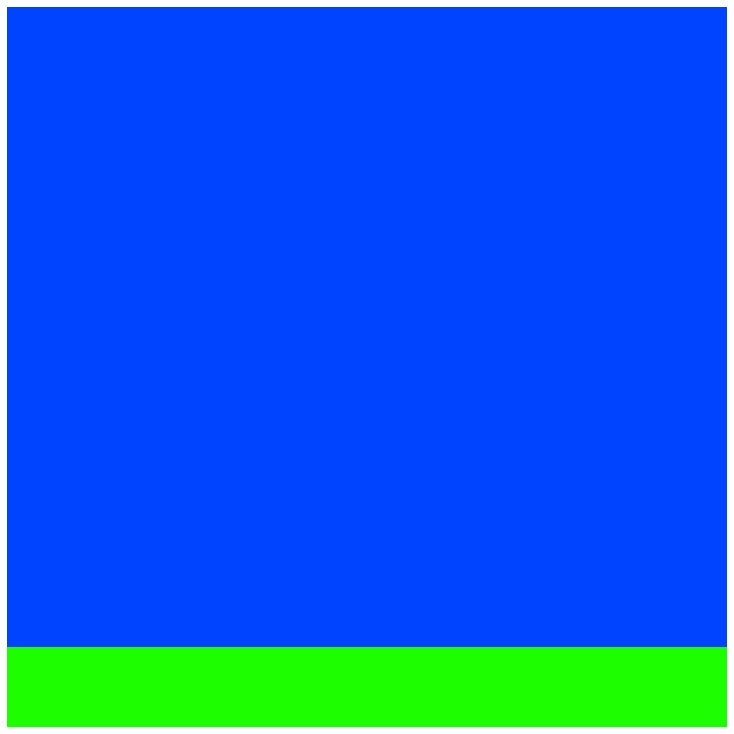

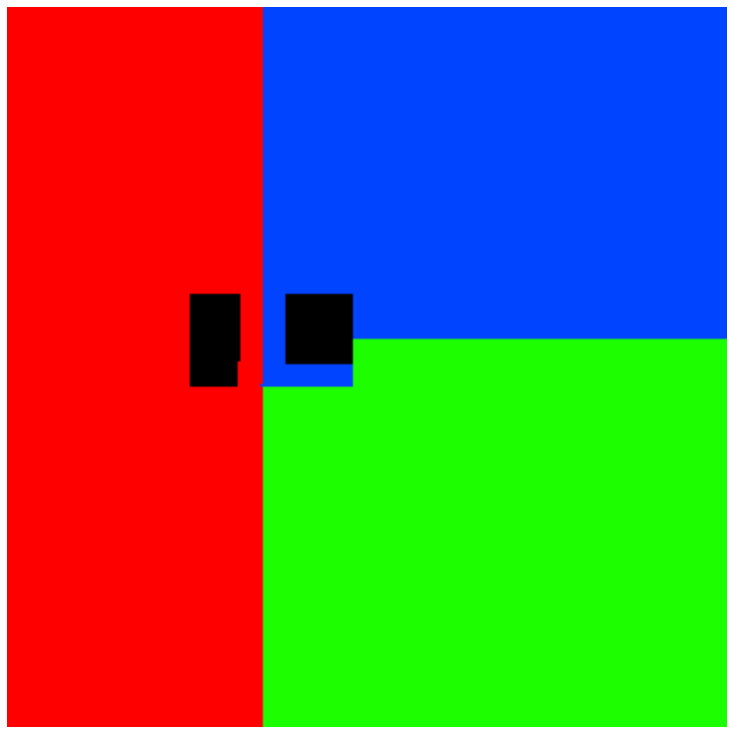

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


199
8512669
point chosen is: 127,119
6431869
coordinates are 4 4
6294475
coordinates are 4 87
5621105
coordinates are 4 88
4947735
coordinates are 4 89
4274365
coordinates are 4 90
3600995
coordinates are 4 91
2927625
coordinates are 4 92
2254255
coordinates are 4 93
1580885
coordinates are 4 94
907515
coordinates are 4 95
872546
coordinates are 98 95


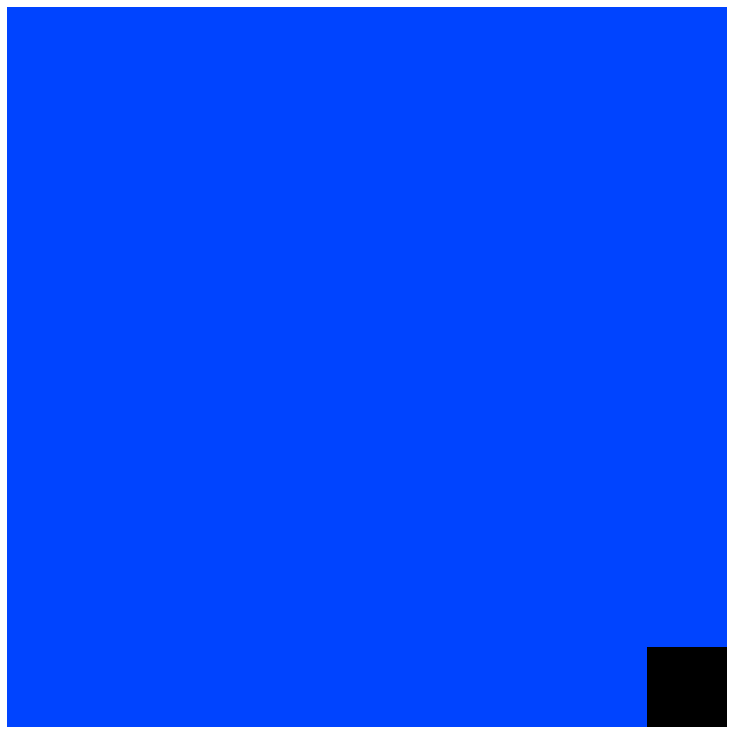

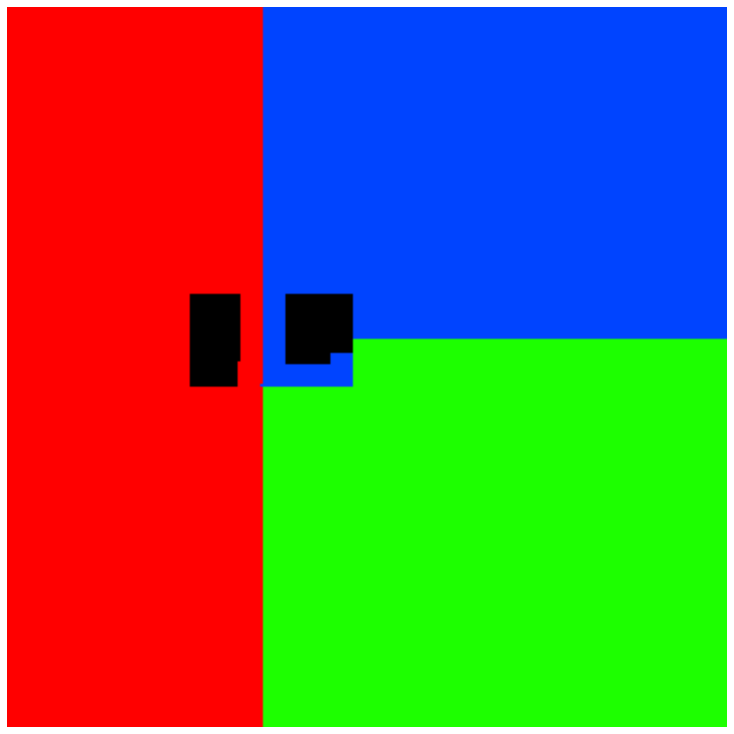

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


198
8494098
point chosen is: 121,123
6933498
coordinates are 4 4
6676696
coordinates are 4 87
6419894
coordinates are 4 88
6163092
coordinates are 4 89
5906290
coordinates are 4 90
5649488
coordinates are 4 91
5245466
coordinates are 4 92
4841444
coordinates are 4 93
4437422
coordinates are 4 94
4033400
coordinates are 4 95
3998431
coordinates are 98 95
3963462
coordinates are 98 96
3928493
coordinates are 98 97
3893524
coordinates are 98 98
3858555
coordinates are 98 99
3831730
coordinates are 115 127
3730895
coordinates are 116 127
3226720
coordinates are 117 127
2722545
coordinates are 118 127
2218370
coordinates are 119 127
1714195
coordinates are 120 127
1210020
coordinates are 121 127


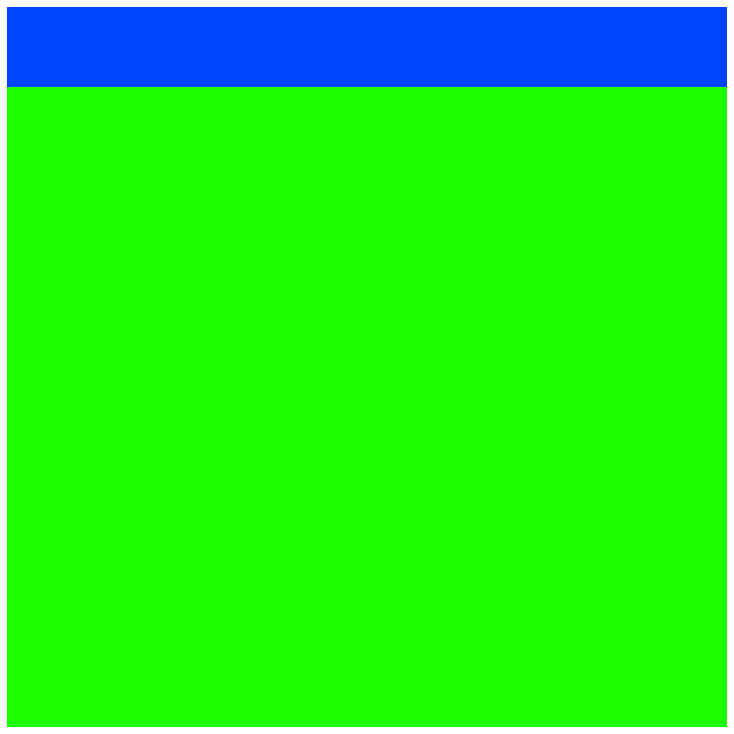

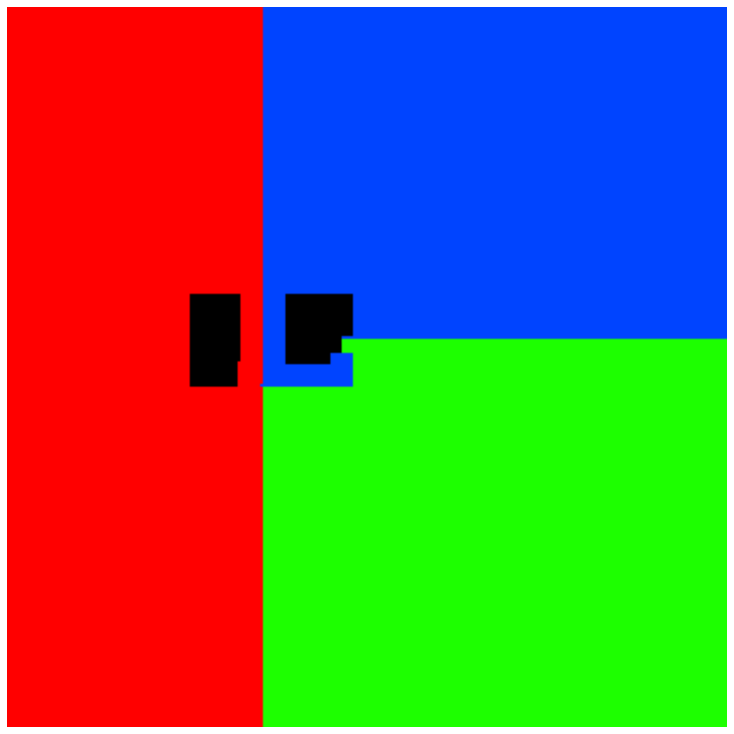

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


197
9218445
point chosen is: 126,115
7657845
coordinates are 4 4
6565187
coordinates are 4 87
5487795
coordinates are 4 88
4410403
coordinates are 4 89
3333011
coordinates are 4 90
2255619
coordinates are 4 91
1716923
coordinates are 4 92
1178227
coordinates are 4 93
639531
coordinates are 4 94
100835
coordinates are 4 95


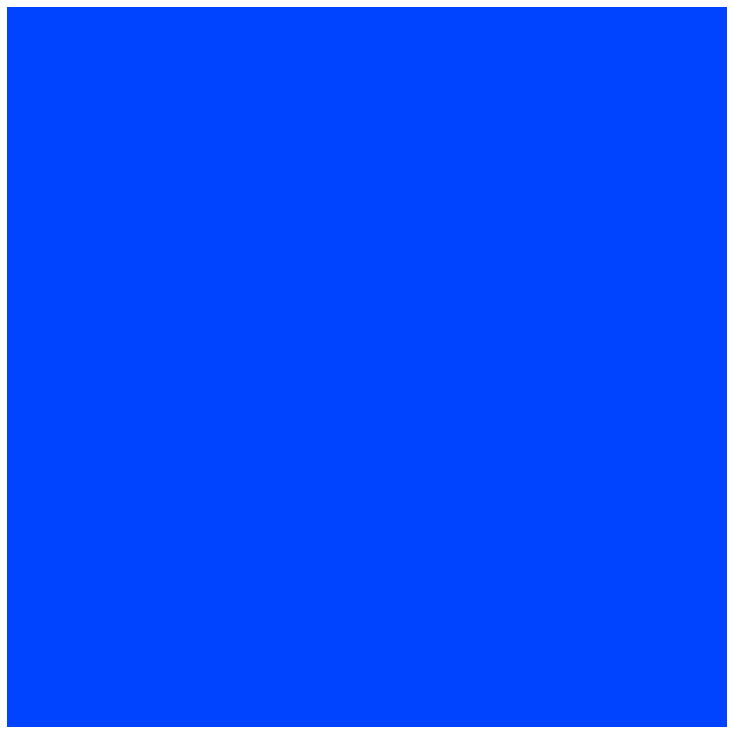

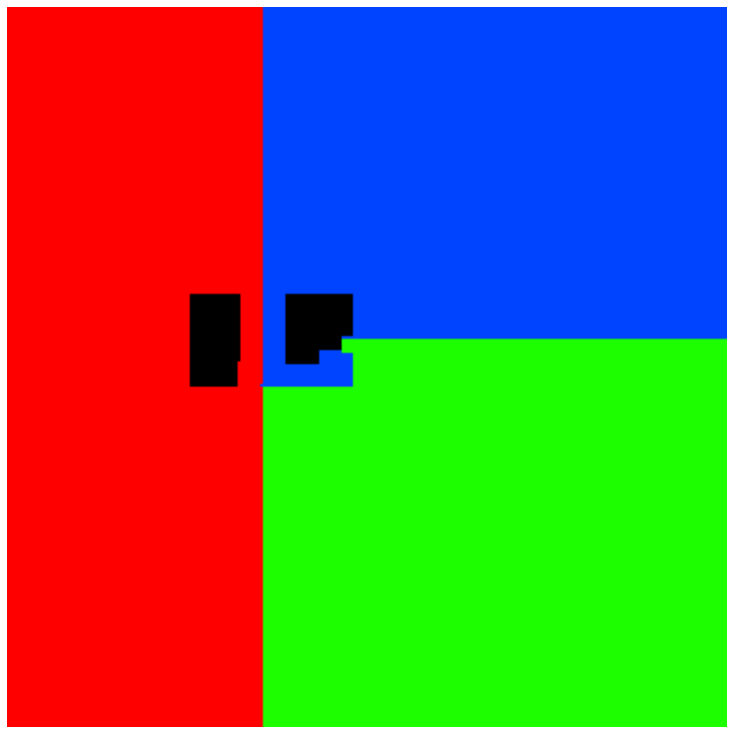

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


197
8995570
point chosen is: 121,119
7695070
coordinates are 4 4
7438268
coordinates are 4 87
6823242
coordinates are 4 88
6208216
coordinates are 4 89
5593190
coordinates are 4 90
4978164
coordinates are 4 91
4439468
coordinates are 4 92
3900772
coordinates are 4 93
3362076
coordinates are 4 94
2823380
coordinates are 4 95
2788411
coordinates are 98 95


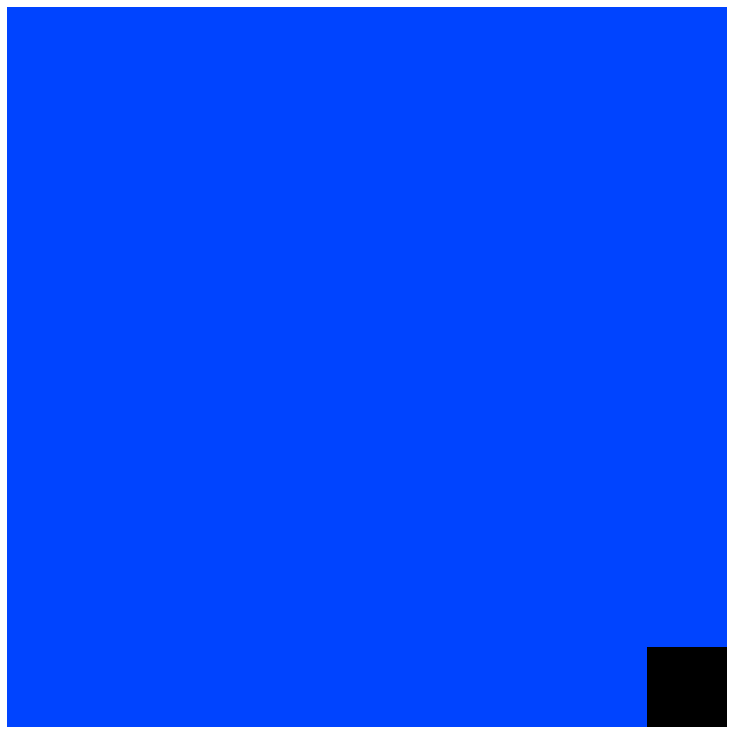

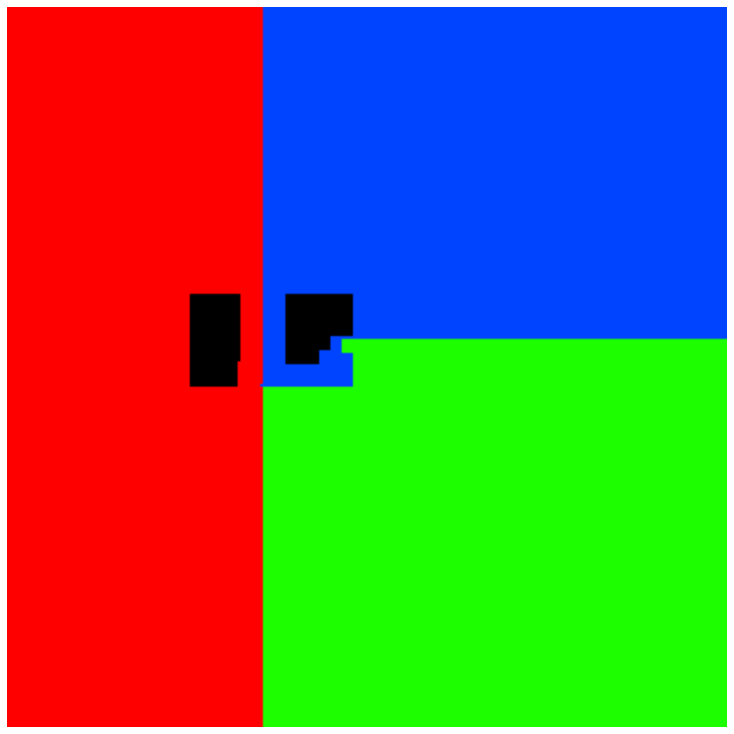

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


197
8921278
point chosen is: 117,122
7620778
coordinates are 4 4
6886344
coordinates are 4 87
6151910
coordinates are 4 88
5417476
coordinates are 4 89
4683042
coordinates are 4 90
4487304
coordinates are 4 91
4291566
coordinates are 4 92
4095828
coordinates are 4 93
3900090
coordinates are 4 94
3226720
coordinates are 4 95
3191751
coordinates are 98 95
3156782
coordinates are 98 96
3121813
coordinates are 98 97
3086844
coordinates are 98 98
3051875
coordinates are 98 99
3016906
coordinates are 98 100
2981937
coordinates are 98 101
2946968
coordinates are 98 102
2520875
coordinates are 114 127
1815030
coordinates are 115 127
1109185
coordinates are 116 127
403340
coordinates are 117 127


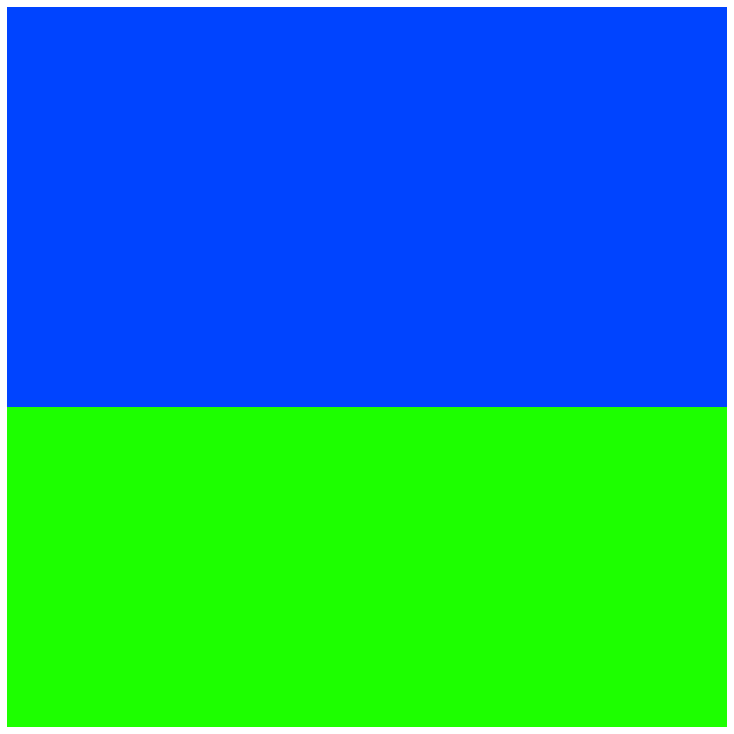

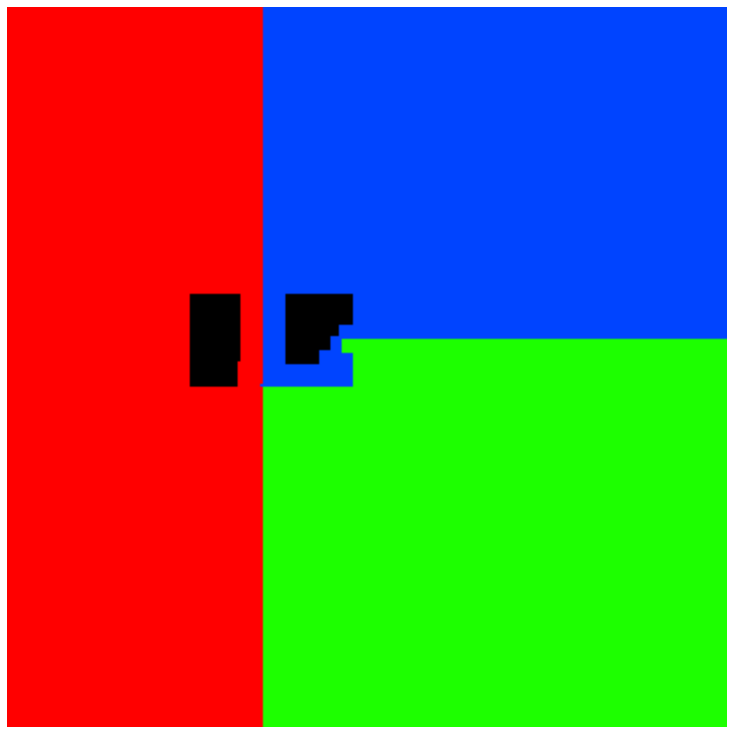

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


196
7491150
point chosen is: 117,115
4369950
coordinates are 4 4
3635516
coordinates are 4 87
2423450
coordinates are 4 88
1750080
coordinates are 4 89
1076710
coordinates are 4 90
403340
coordinates are 4 91
368371
coordinates are 98 95


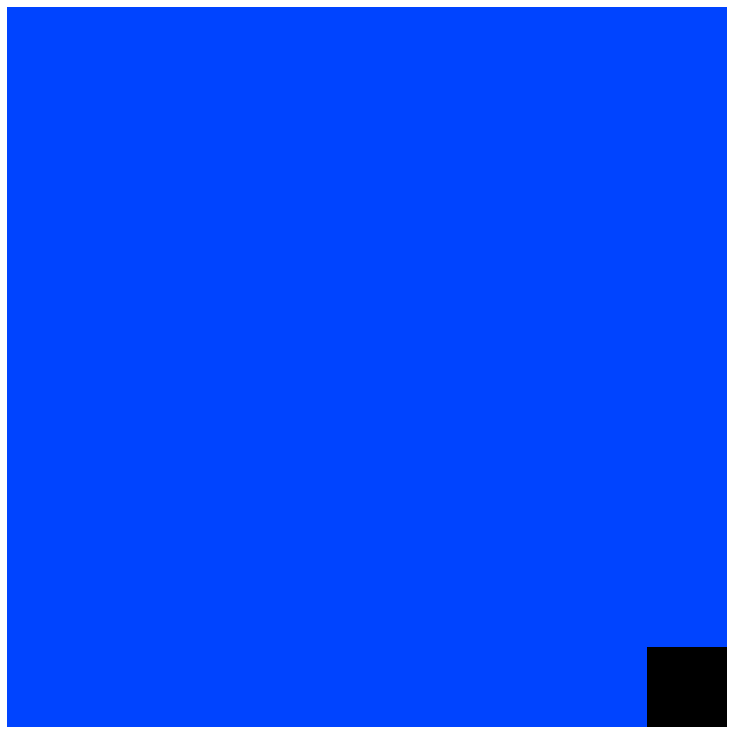

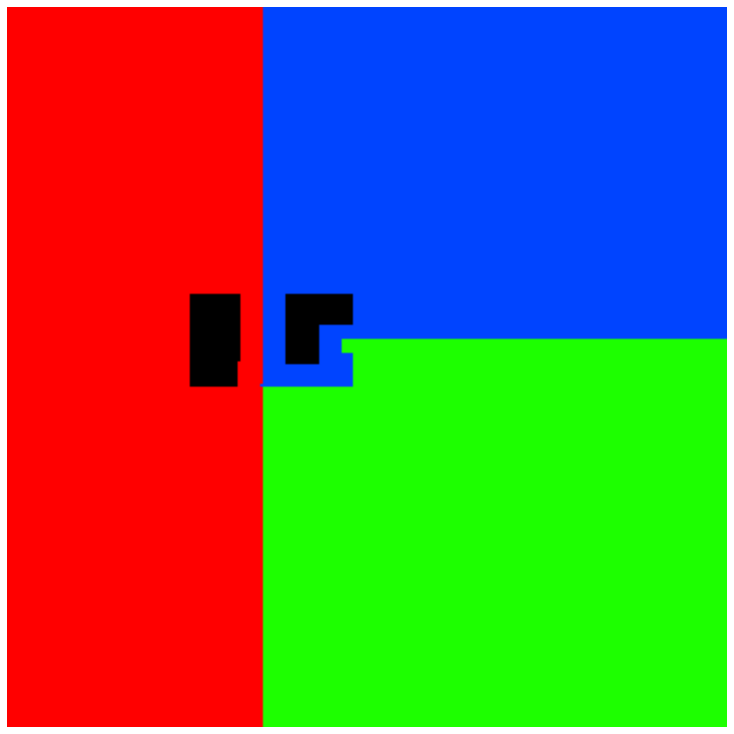

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


198
1300500
point chosen is: 135,81
0
coordinates are 4 4


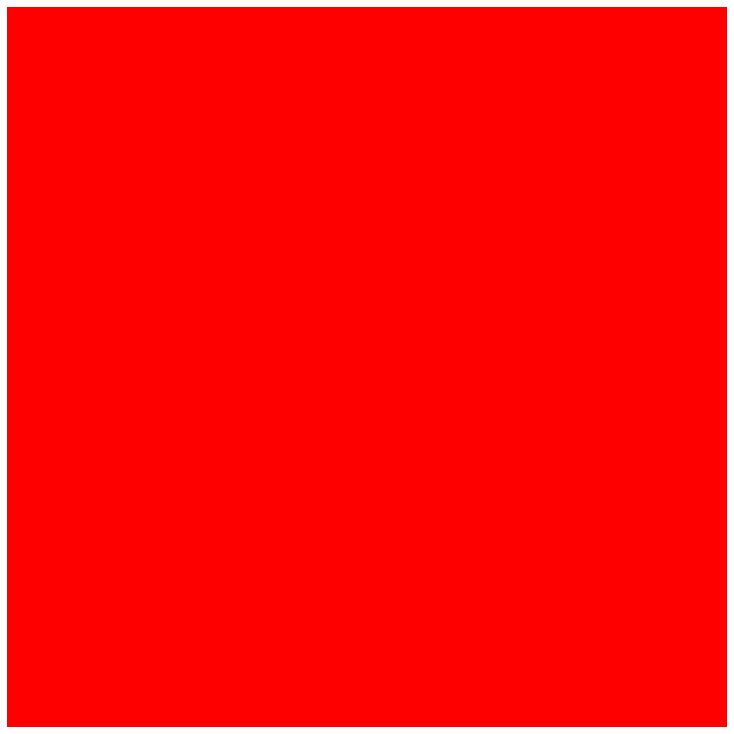

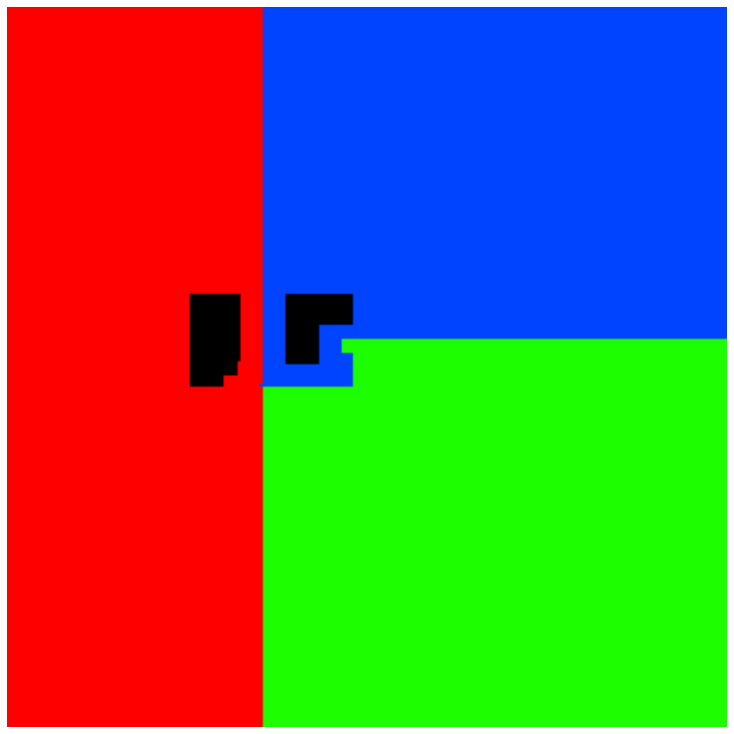

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


197
1300500
point chosen is: 135,76
0
coordinates are 4 4


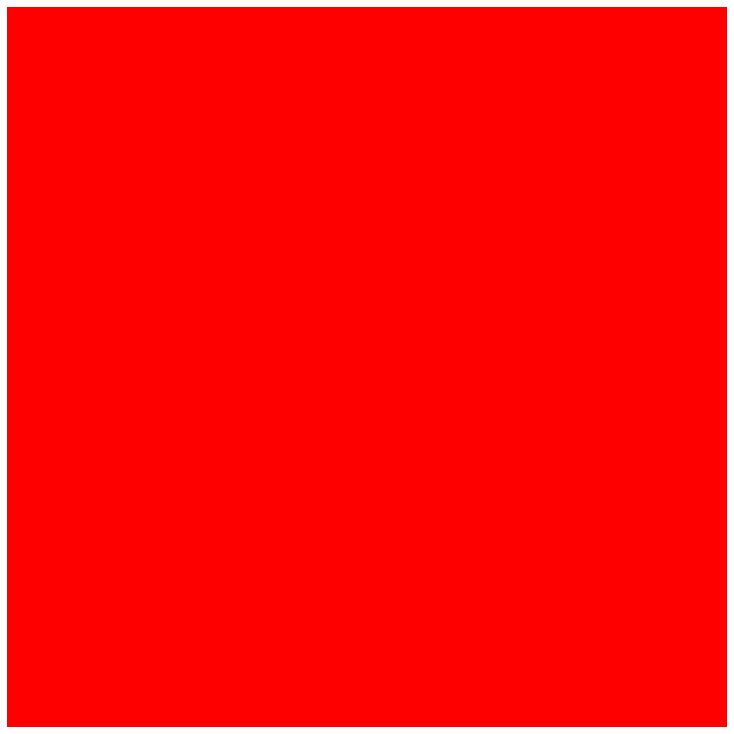

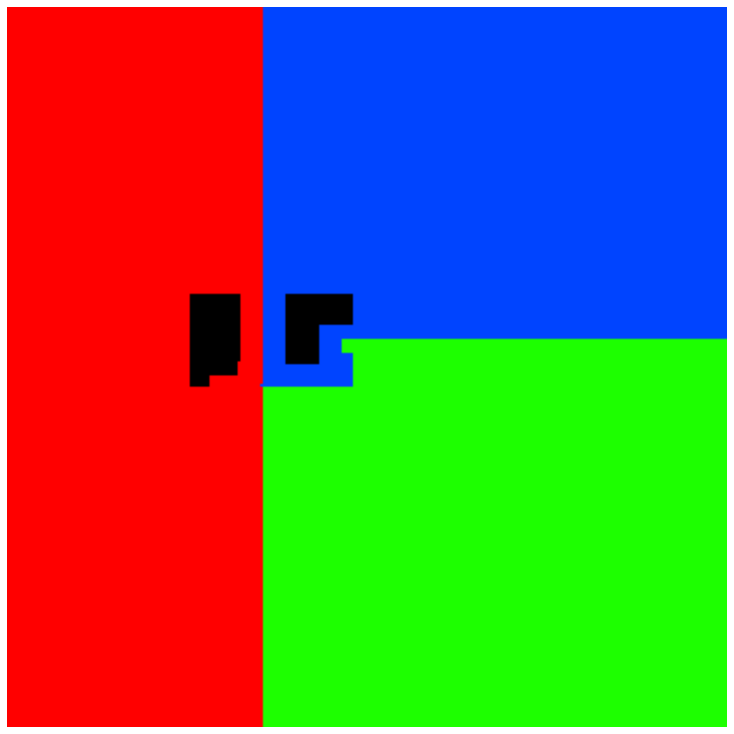

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


197
1300500
point chosen is: 135,71
0
coordinates are 4 4


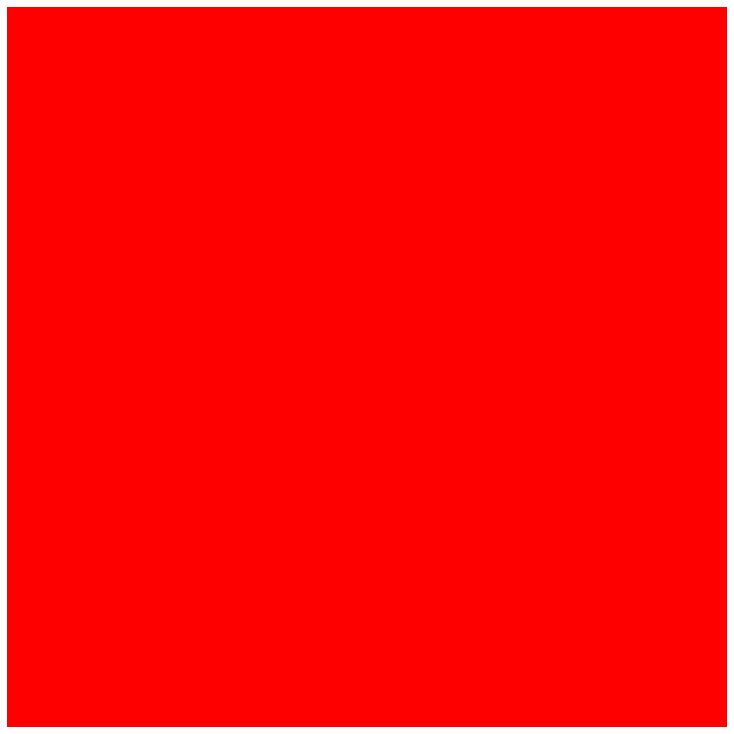

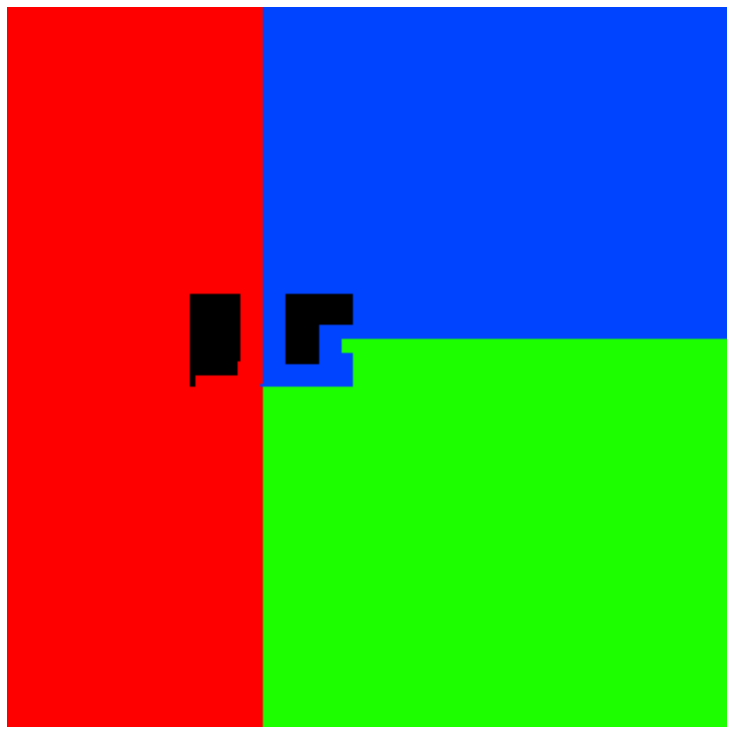

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


197
520200
point chosen is: 135,66
0
coordinates are 4 4


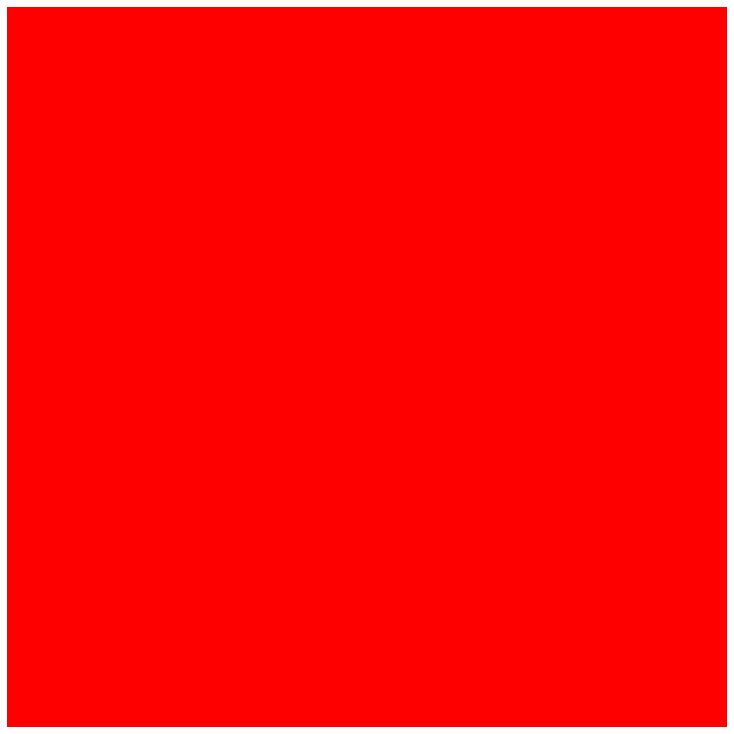

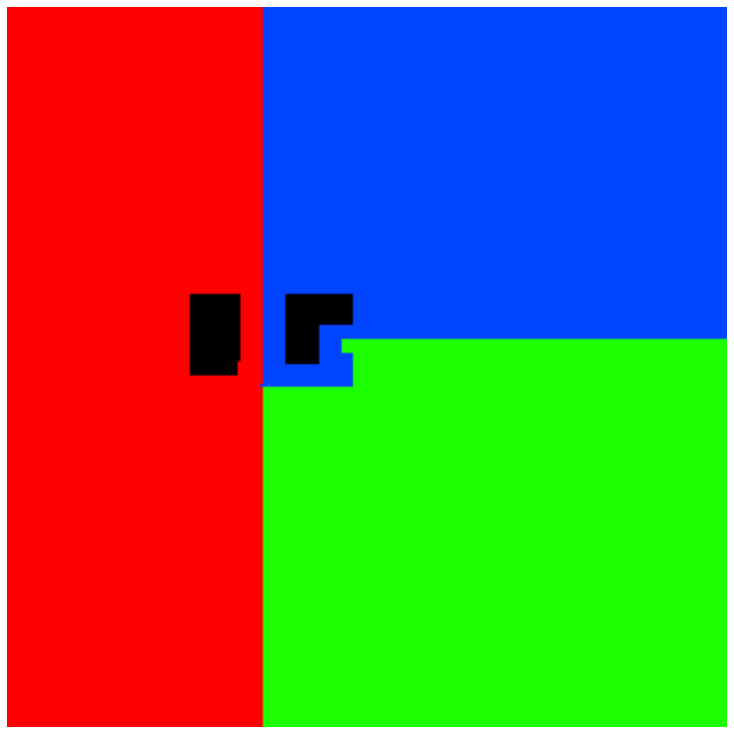

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


190
1300500
point chosen is: 131,81
0
coordinates are 4 4


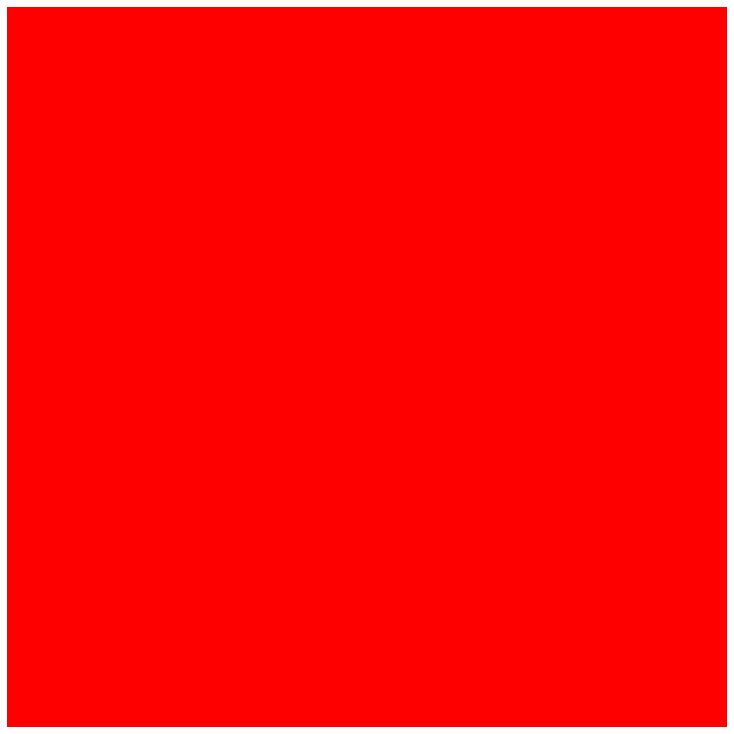

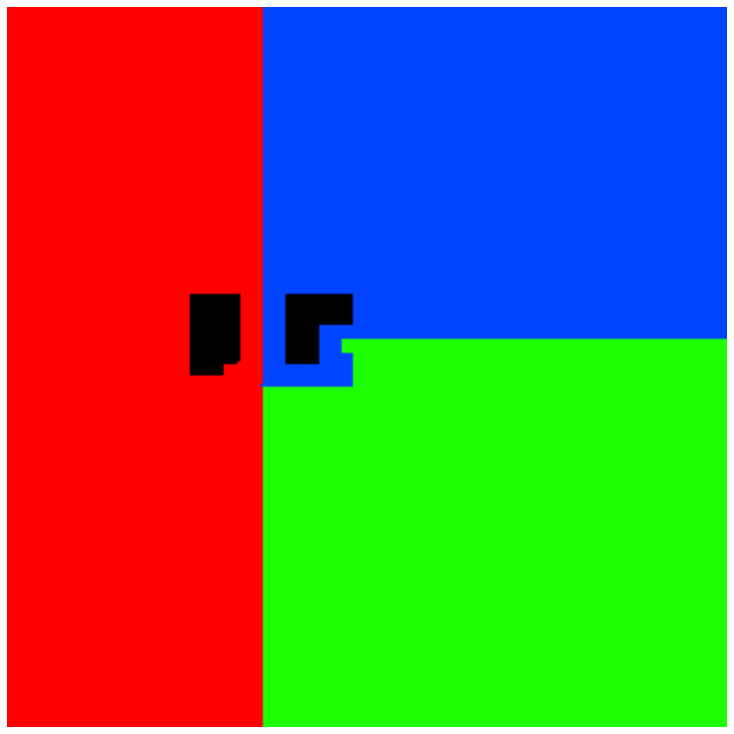

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


189
1300500
point chosen is: 131,76
0
coordinates are 4 4


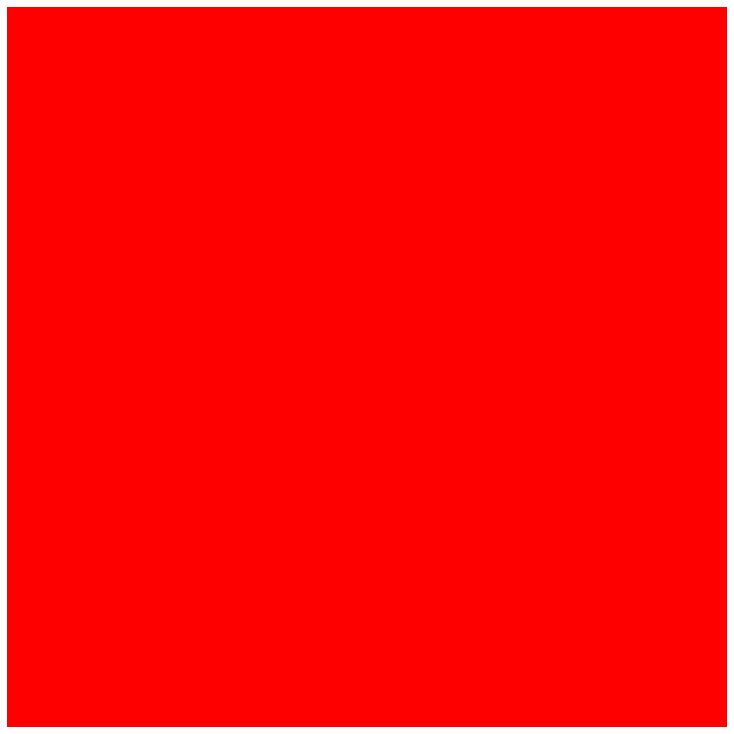

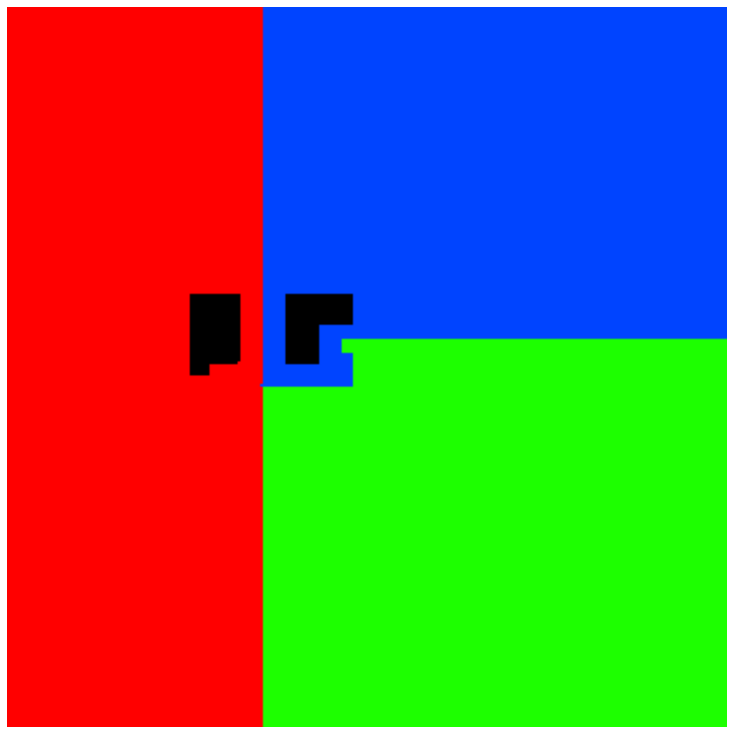

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


189
1300500
point chosen is: 131,71
0
coordinates are 4 4


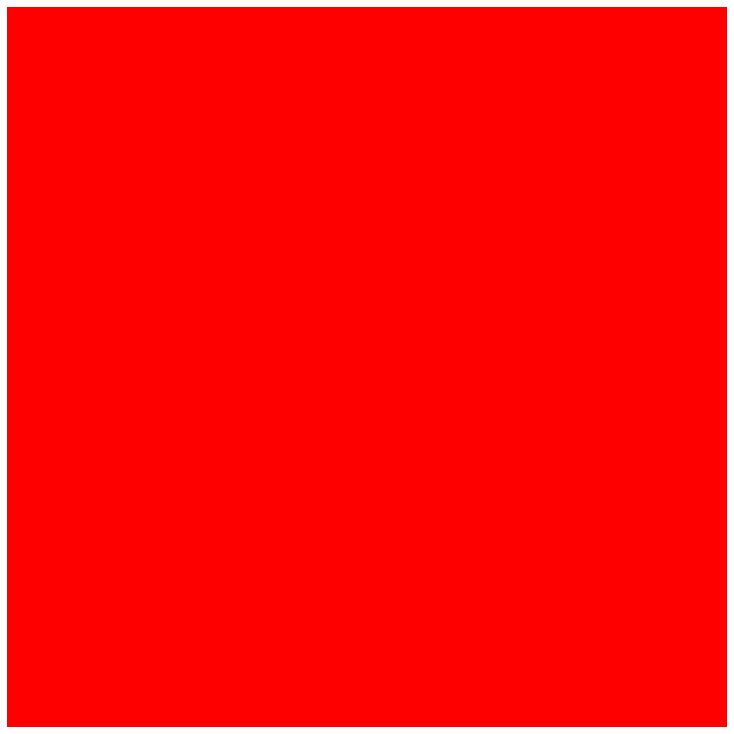

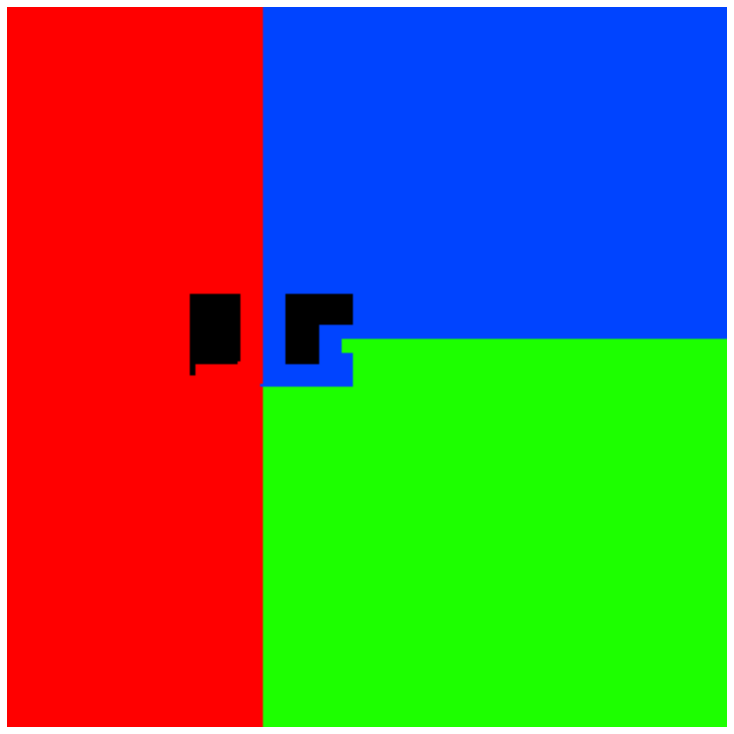

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


189
520200
point chosen is: 131,66
0
coordinates are 4 4


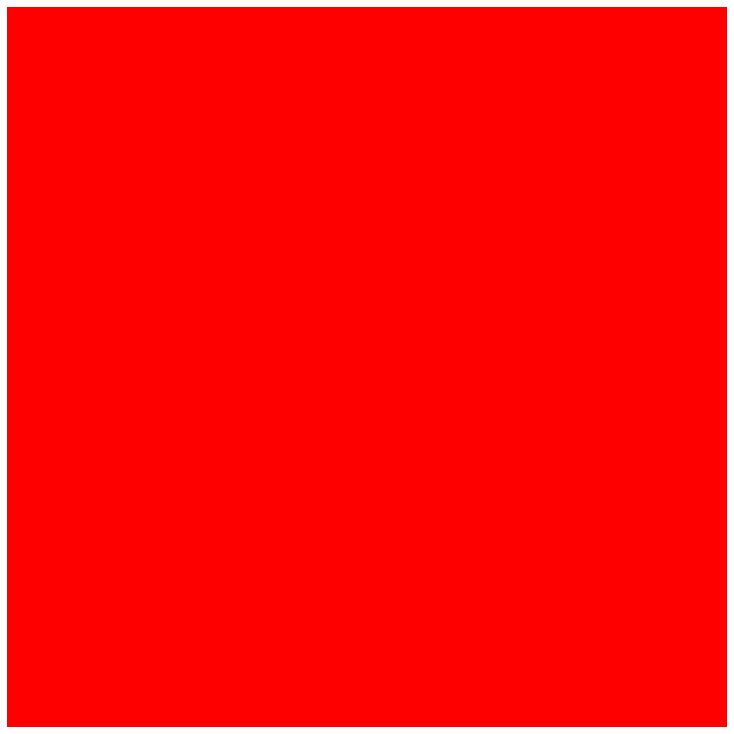

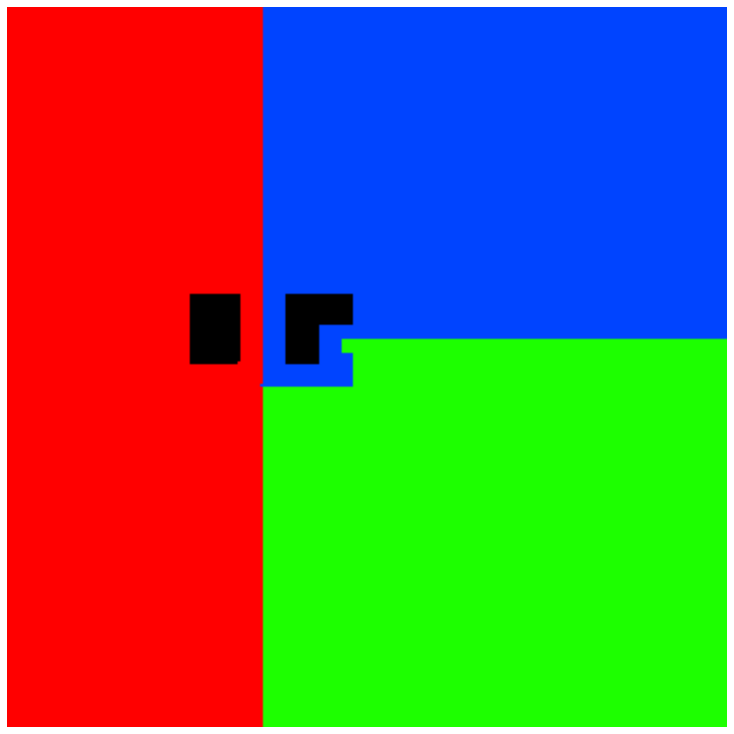

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


182
9515614
point chosen is: 127,110
8215114
coordinates are 4 4
7003048
coordinates are 4 87
5790982
coordinates are 4 88
4578916
coordinates are 4 89
3366850
coordinates are 4 90
2693480
coordinates are 4 91
2020110
coordinates are 4 92
1346740
coordinates are 4 93
673370
coordinates are 4 94
0
coordinates are 4 95


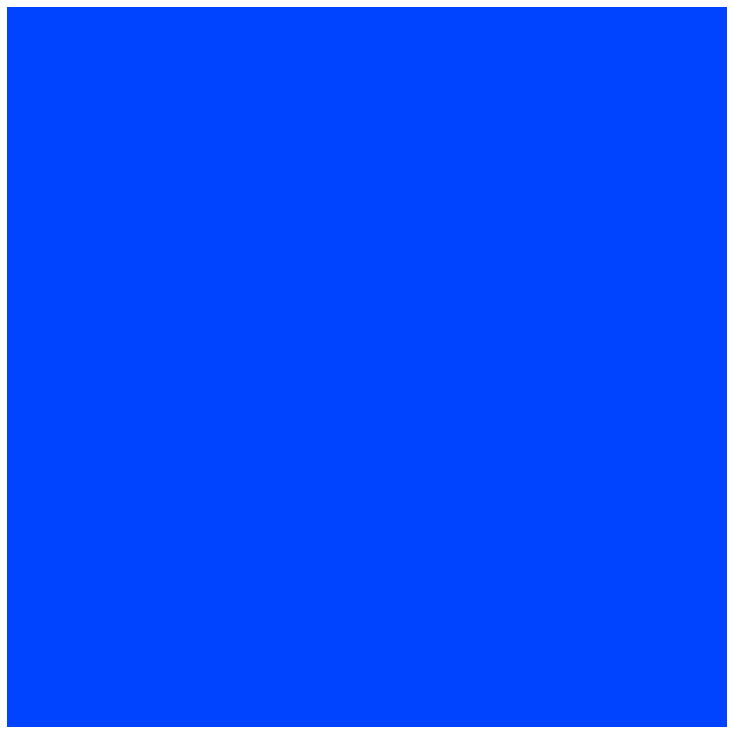

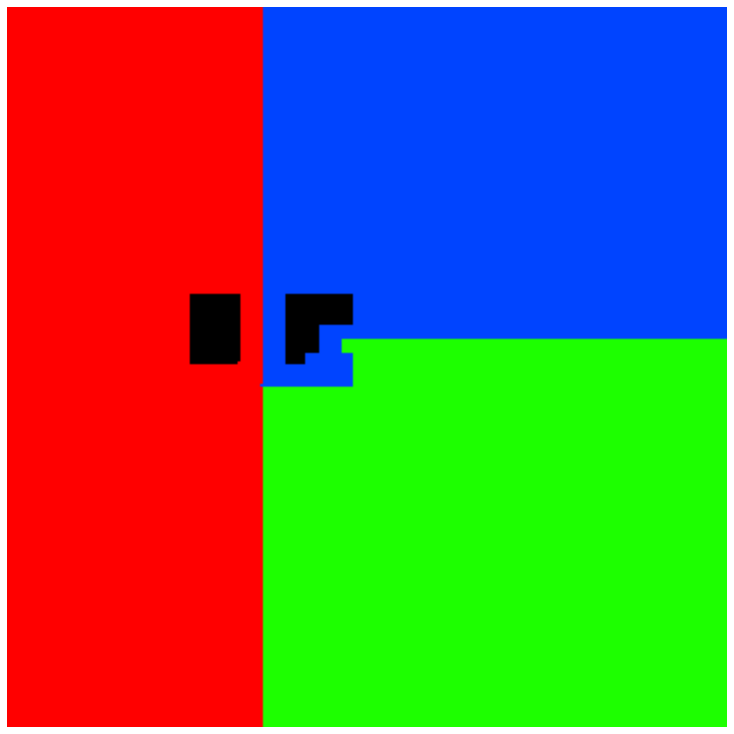

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


181
9515614
point chosen is: 127,105
8215114
coordinates are 4 4
7003048
coordinates are 4 87
5790982
coordinates are 4 88
4578916
coordinates are 4 89
3366850
coordinates are 4 90
2693480
coordinates are 4 91
2020110
coordinates are 4 92
1346740
coordinates are 4 93
673370
coordinates are 4 94
0
coordinates are 4 95


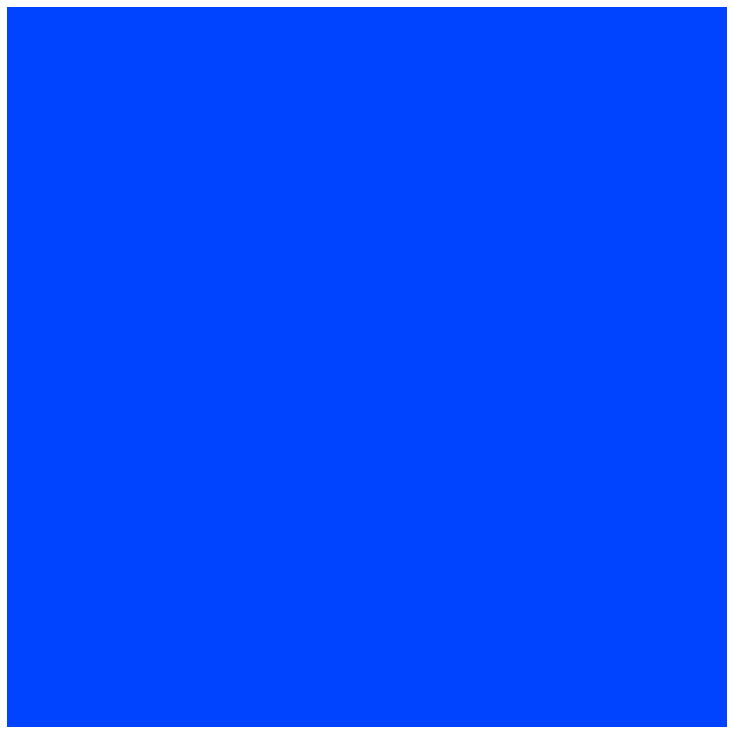

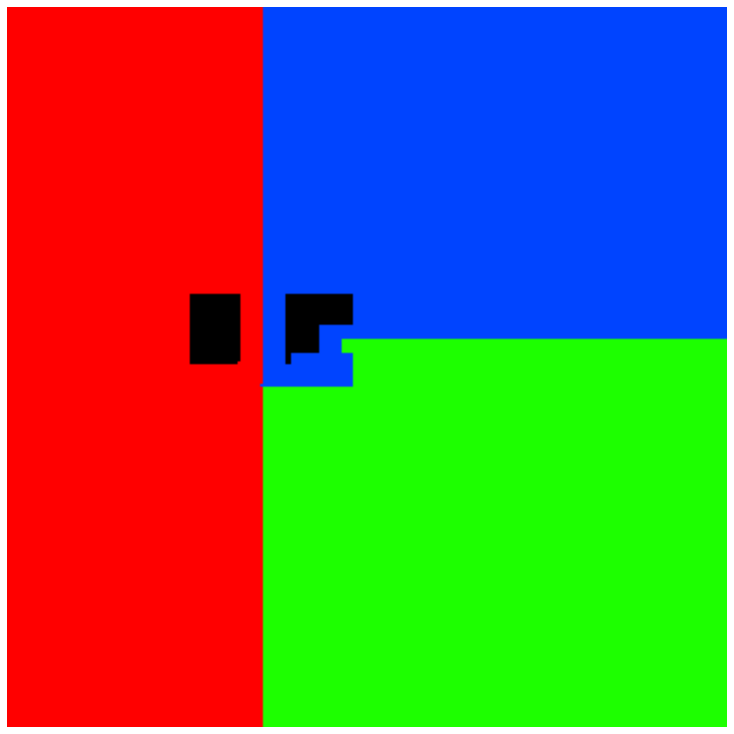

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


181
10351402
point chosen is: 127,100
9831202
coordinates are 4 4
8619136
coordinates are 4 87
7407070
coordinates are 4 88
6195004
coordinates are 4 89
4982938
coordinates are 4 90
4309568
coordinates are 4 91
3636198
coordinates are 4 92
2424132
coordinates are 4 93
1212066
coordinates are 4 94
0
coordinates are 4 95


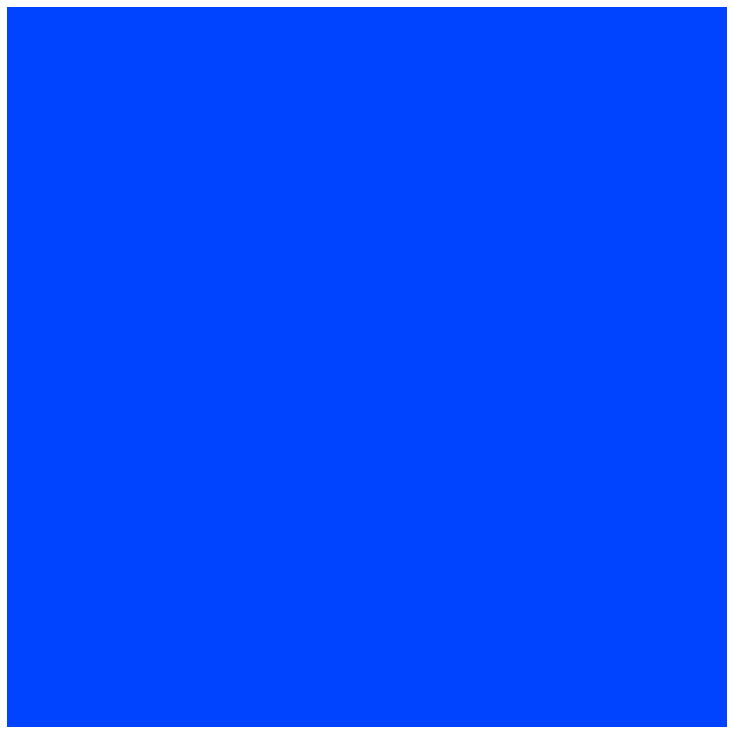

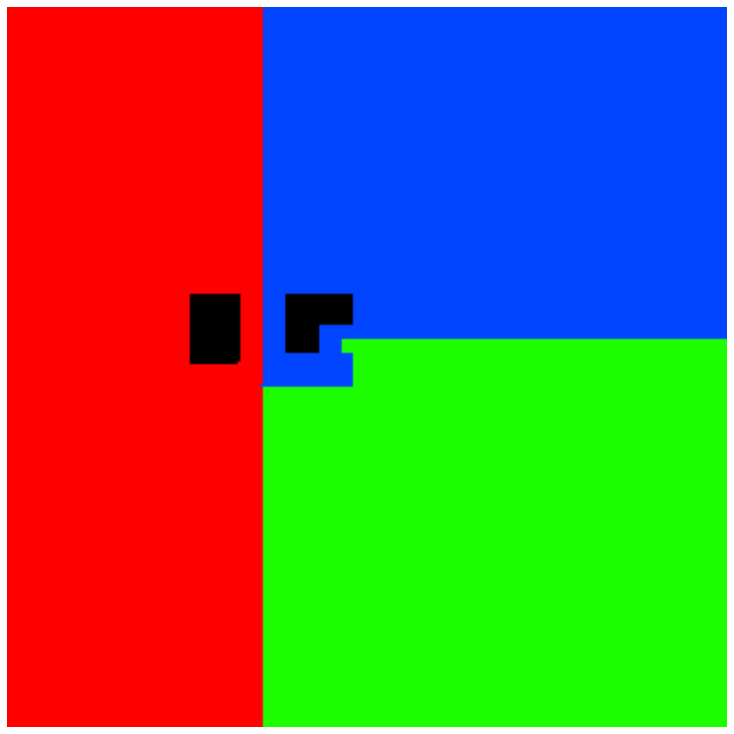

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


174
1495575
point chosen is: 127,81
0
coordinates are 4 4


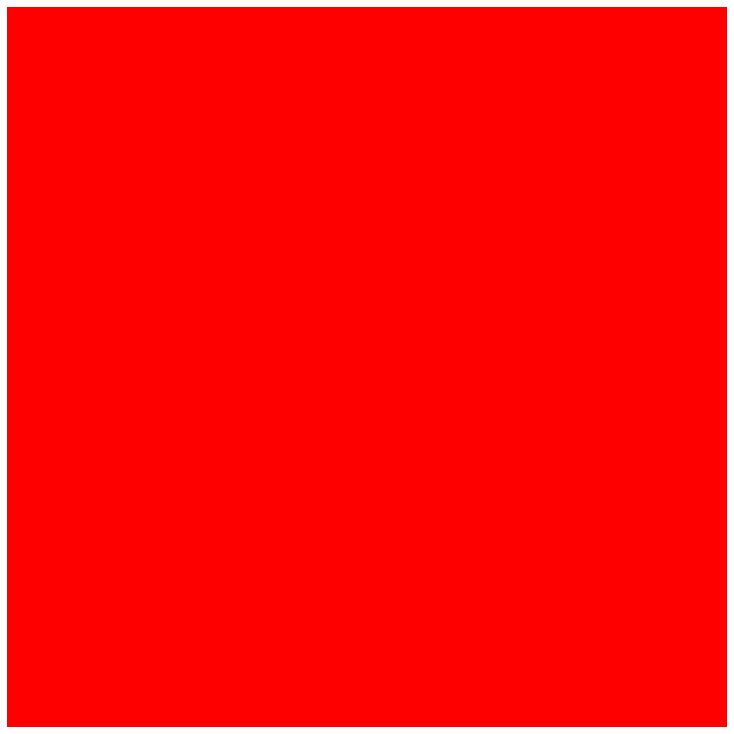

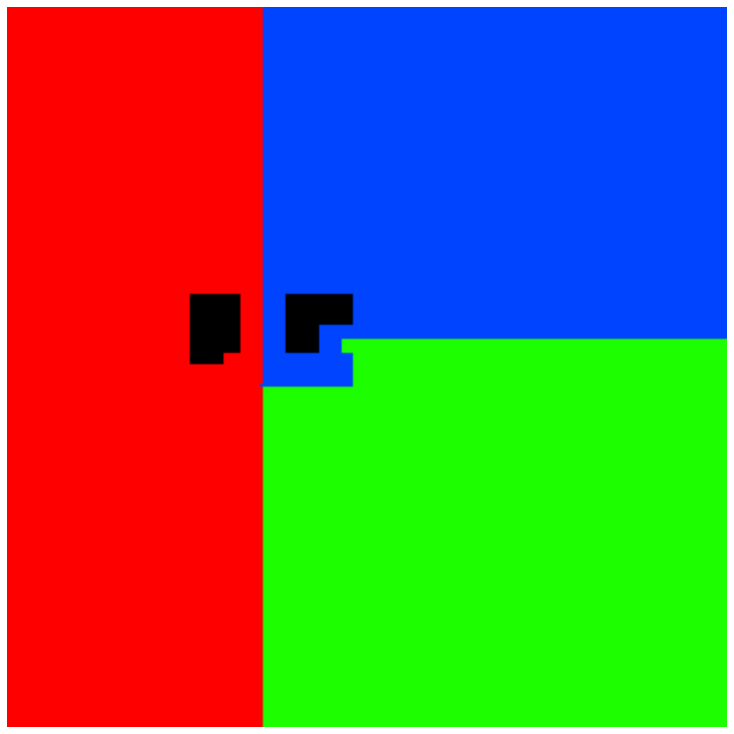

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


174
1300500
point chosen is: 127,76
0
coordinates are 4 4


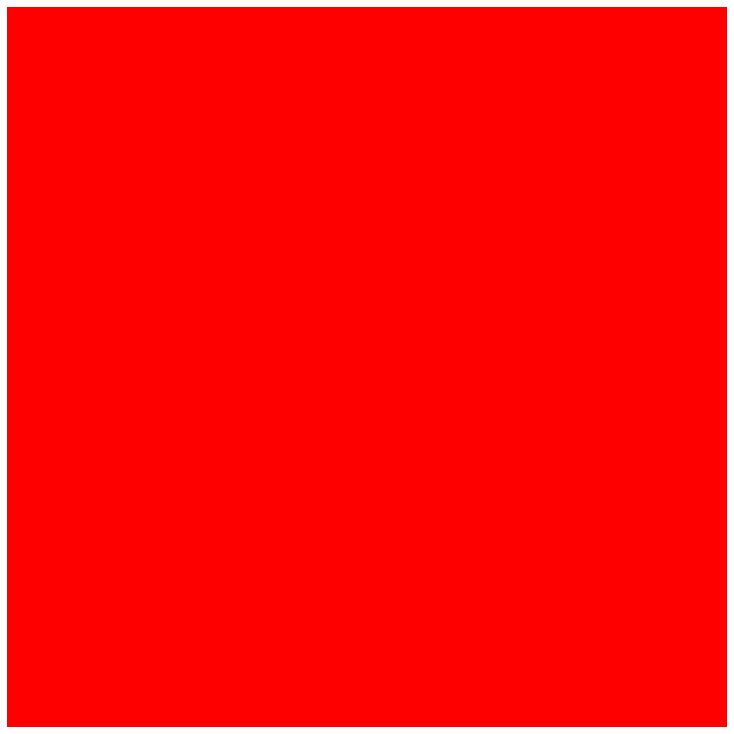

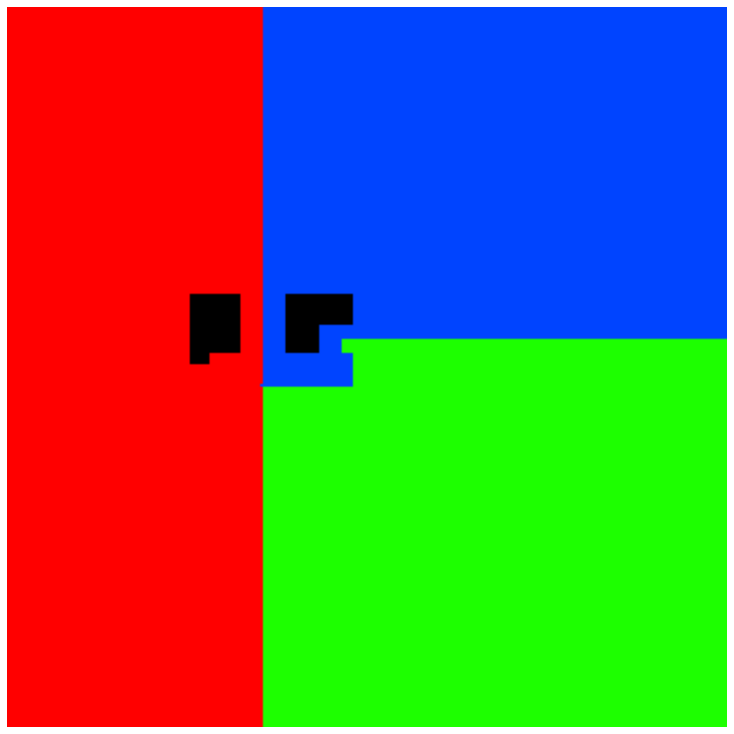

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


174
1300500
point chosen is: 127,71
0
coordinates are 4 4


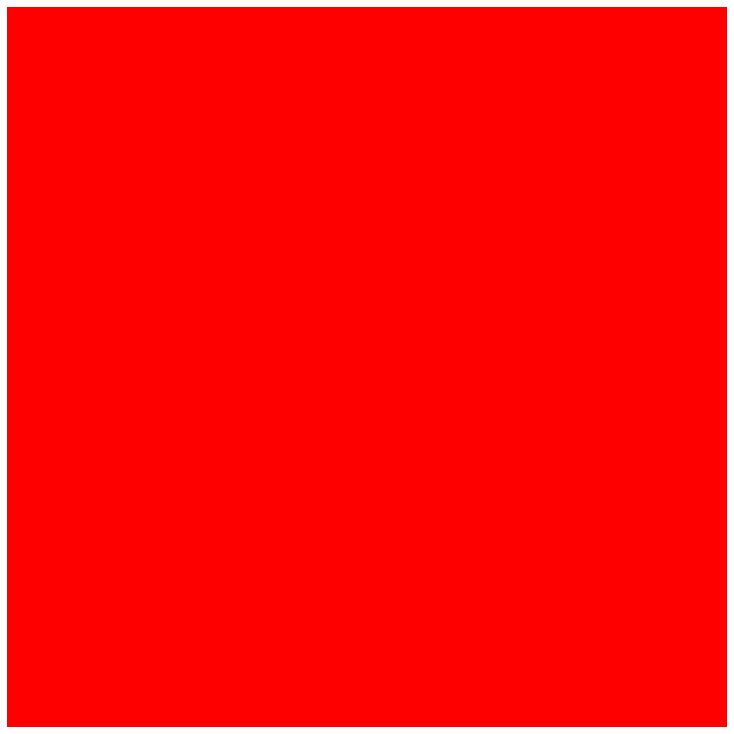

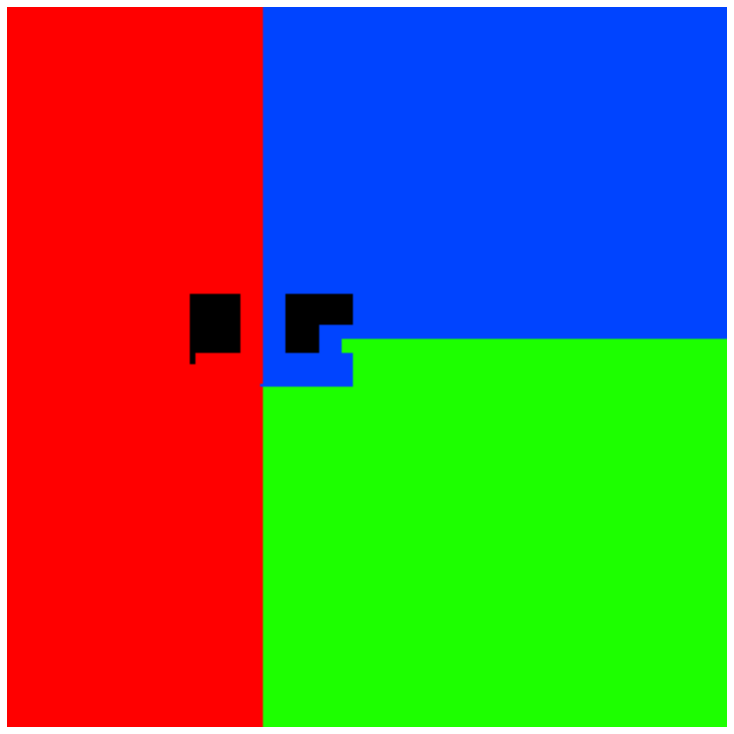

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


174
520200
point chosen is: 127,66
0
coordinates are 4 4


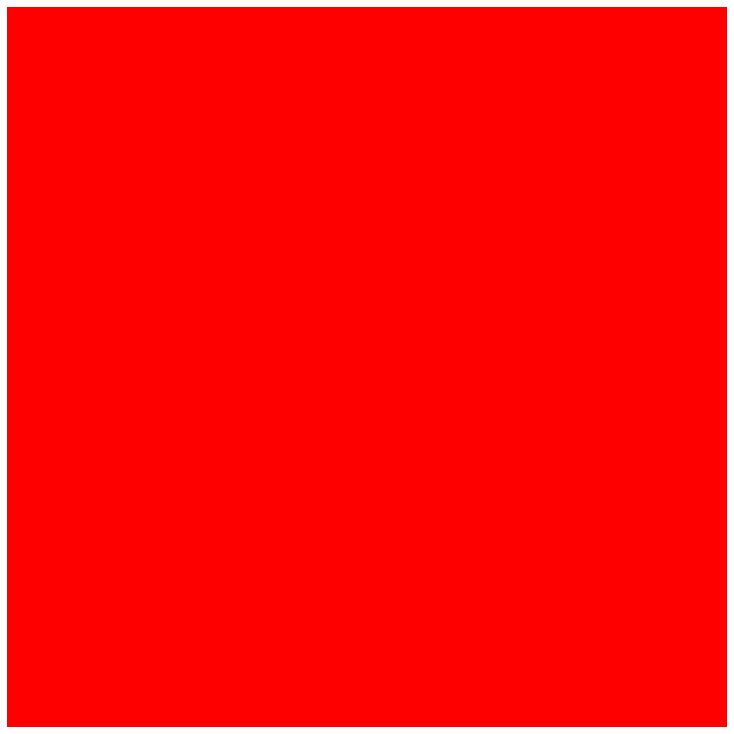

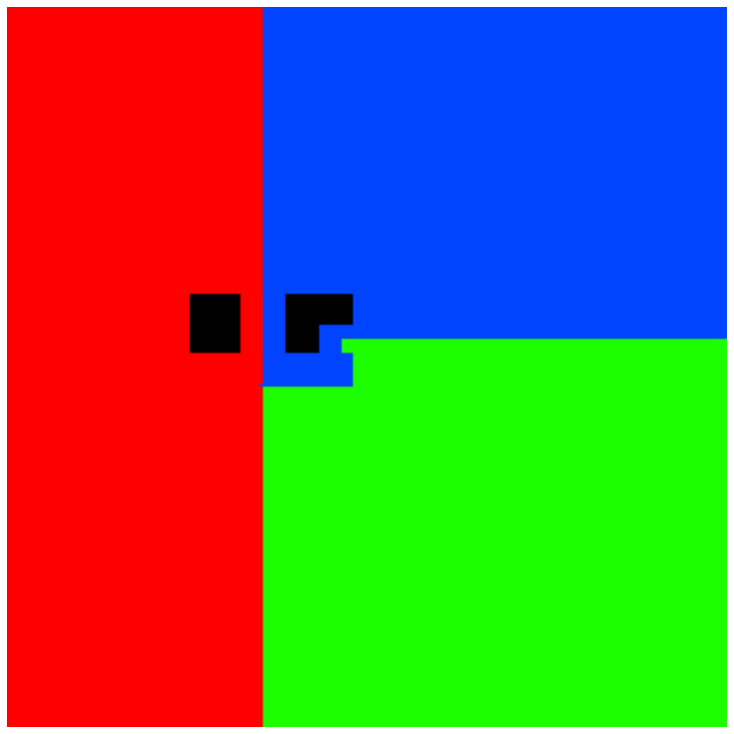

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


167
9515614
point chosen is: 123,110
8215114
coordinates are 4 4
7003048
coordinates are 4 87
5790982
coordinates are 4 88
4578916
coordinates are 4 89
3366850
coordinates are 4 90
2693480
coordinates are 4 91
2020110
coordinates are 4 92
1346740
coordinates are 4 93
673370
coordinates are 4 94
0
coordinates are 4 95


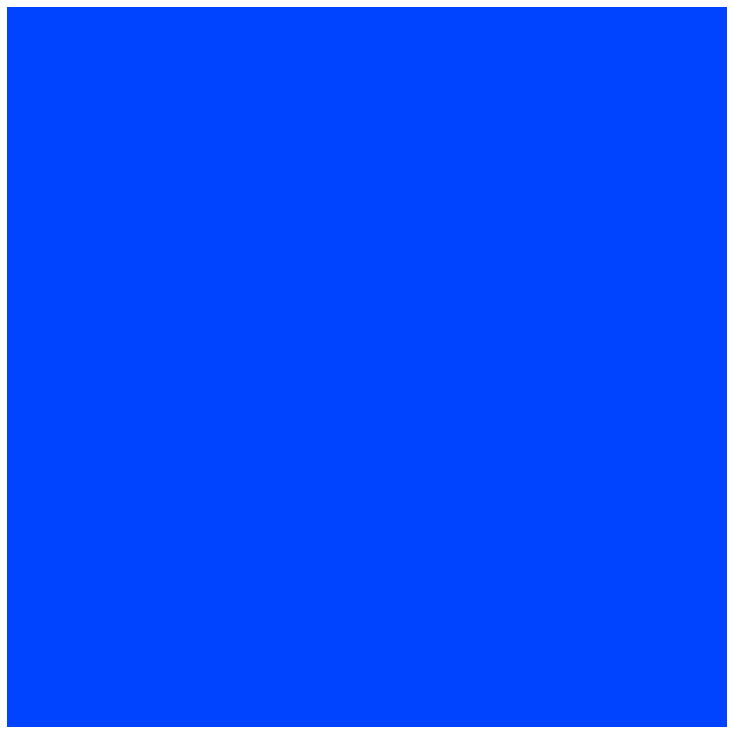

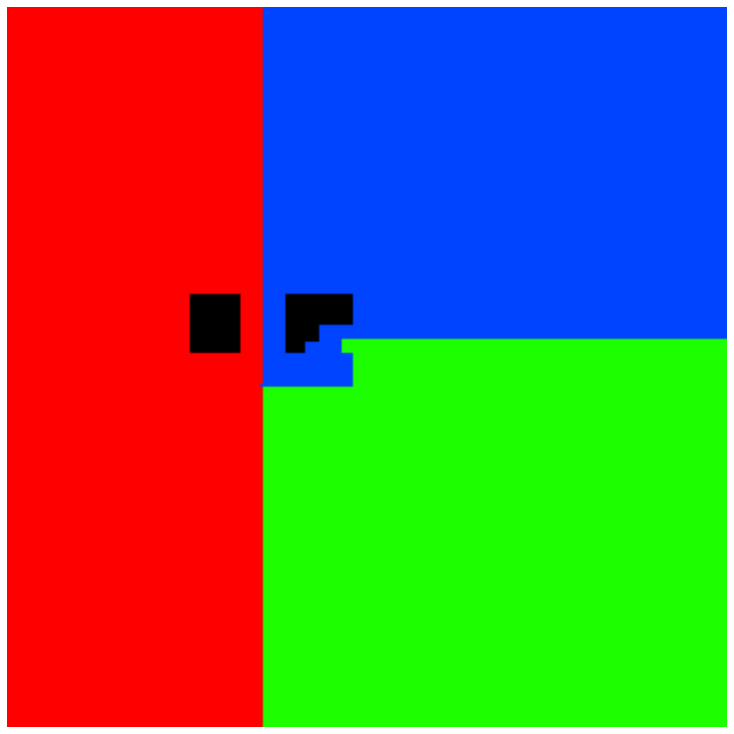

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


166
9515614
point chosen is: 123,105
8215114
coordinates are 4 4
7003048
coordinates are 4 87
5790982
coordinates are 4 88
4578916
coordinates are 4 89
3366850
coordinates are 4 90
2693480
coordinates are 4 91
2020110
coordinates are 4 92
1346740
coordinates are 4 93
673370
coordinates are 4 94
0
coordinates are 4 95


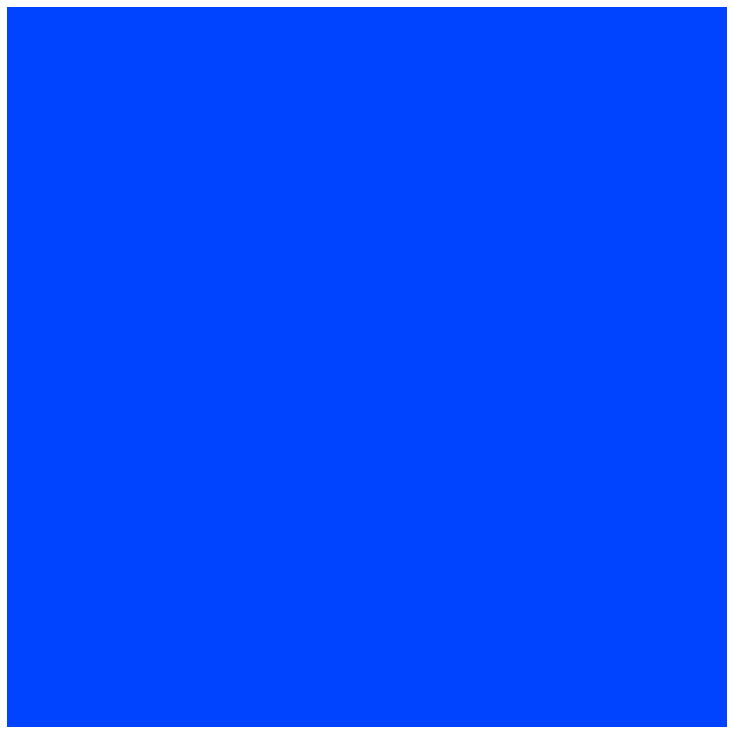

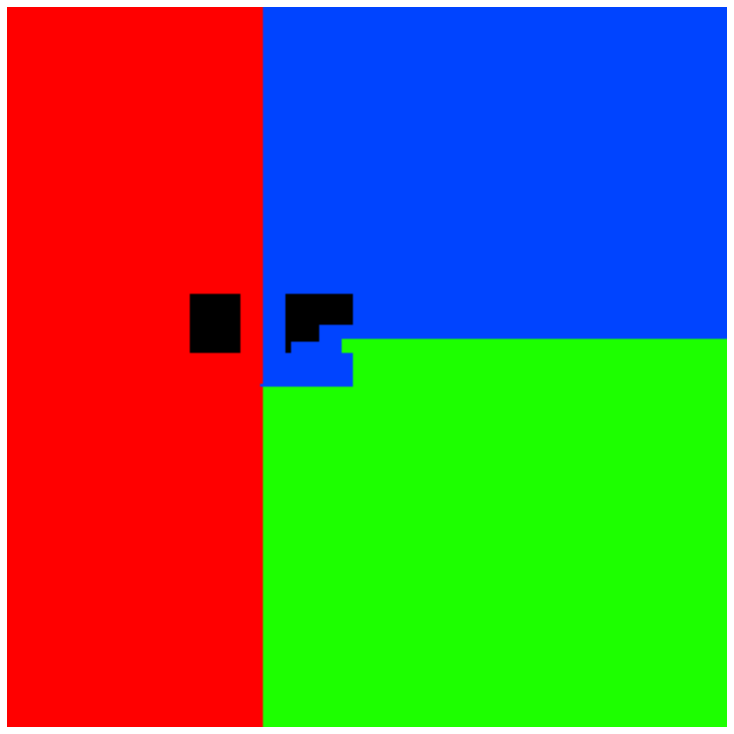

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


166
10351402
point chosen is: 123,100
9831202
coordinates are 4 4
8619136
coordinates are 4 87
7407070
coordinates are 4 88
6195004
coordinates are 4 89
4982938
coordinates are 4 90
4309568
coordinates are 4 91
3636198
coordinates are 4 92
2424132
coordinates are 4 93
1212066
coordinates are 4 94
0
coordinates are 4 95


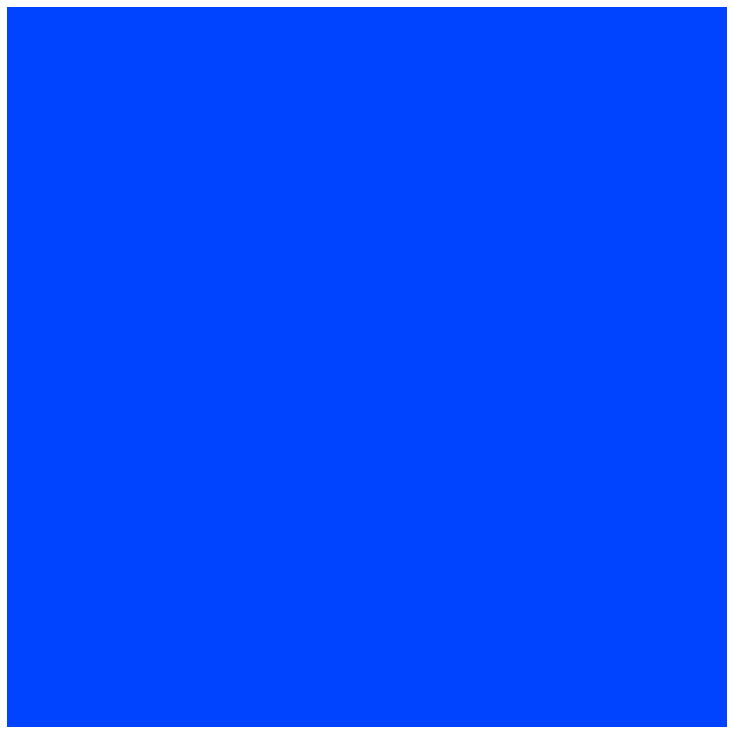

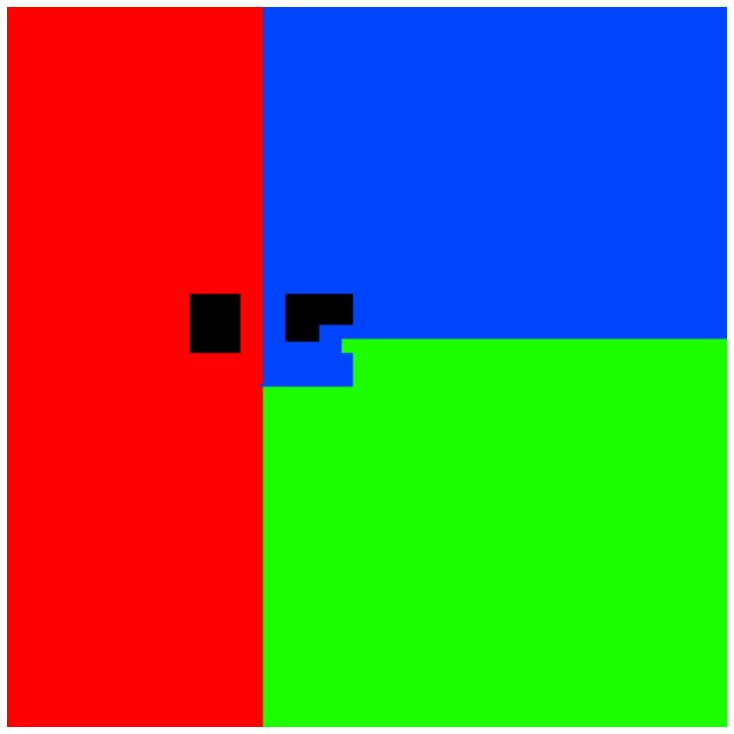

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


159
1300500
point chosen is: 123,82
0
coordinates are 4 4


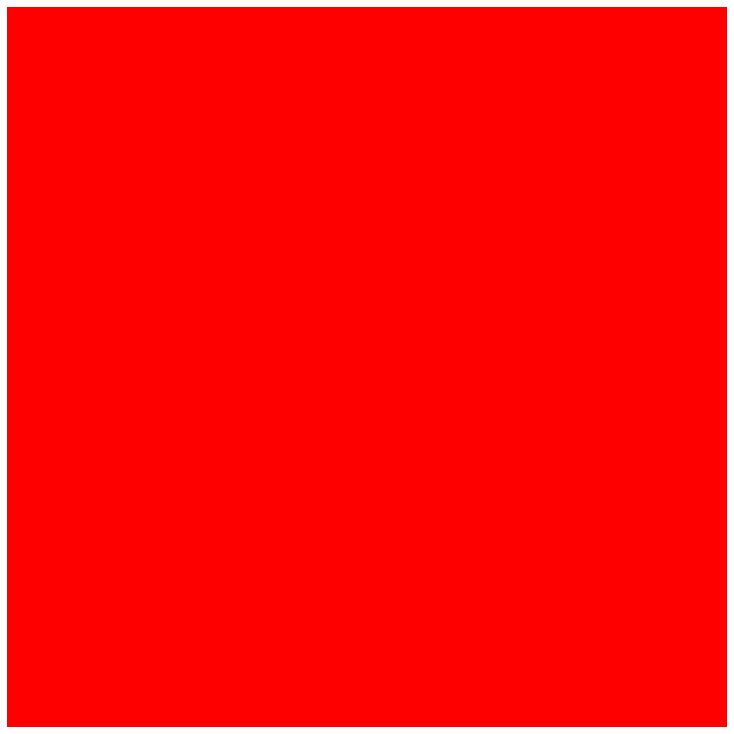

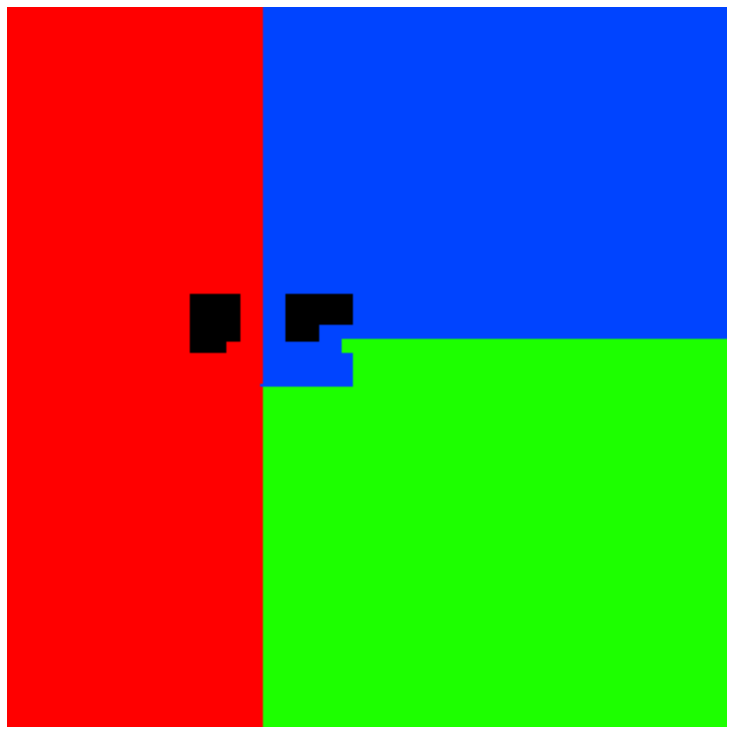

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


158
1300500
point chosen is: 123,77
0
coordinates are 4 4


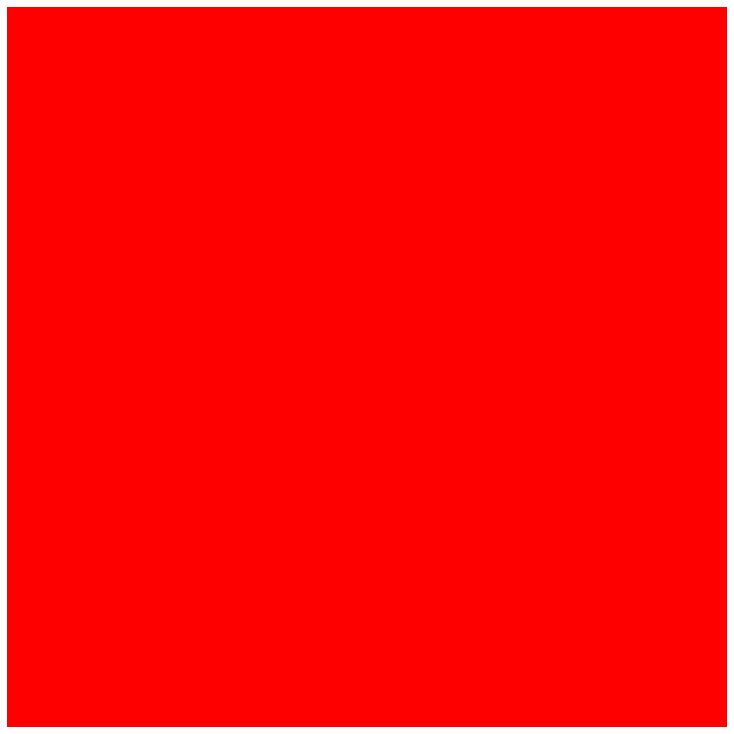

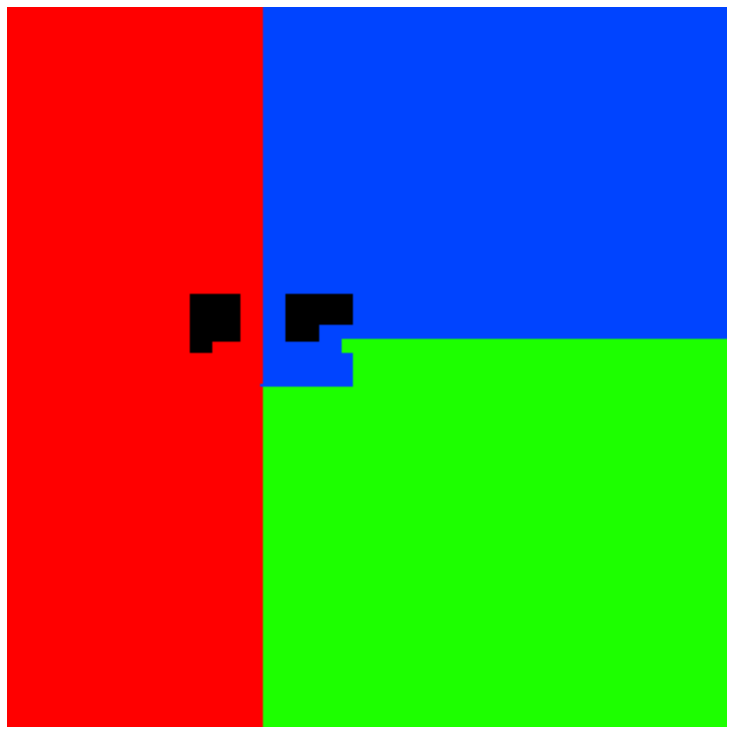

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


158
1300500
point chosen is: 123,72
0
coordinates are 4 4


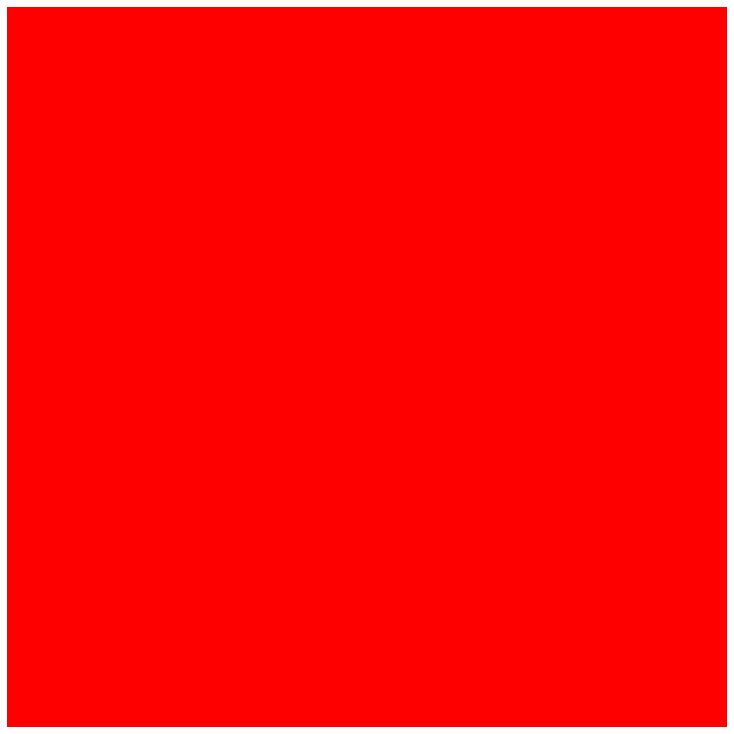

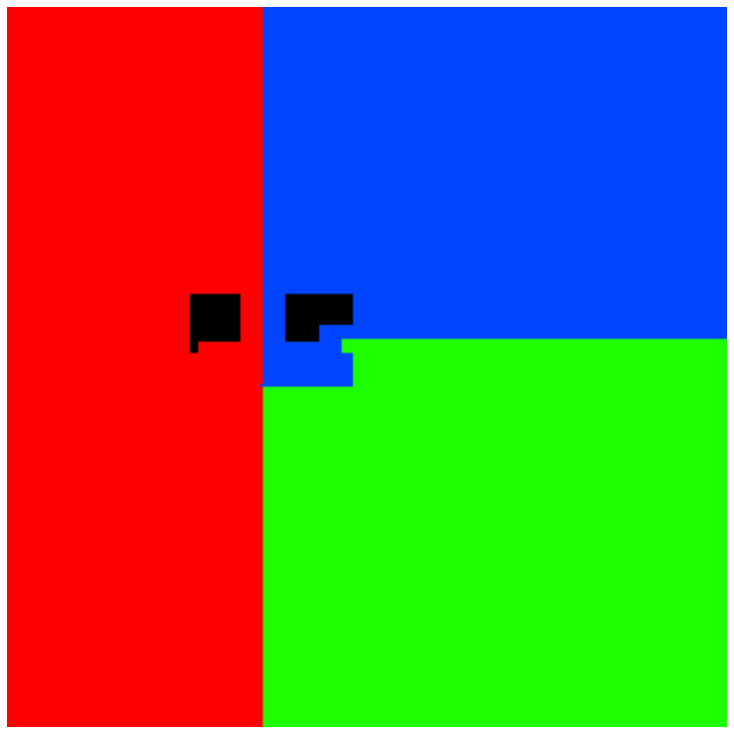

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


158
780300
point chosen is: 123,67
0
coordinates are 4 4


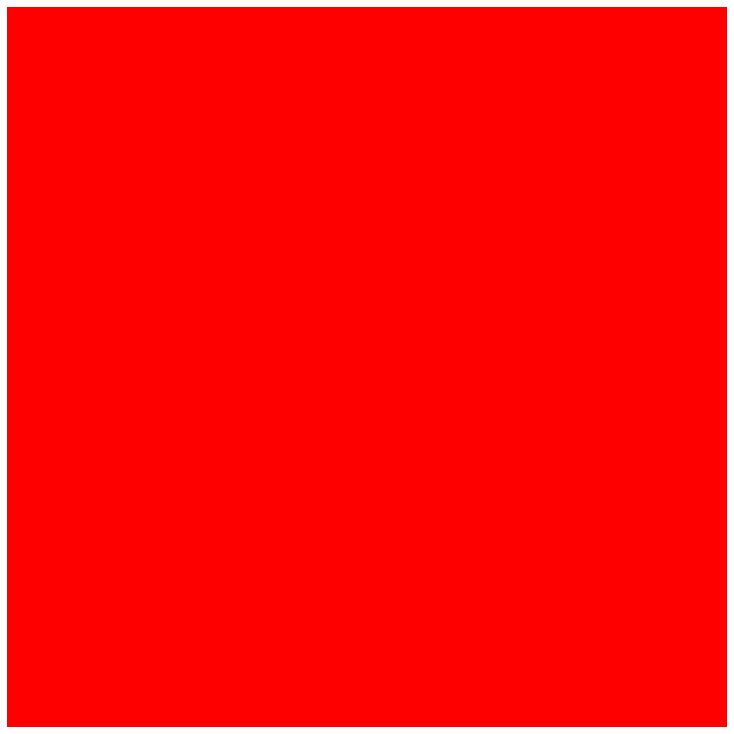

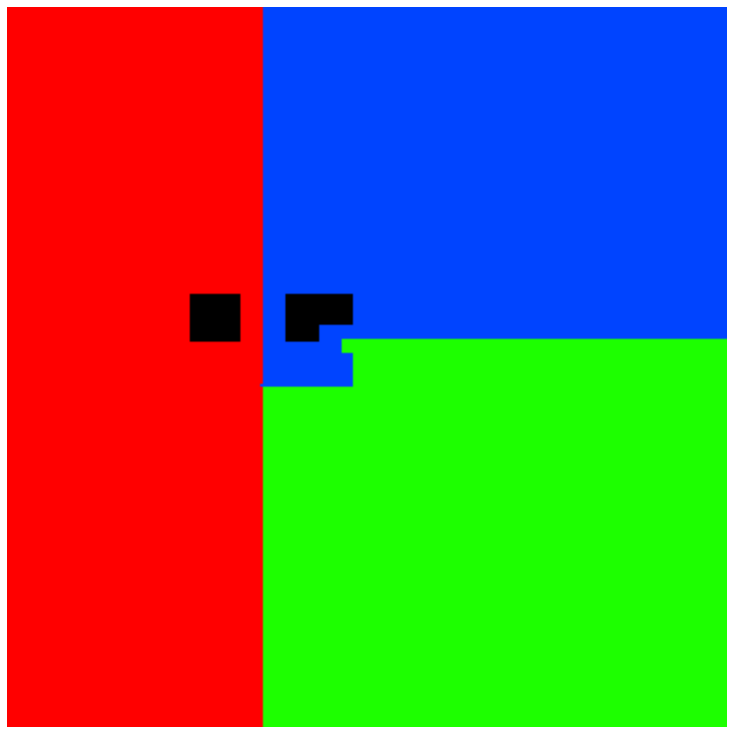

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


151
9515614
point chosen is: 119,110
8215114
coordinates are 4 4
7003048
coordinates are 4 87
5790982
coordinates are 4 88
4578916
coordinates are 4 89
3366850
coordinates are 4 90
2693480
coordinates are 4 91
2020110
coordinates are 4 92
1346740
coordinates are 4 93
673370
coordinates are 4 94
0
coordinates are 4 95


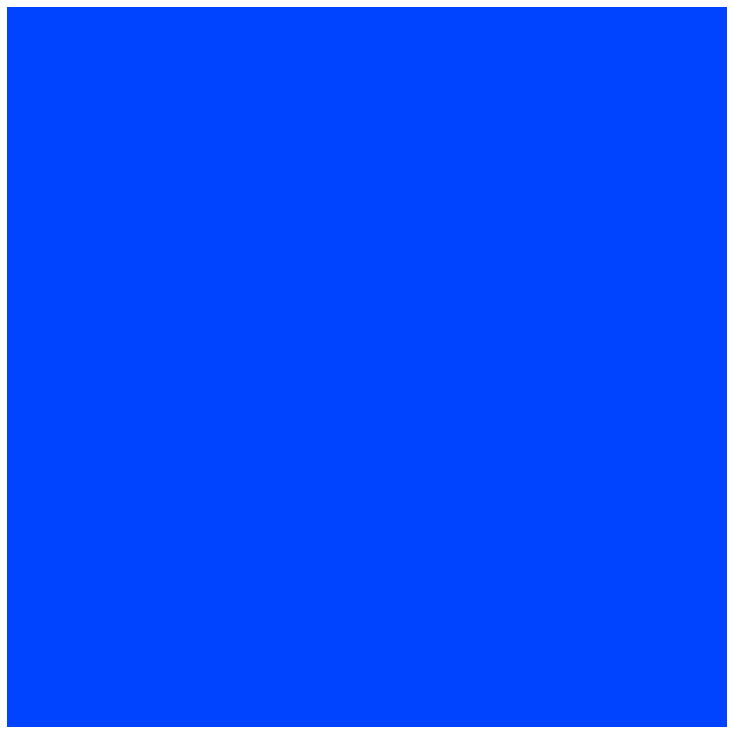

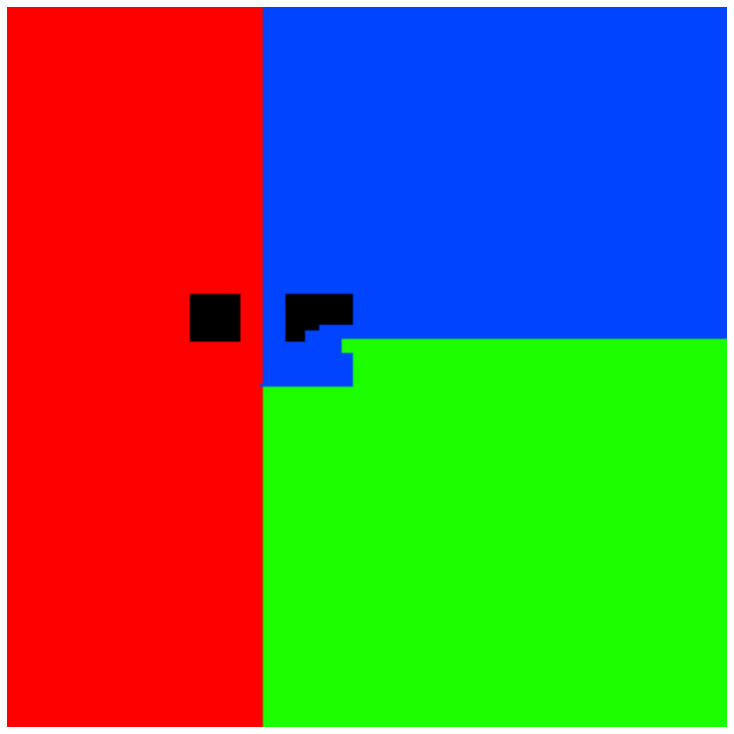

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


150
9515614
point chosen is: 119,105
8215114
coordinates are 4 4
7003048
coordinates are 4 87
5790982
coordinates are 4 88
4578916
coordinates are 4 89
3366850
coordinates are 4 90
2693480
coordinates are 4 91
2020110
coordinates are 4 92
1346740
coordinates are 4 93
673370
coordinates are 4 94
0
coordinates are 4 95


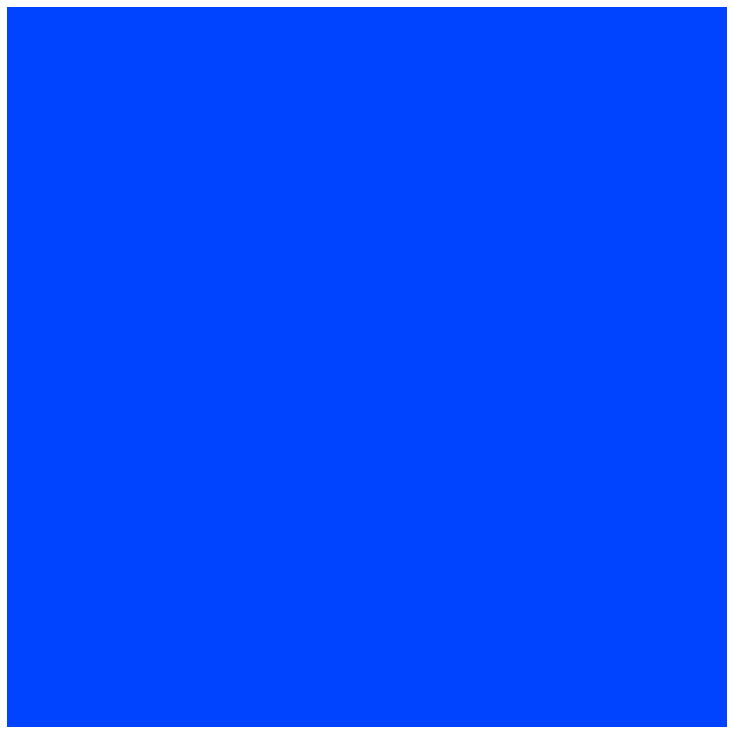

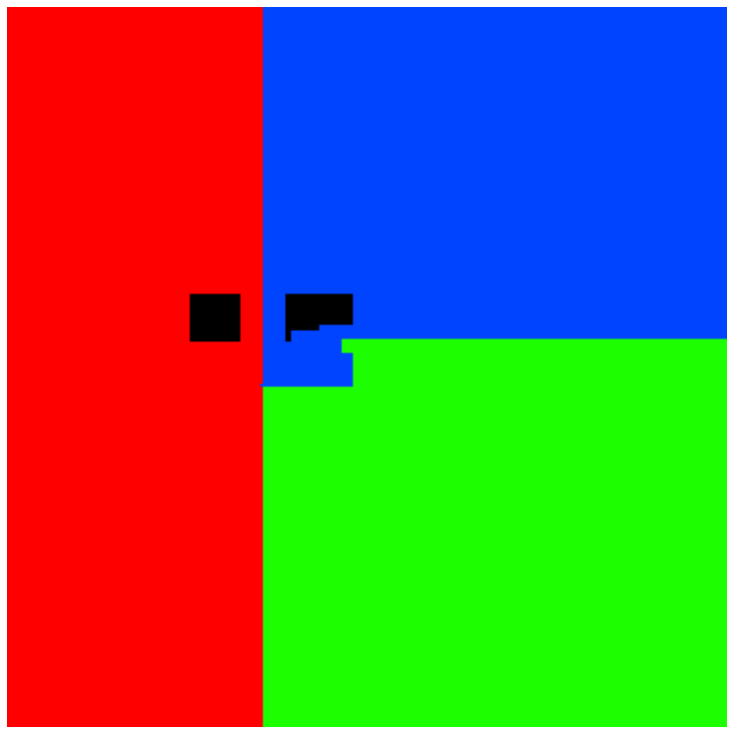

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


150
10351402
point chosen is: 119,100
9831202
coordinates are 4 4
8619136
coordinates are 4 87
7407070
coordinates are 4 88
6195004
coordinates are 4 89
4982938
coordinates are 4 90
4309568
coordinates are 4 91
3636198
coordinates are 4 92
2424132
coordinates are 4 93
1212066
coordinates are 4 94
0
coordinates are 4 95


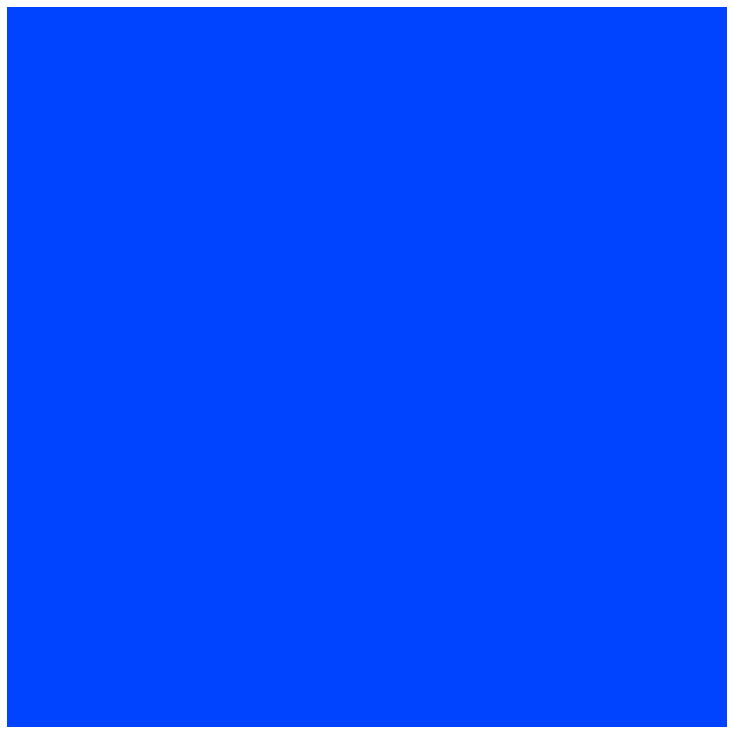

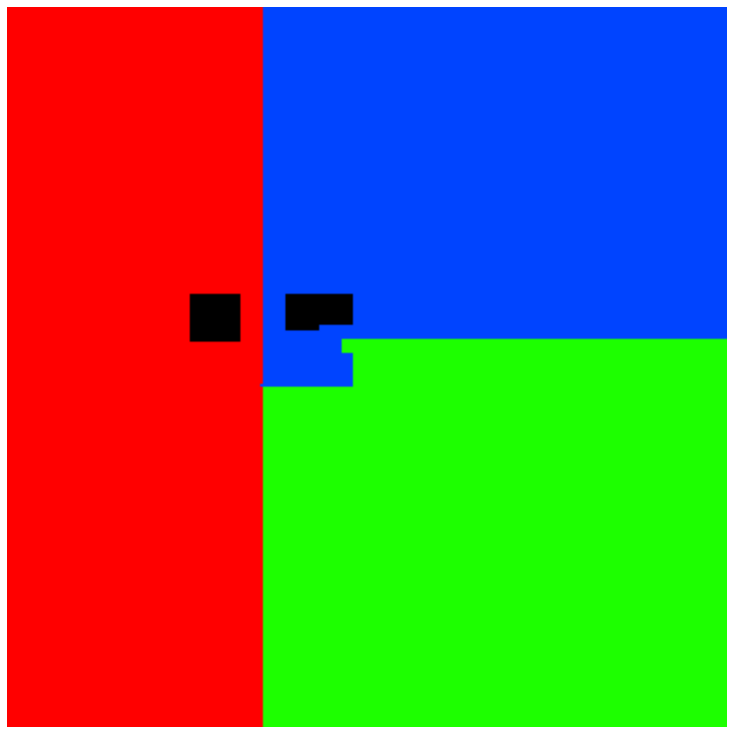

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


143
1300500
point chosen is: 119,82
0
coordinates are 4 4


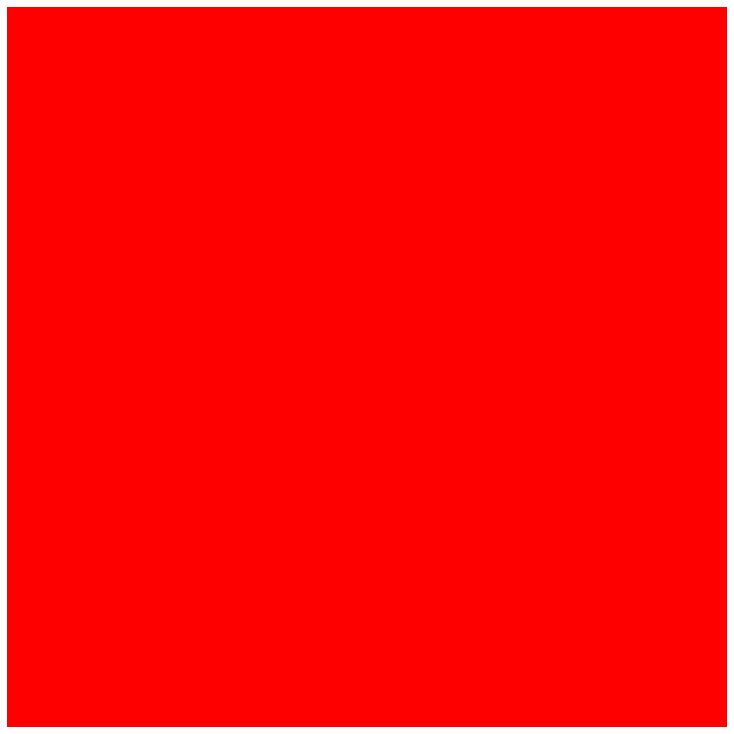

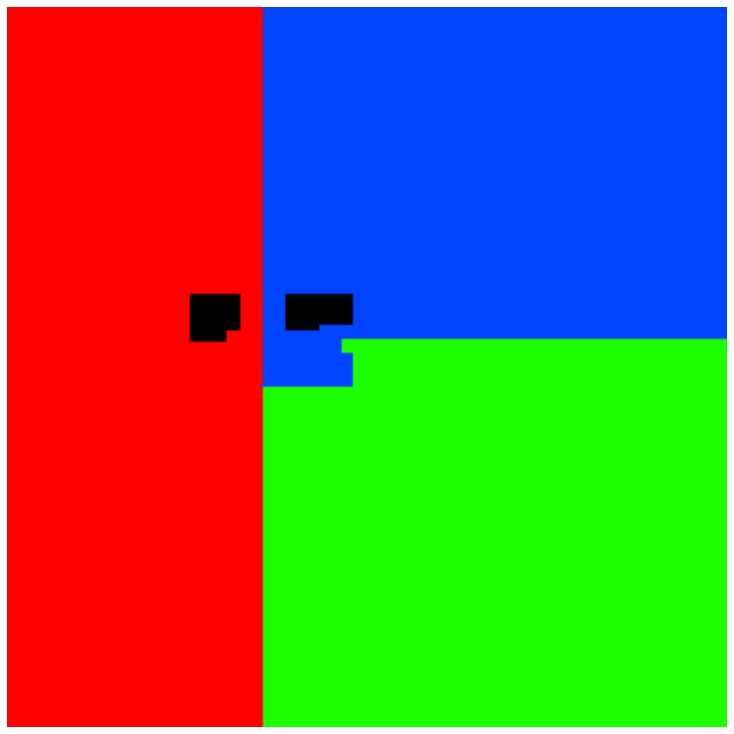

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


142
1300500
point chosen is: 119,77
0
coordinates are 4 4


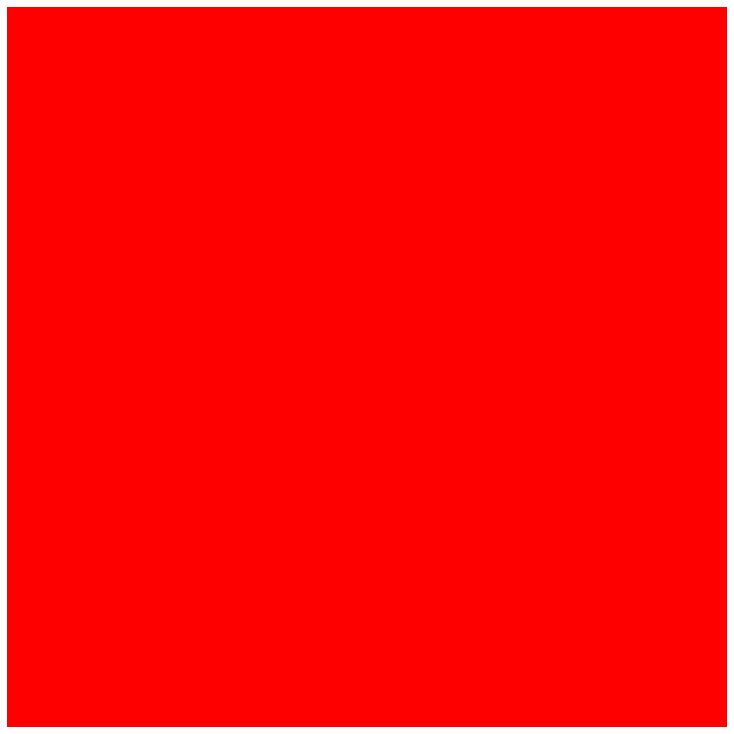

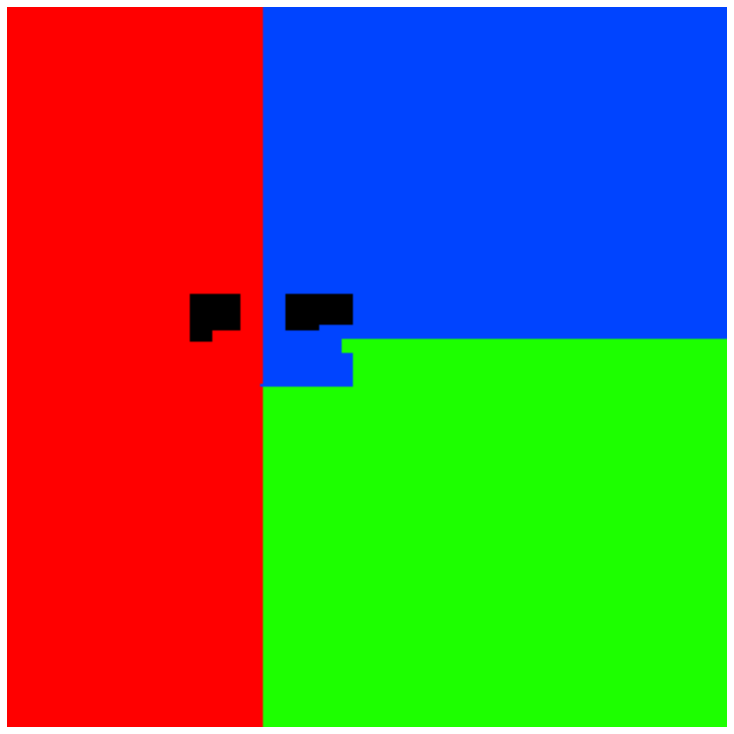

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


142
1300500
point chosen is: 119,72
0
coordinates are 4 4


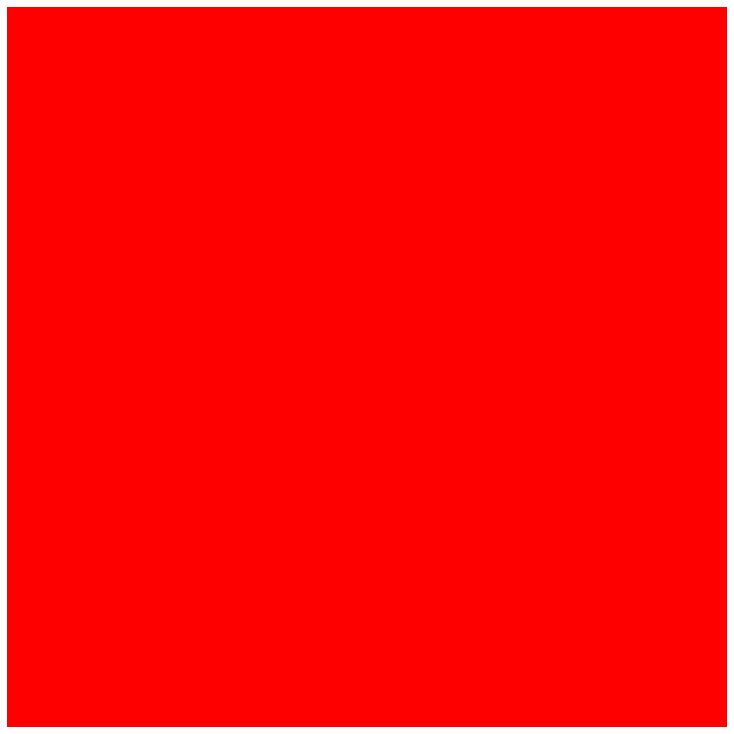

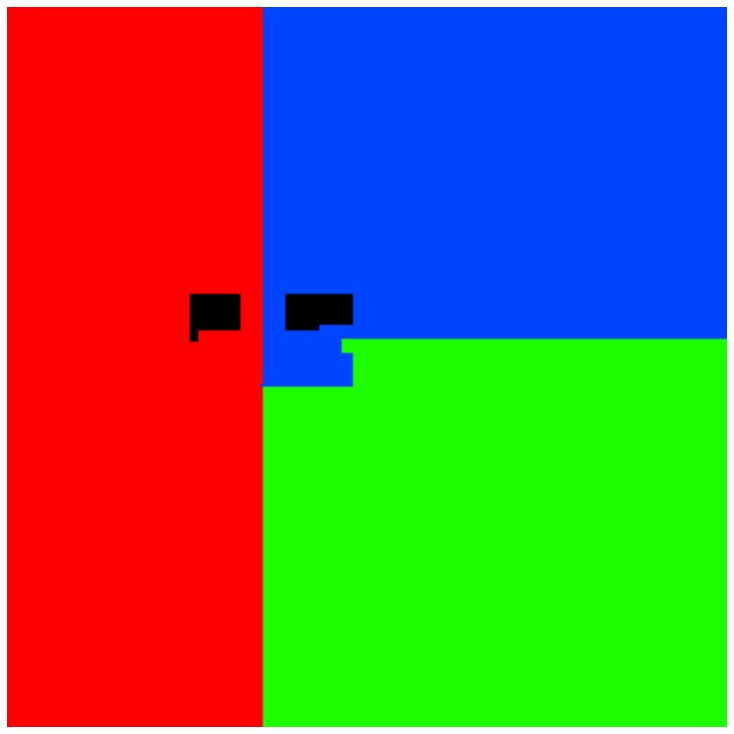

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


142
780300
point chosen is: 119,67
0
coordinates are 4 4


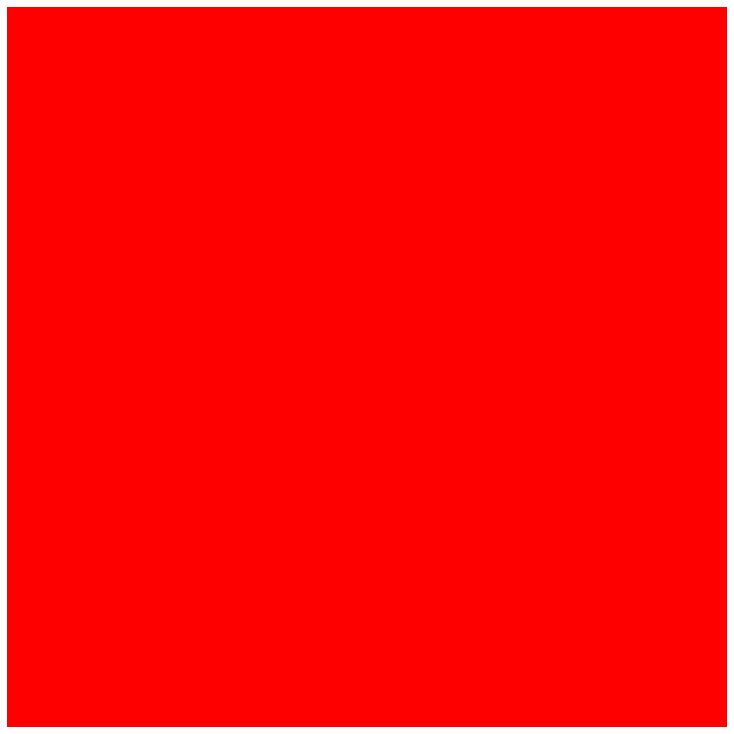

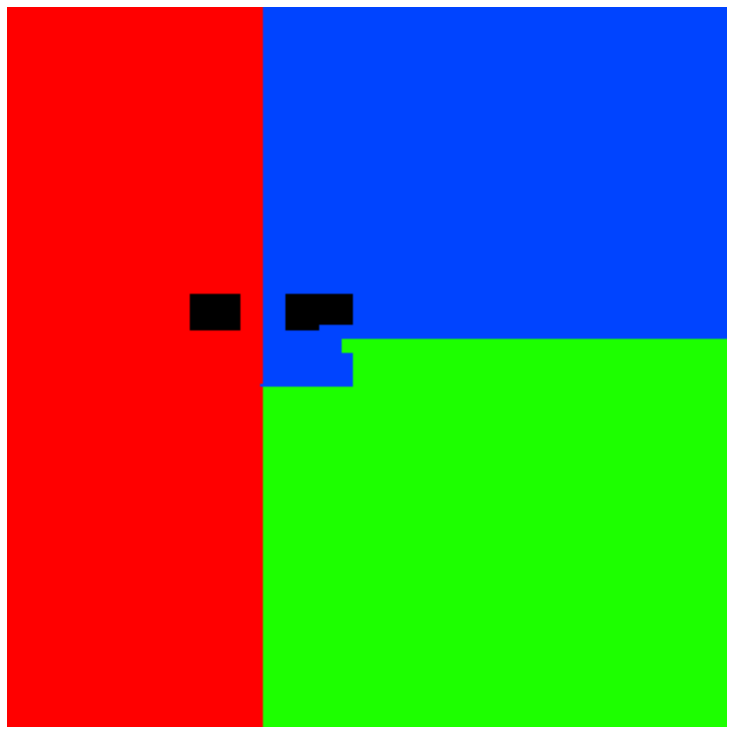

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


135
8958422
point chosen is: 115,110
7137722
coordinates are 4 4
6195004
coordinates are 4 87
5252286
coordinates are 4 88
4309568
coordinates are 4 89
3366850
coordinates are 4 90
2693480
coordinates are 4 91
2020110
coordinates are 4 92
1346740
coordinates are 4 93
673370
coordinates are 4 94
0
coordinates are 4 95


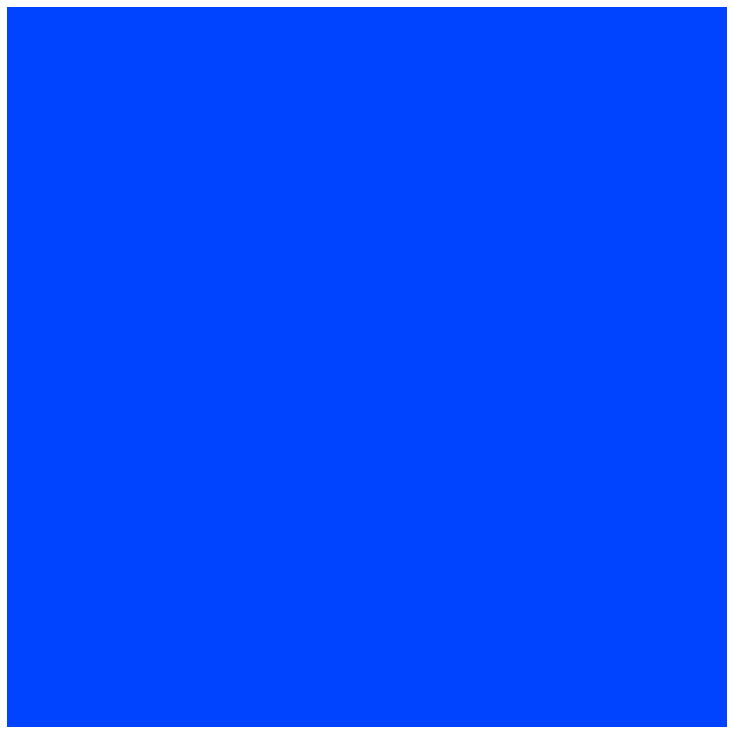

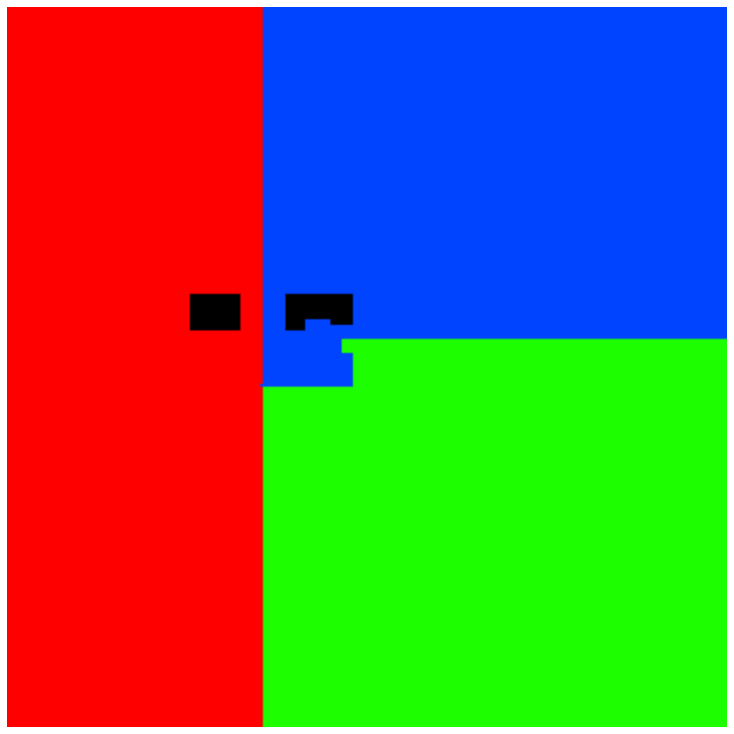

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


138
9515614
point chosen is: 115,105
8215114
coordinates are 4 4
7003048
coordinates are 4 87
5790982
coordinates are 4 88
4578916
coordinates are 4 89
3366850
coordinates are 4 90
2693480
coordinates are 4 91
2020110
coordinates are 4 92
1346740
coordinates are 4 93
673370
coordinates are 4 94
0
coordinates are 4 95


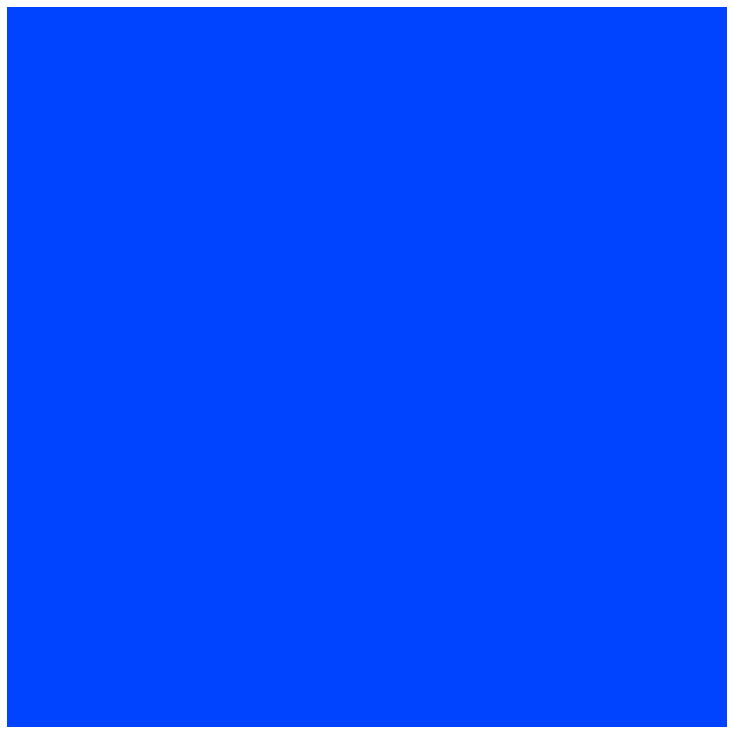

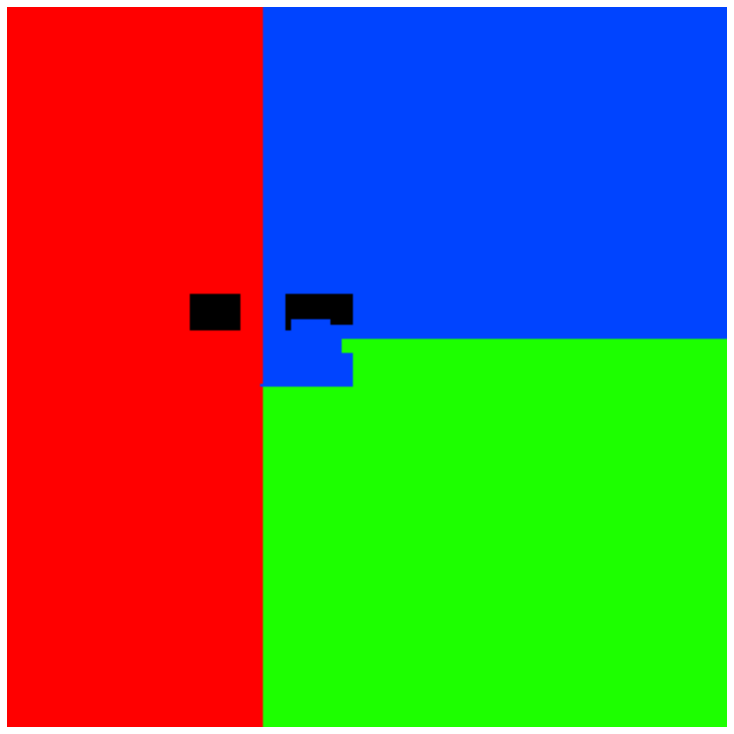

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


138
10351402
point chosen is: 115,100
9831202
coordinates are 4 4
8619136
coordinates are 4 87
7407070
coordinates are 4 88
6195004
coordinates are 4 89
4982938
coordinates are 4 90
4309568
coordinates are 4 91
3636198
coordinates are 4 92
2424132
coordinates are 4 93
1212066
coordinates are 4 94
0
coordinates are 4 95


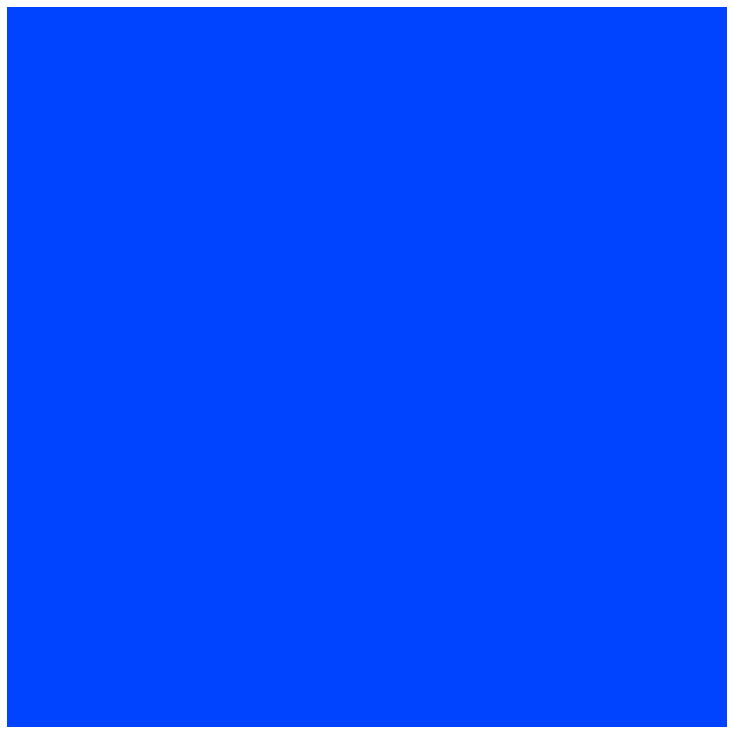

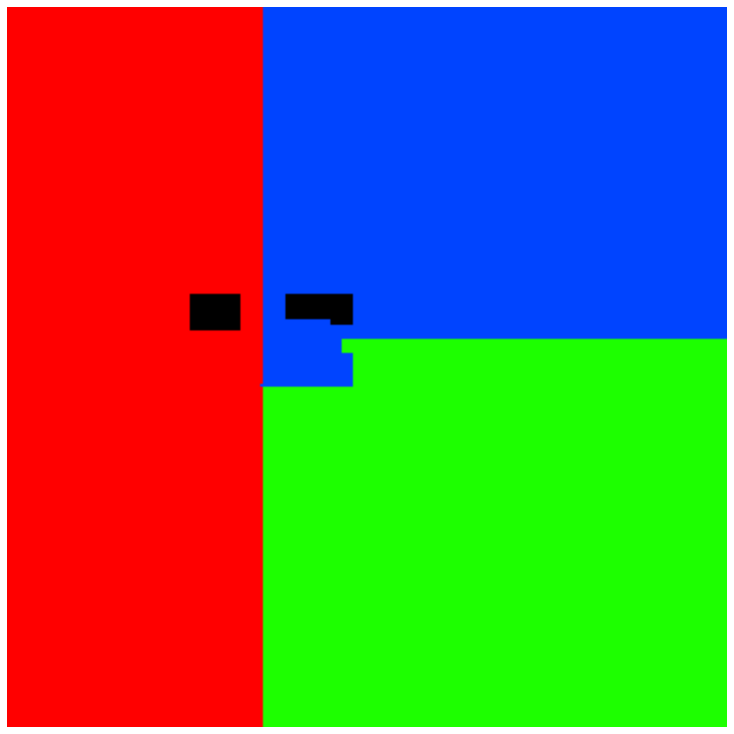

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


131
1300500
point chosen is: 115,82
0
coordinates are 4 4


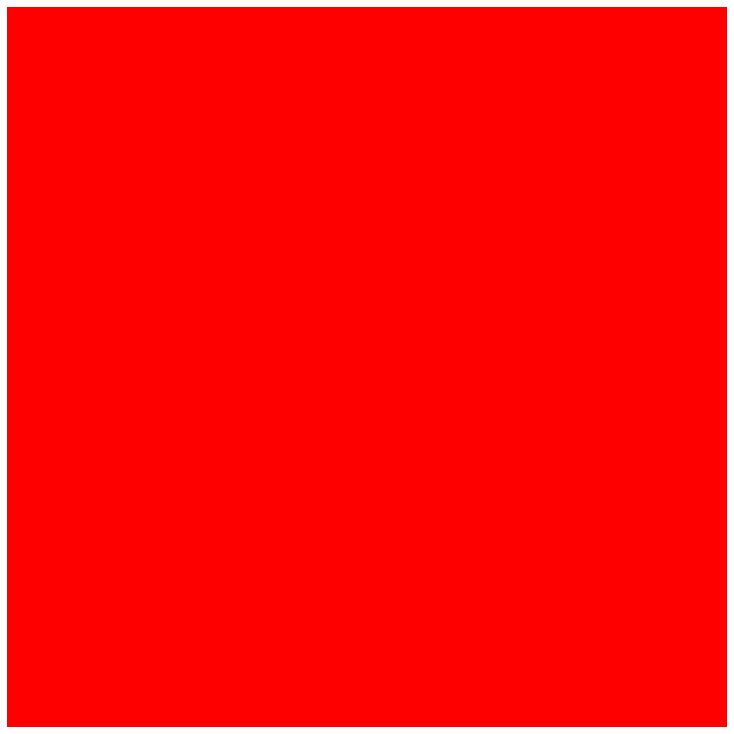

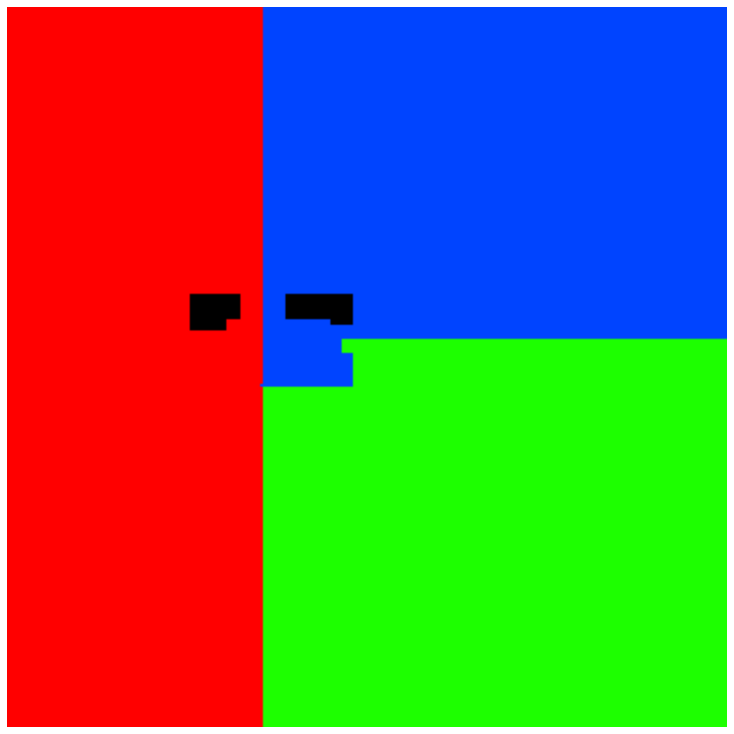

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


130
1300500
point chosen is: 115,77
0
coordinates are 4 4


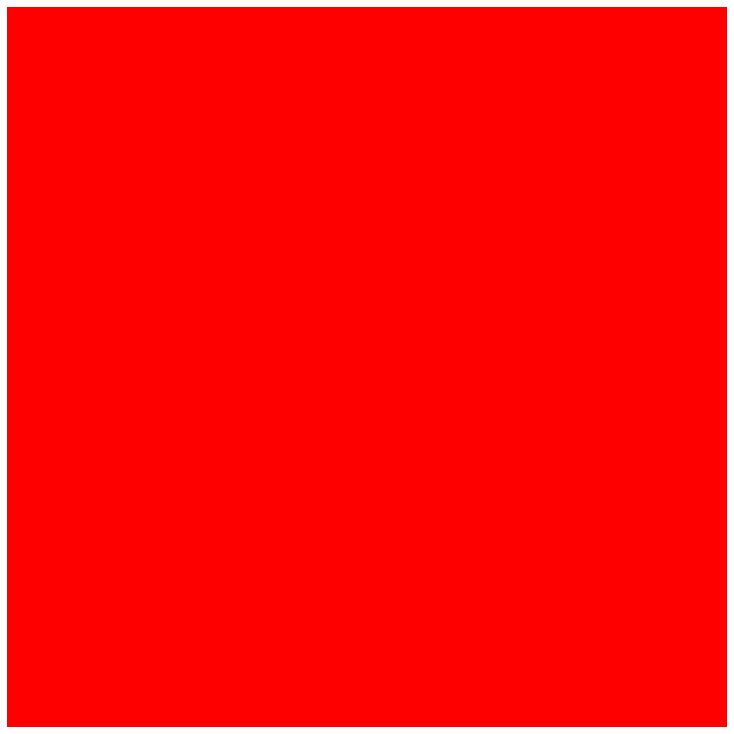

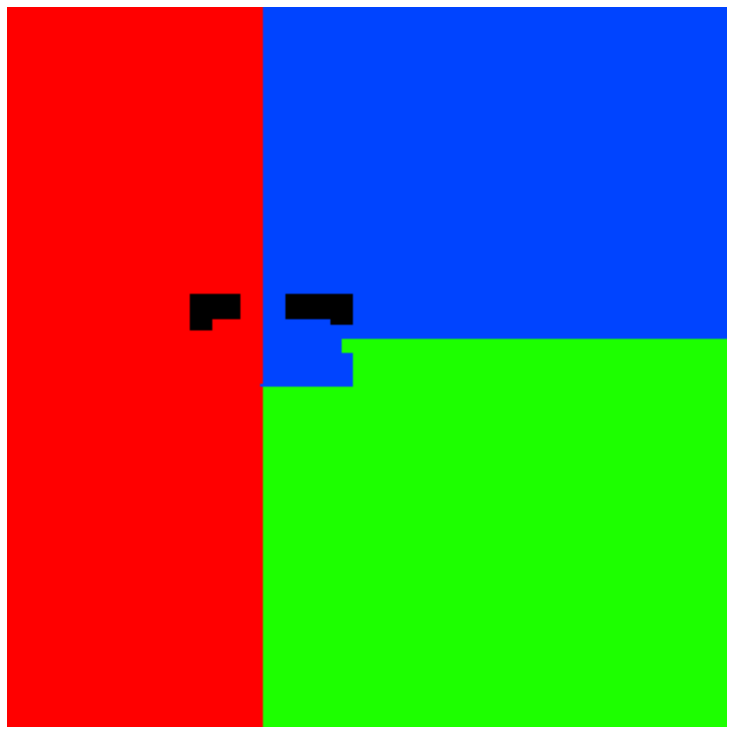

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


130
1300500
point chosen is: 115,72
0
coordinates are 4 4


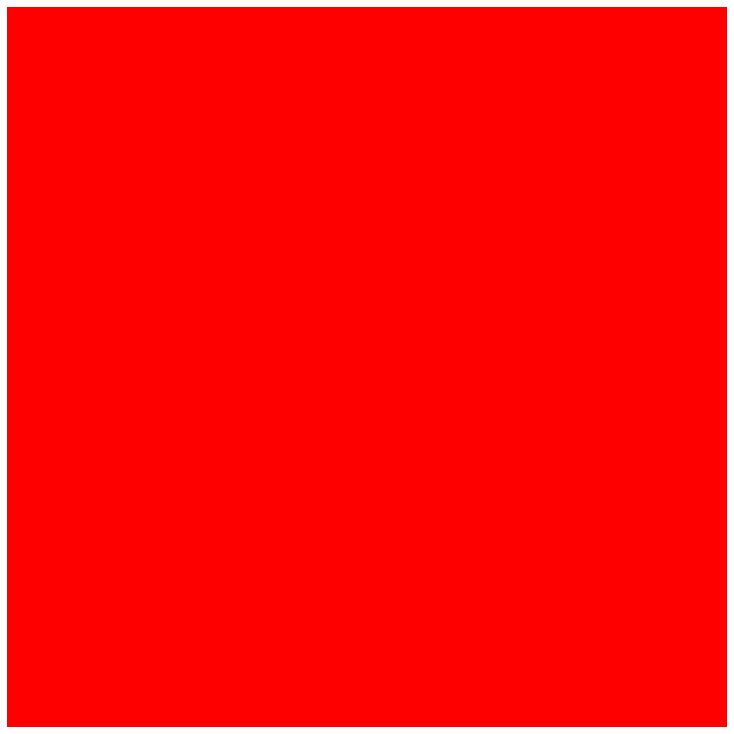

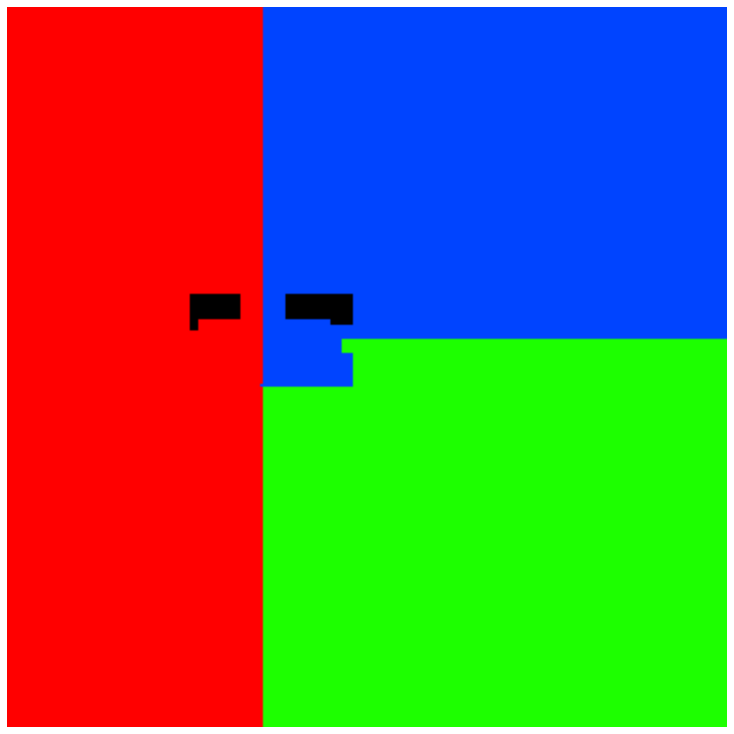

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


130
780300
point chosen is: 115,67
0
coordinates are 4 4


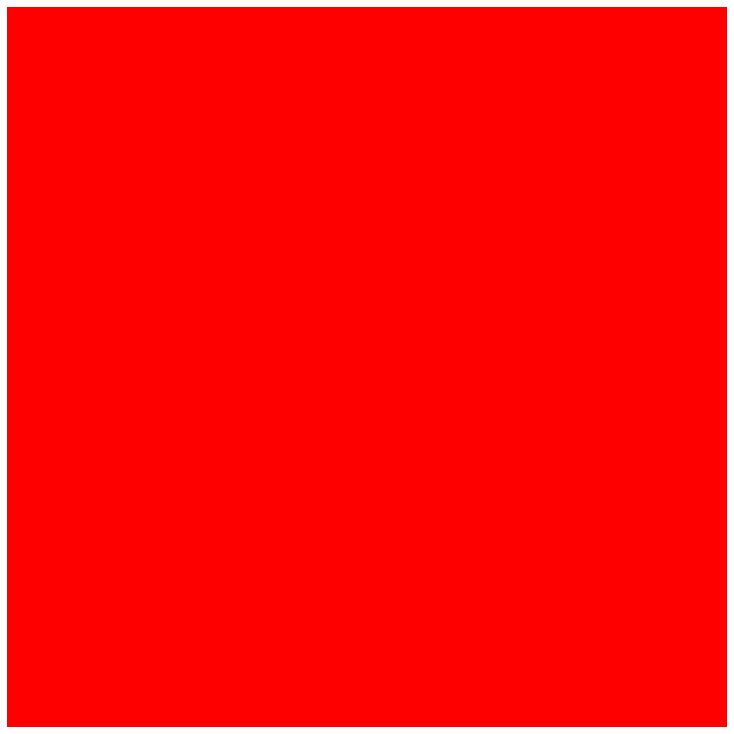

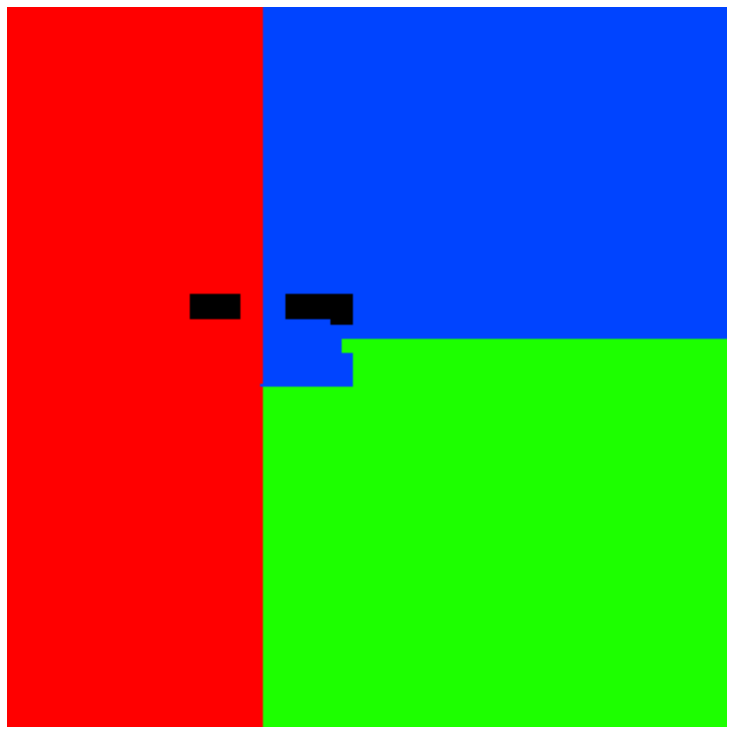

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


123
9515614
point chosen is: 113,122
8215114
coordinates are 4 4
7003048
coordinates are 4 87
5790982
coordinates are 4 88
4578916
coordinates are 4 89
3366850
coordinates are 4 90
2693480
coordinates are 4 91
2020110
coordinates are 4 92
1346740
coordinates are 4 93
673370
coordinates are 4 94
0
coordinates are 4 95


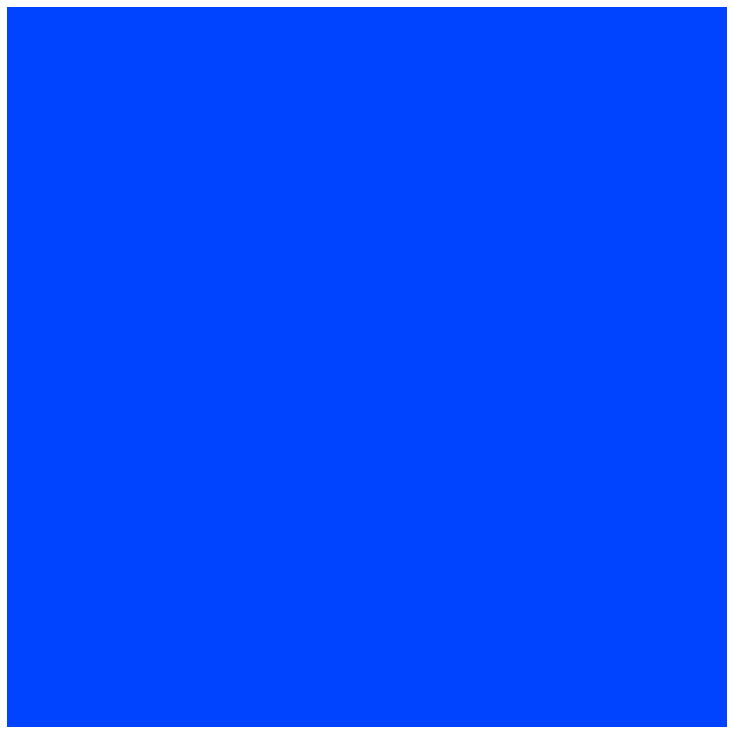

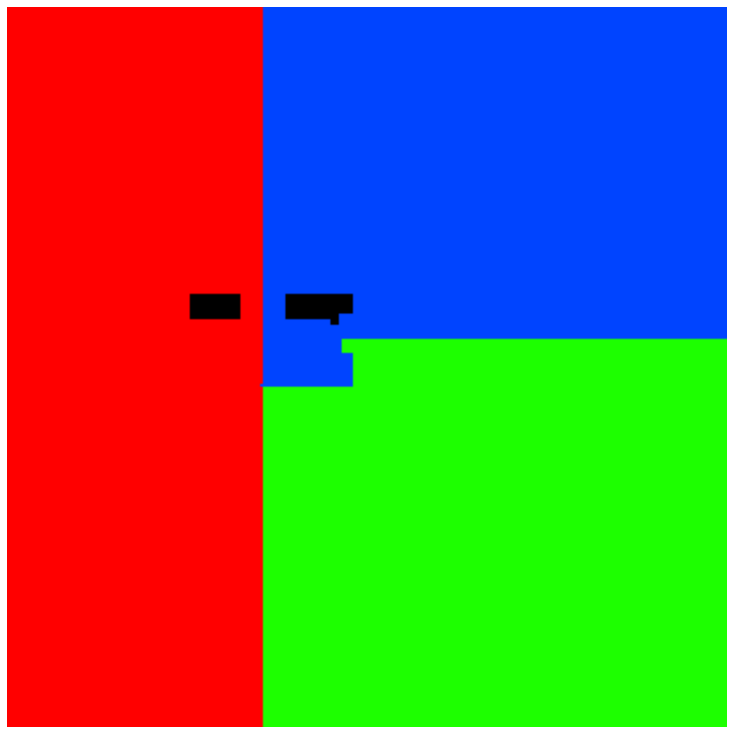

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


122
9794210
point chosen is: 113,117
8753810
coordinates are 4 4
7541744
coordinates are 4 87
6329678
coordinates are 4 88
5117612
coordinates are 4 89
3905546
coordinates are 4 90
3232176
coordinates are 4 91
2558806
coordinates are 4 92
1885436
coordinates are 4 93
942718
coordinates are 4 94
0
coordinates are 4 95


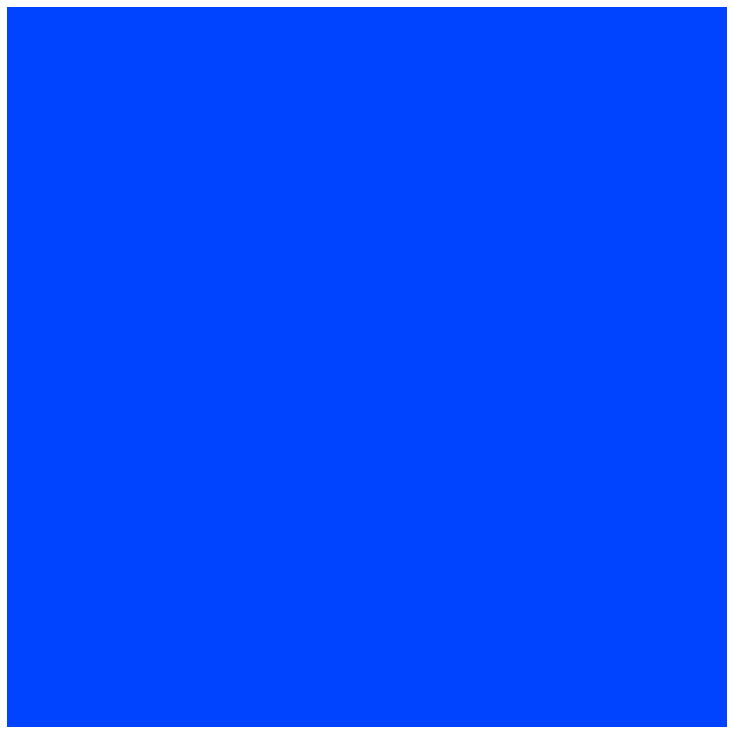

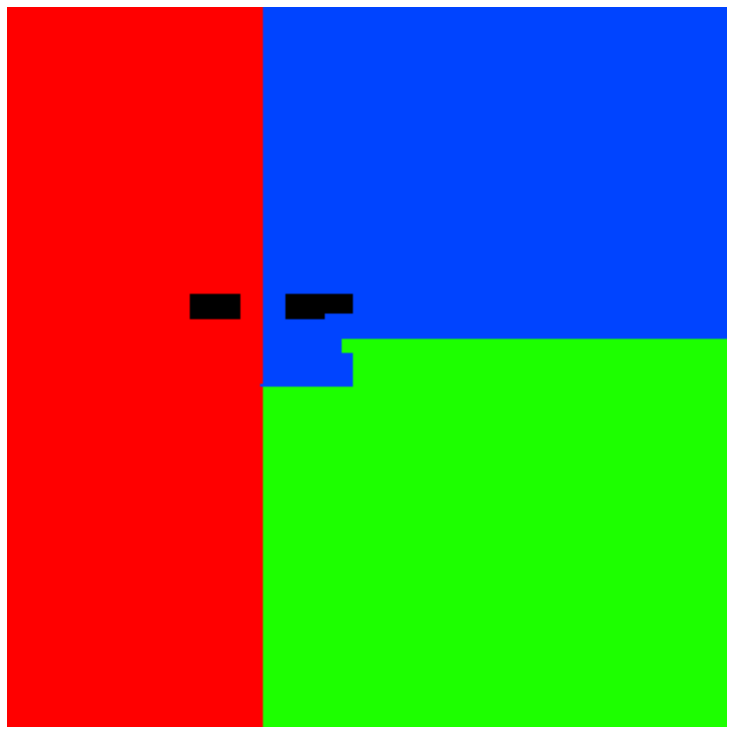

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


119
8958422
point chosen is: 111,112
7137722
coordinates are 4 4
6195004
coordinates are 4 87
5252286
coordinates are 4 88
4309568
coordinates are 4 89
3366850
coordinates are 4 90
2693480
coordinates are 4 91
2020110
coordinates are 4 92
1346740
coordinates are 4 93
673370
coordinates are 4 94
0
coordinates are 4 95


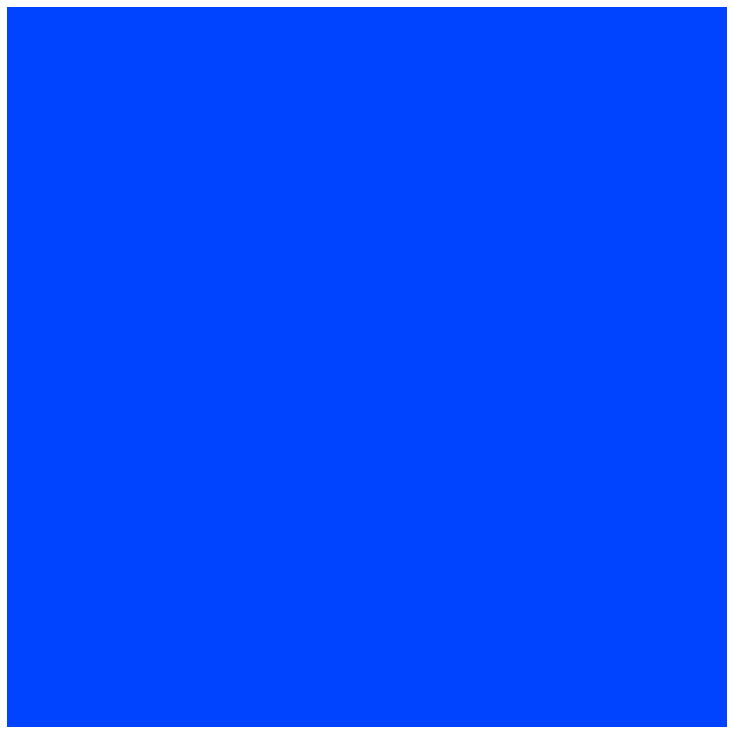

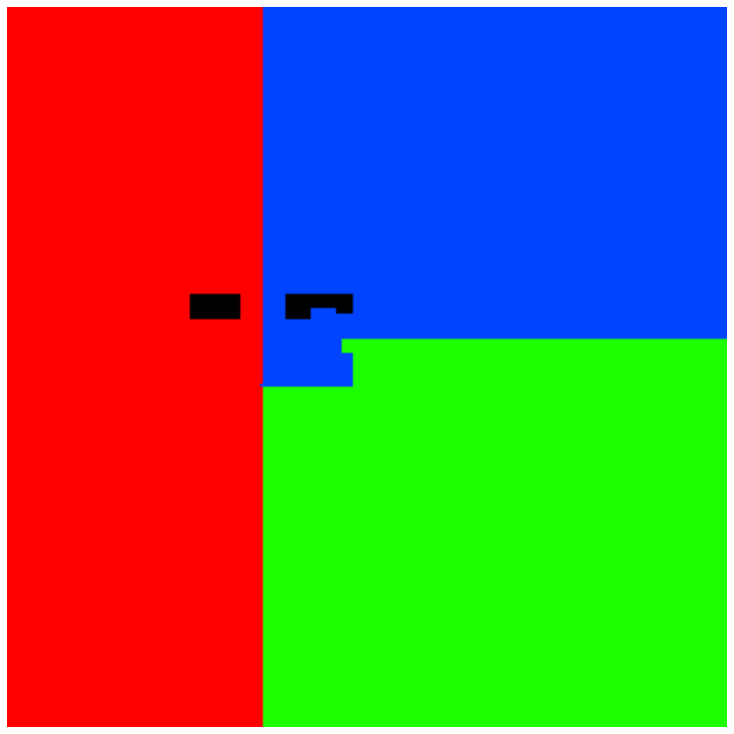

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


122
9515614
point chosen is: 111,107
8215114
coordinates are 4 4
7003048
coordinates are 4 87
5790982
coordinates are 4 88
4578916
coordinates are 4 89
3366850
coordinates are 4 90
2693480
coordinates are 4 91
2020110
coordinates are 4 92
1346740
coordinates are 4 93
673370
coordinates are 4 94
0
coordinates are 4 95


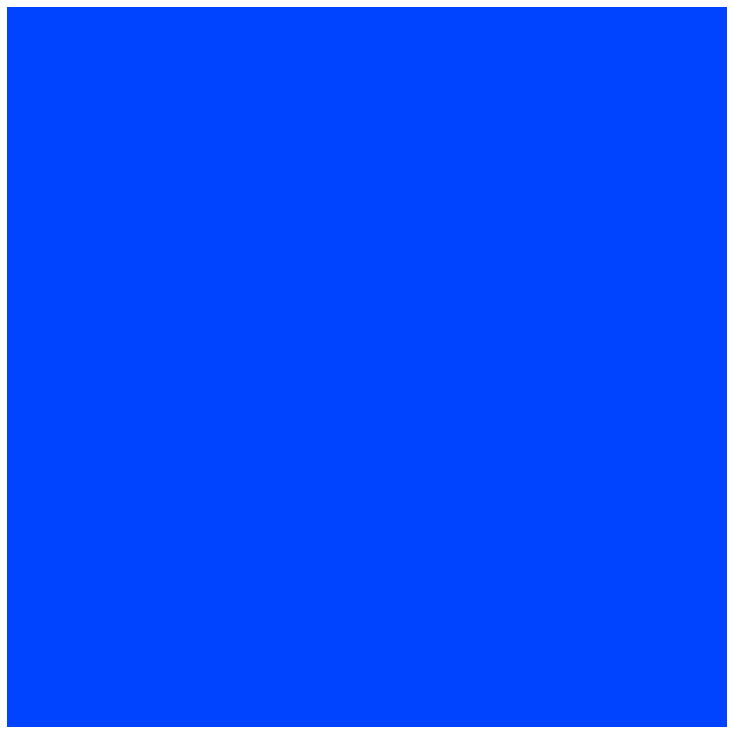

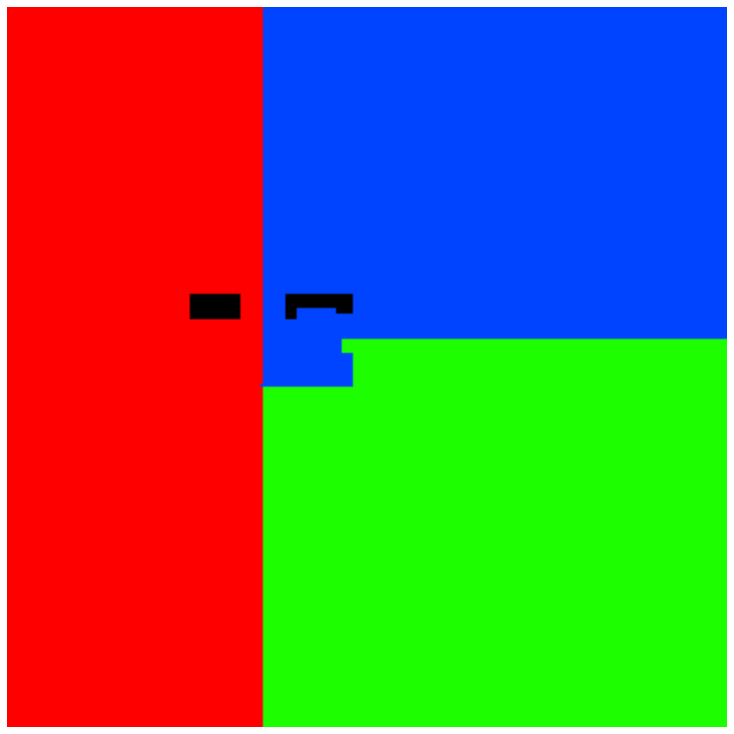

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


122
9794210
point chosen is: 111,102
8753810
coordinates are 4 4
7541744
coordinates are 4 87
6329678
coordinates are 4 88
5117612
coordinates are 4 89
3905546
coordinates are 4 90
3232176
coordinates are 4 91
2558806
coordinates are 4 92
1885436
coordinates are 4 93
1212066
coordinates are 4 94
0
coordinates are 4 95


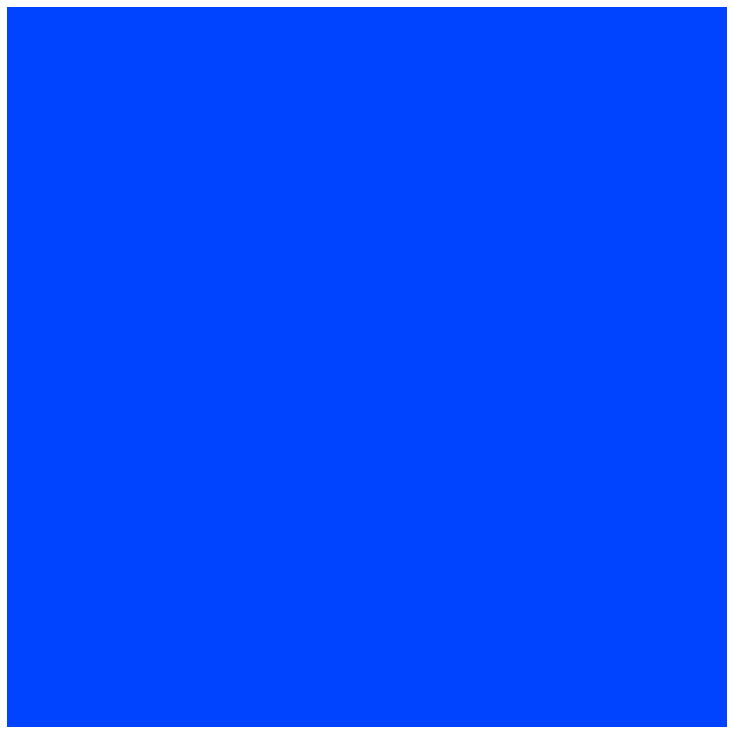

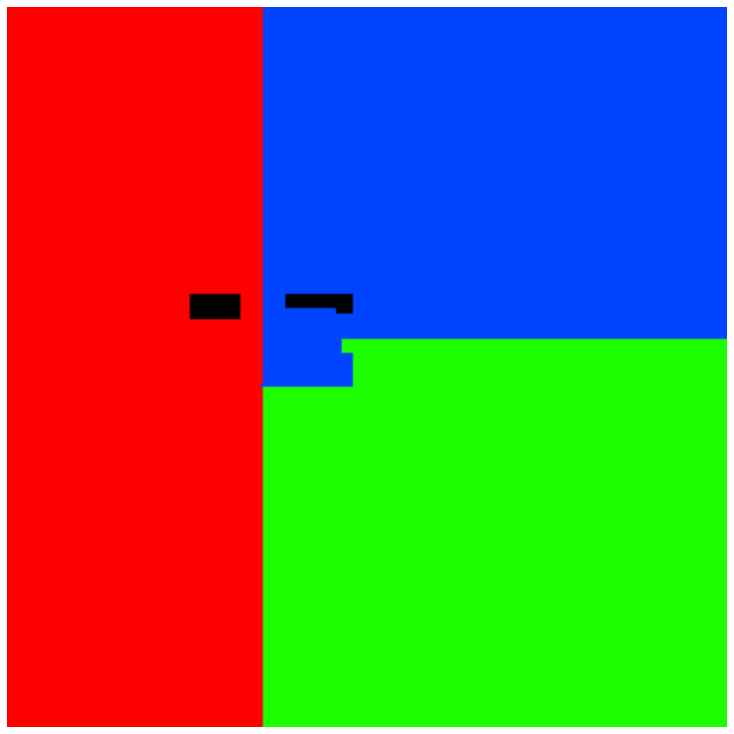

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


115
1300500
point chosen is: 111,82
0
coordinates are 4 4


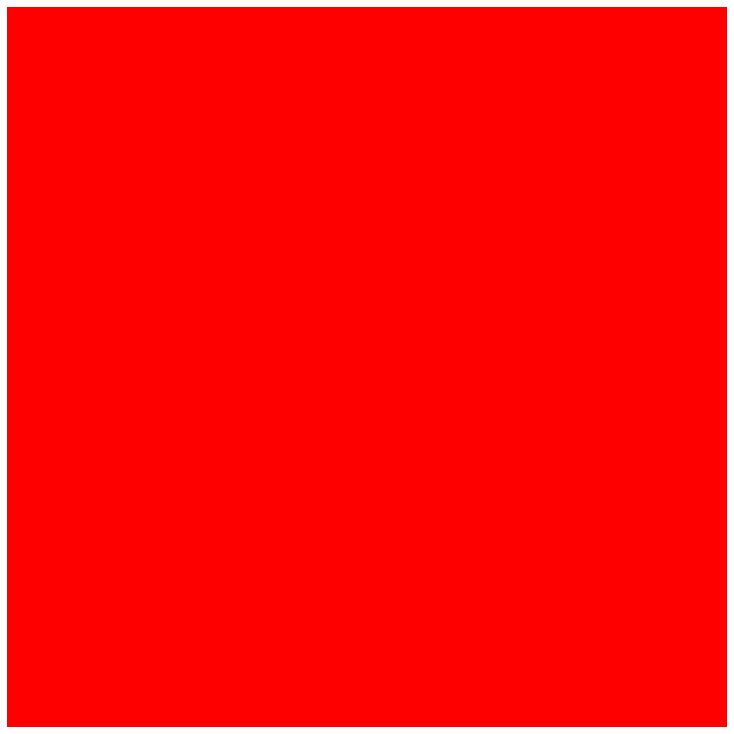

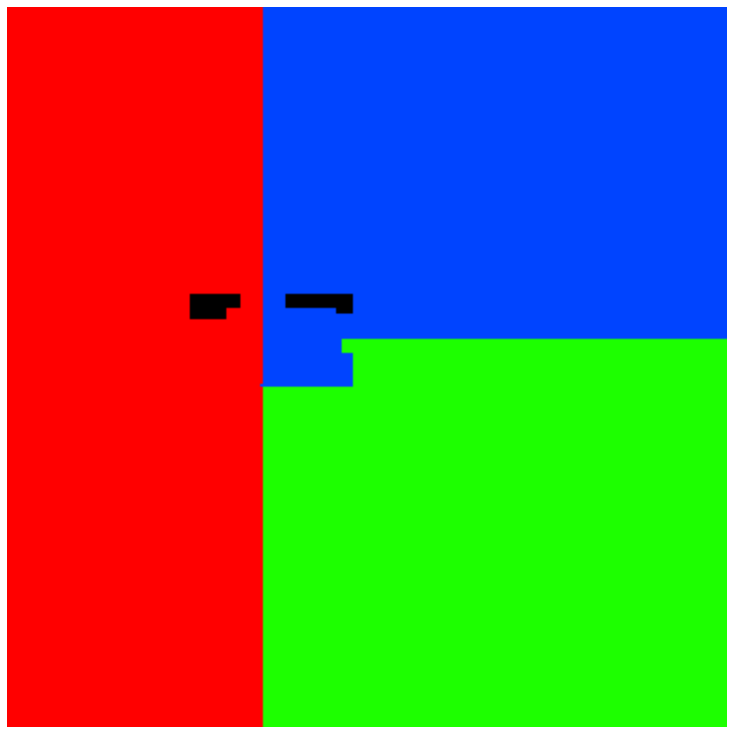

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


114
1300500
point chosen is: 111,77
0
coordinates are 4 4


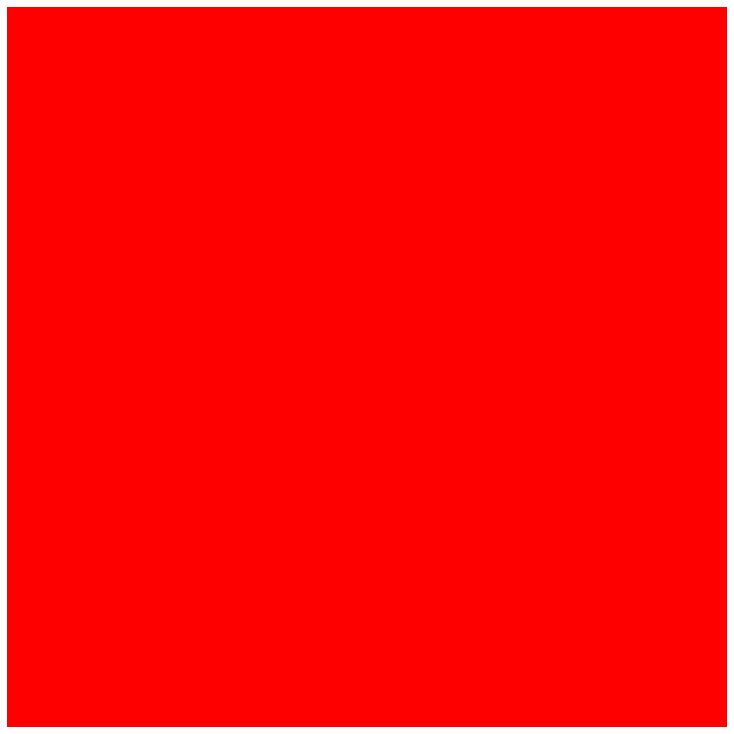

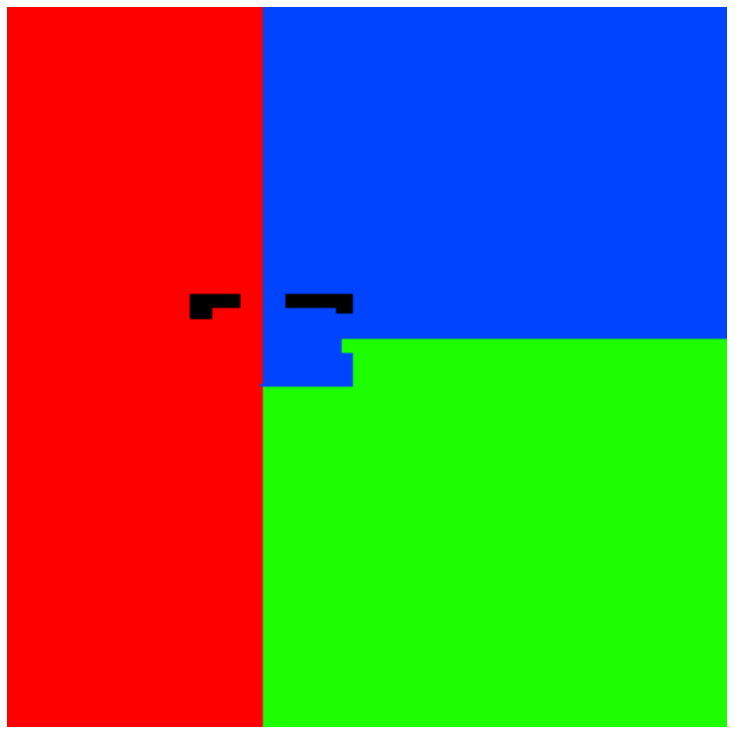

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


114
1300500
point chosen is: 111,72
0
coordinates are 4 4


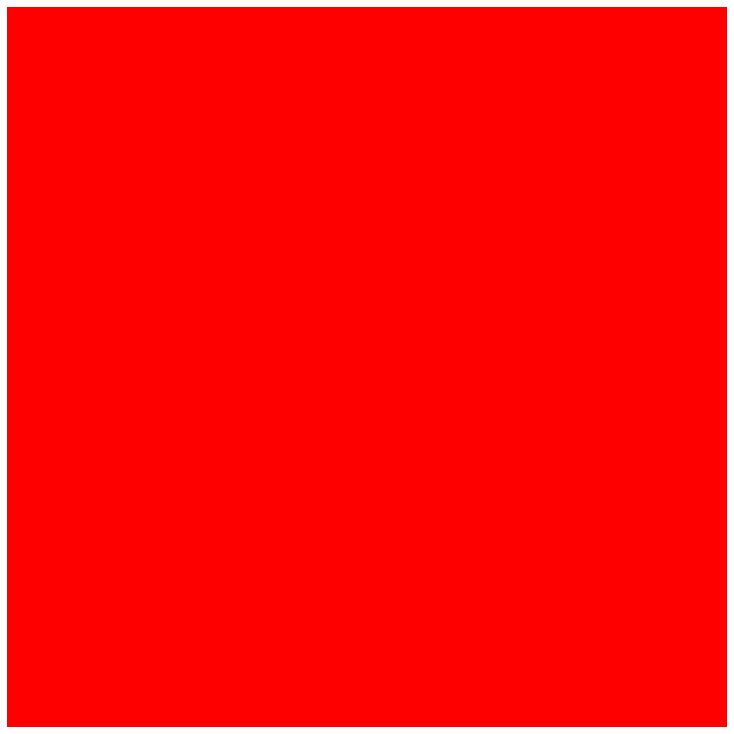

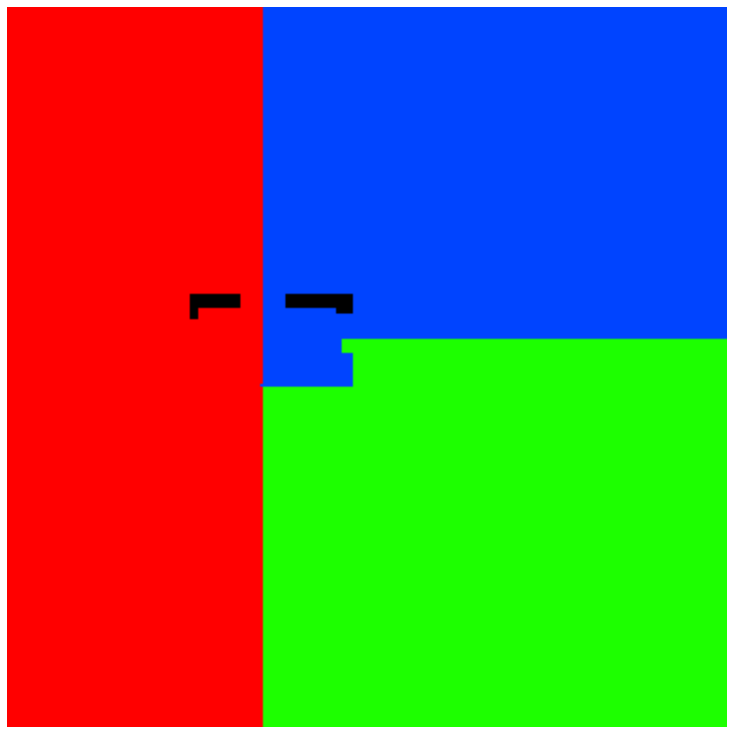

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


114
780300
point chosen is: 111,67
0
coordinates are 4 4


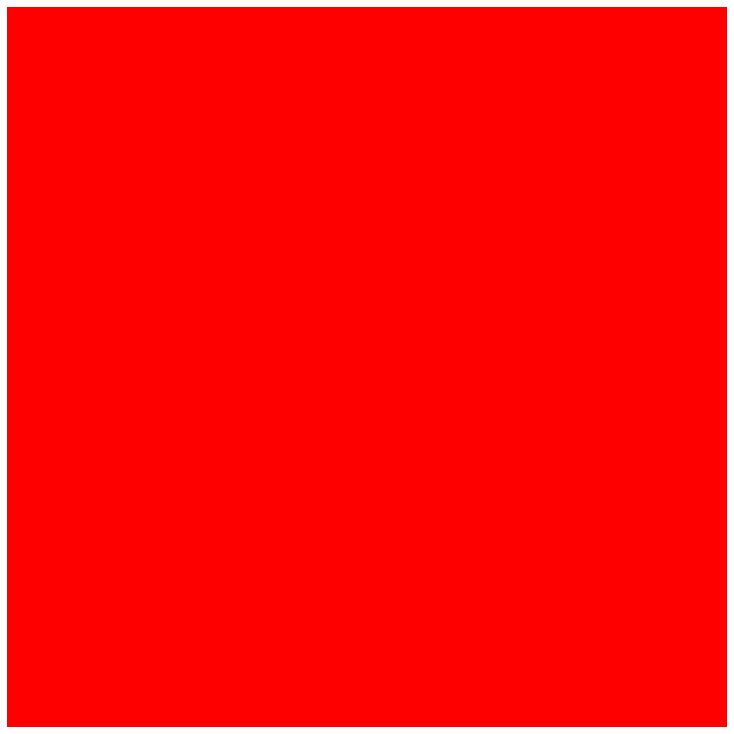

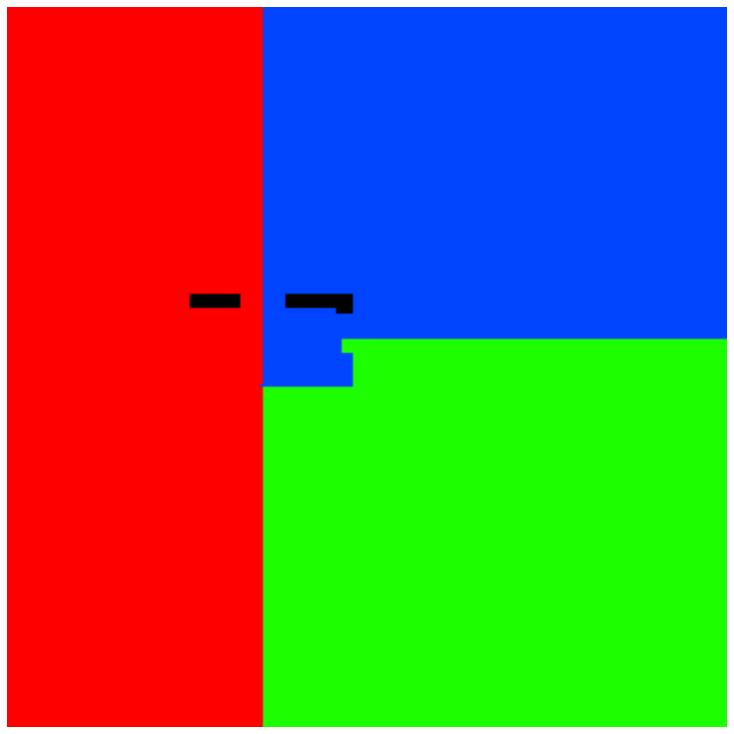

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


107
9515614
point chosen is: 109,122
8215114
coordinates are 4 4
7003048
coordinates are 4 87
5790982
coordinates are 4 88
4578916
coordinates are 4 89
3366850
coordinates are 4 90
2693480
coordinates are 4 91
2020110
coordinates are 4 92
1346740
coordinates are 4 93
673370
coordinates are 4 94
0
coordinates are 4 95


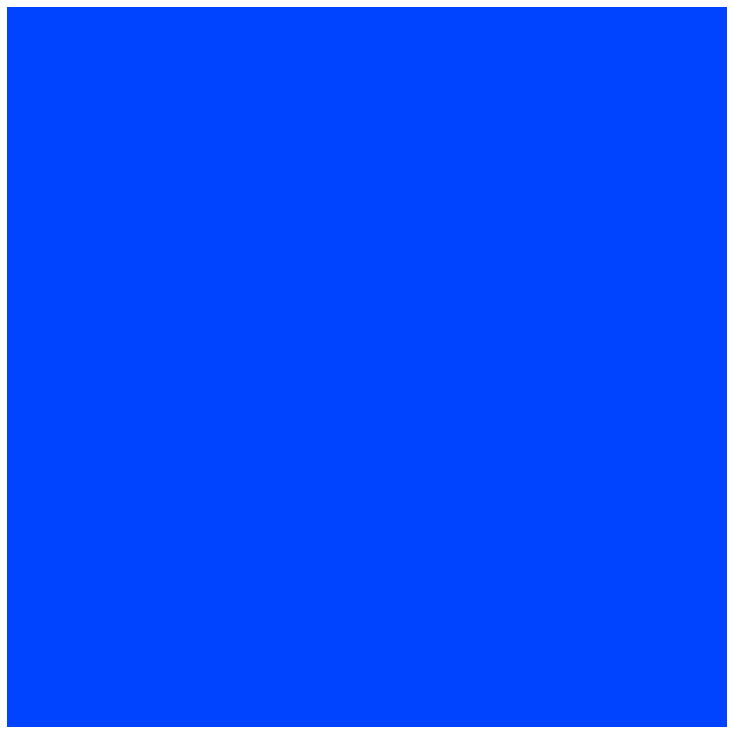

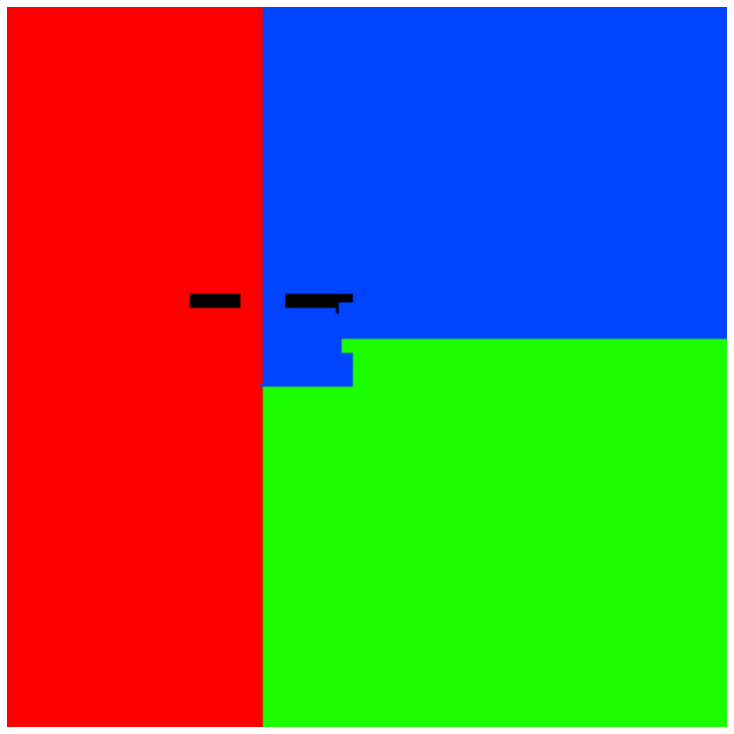

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


106
10072806
point chosen is: 109,117
9292506
coordinates are 4 4
8080440
coordinates are 4 87
6868374
coordinates are 4 88
5656308
coordinates are 4 89
4444242
coordinates are 4 90
3770872
coordinates are 4 91
2828154
coordinates are 4 92
1885436
coordinates are 4 93
942718
coordinates are 4 94
0
coordinates are 4 95


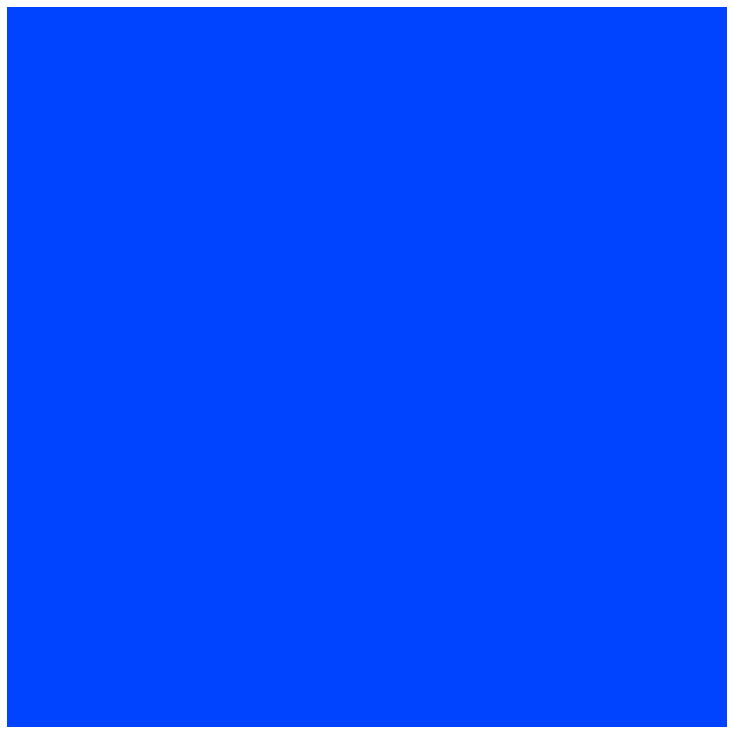

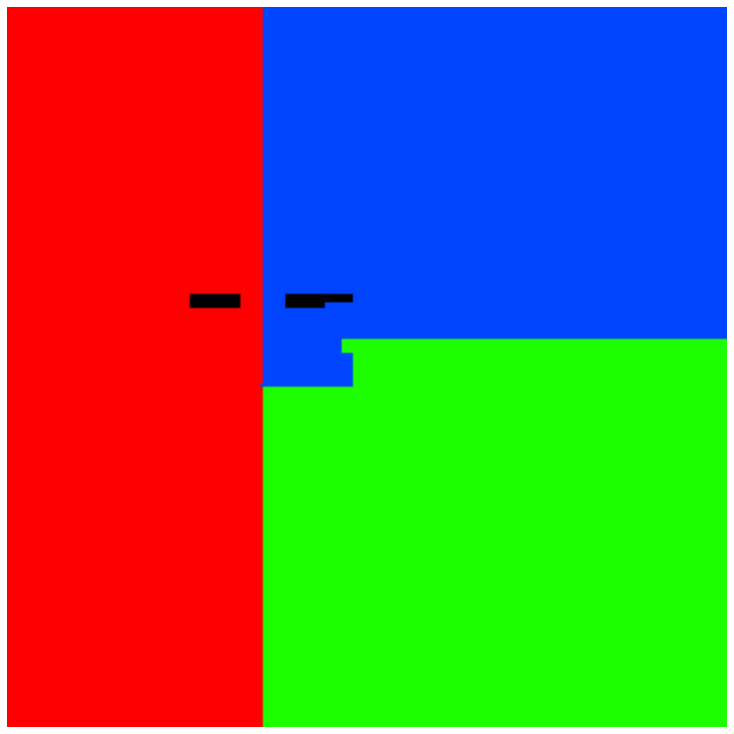

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


103
8958422
point chosen is: 107,112
7137722
coordinates are 4 4
6195004
coordinates are 4 87
5252286
coordinates are 4 88
4309568
coordinates are 4 89
3366850
coordinates are 4 90
2693480
coordinates are 4 91
2020110
coordinates are 4 92
1346740
coordinates are 4 93
673370
coordinates are 4 94
0
coordinates are 4 95


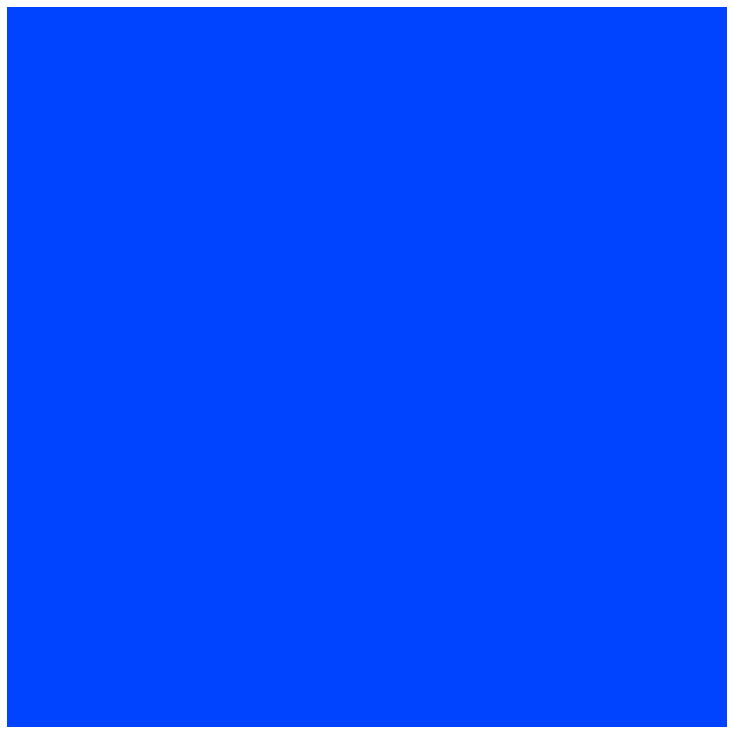

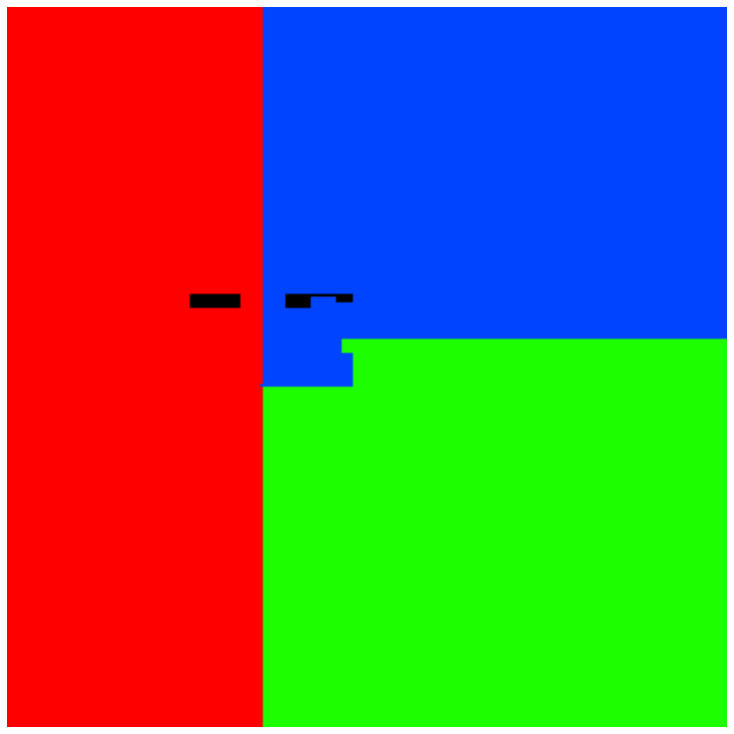

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


106
9515614
point chosen is: 107,107
8215114
coordinates are 4 4
7003048
coordinates are 4 87
5790982
coordinates are 4 88
4578916
coordinates are 4 89
3366850
coordinates are 4 90
2693480
coordinates are 4 91
2020110
coordinates are 4 92
1346740
coordinates are 4 93
673370
coordinates are 4 94
0
coordinates are 4 95


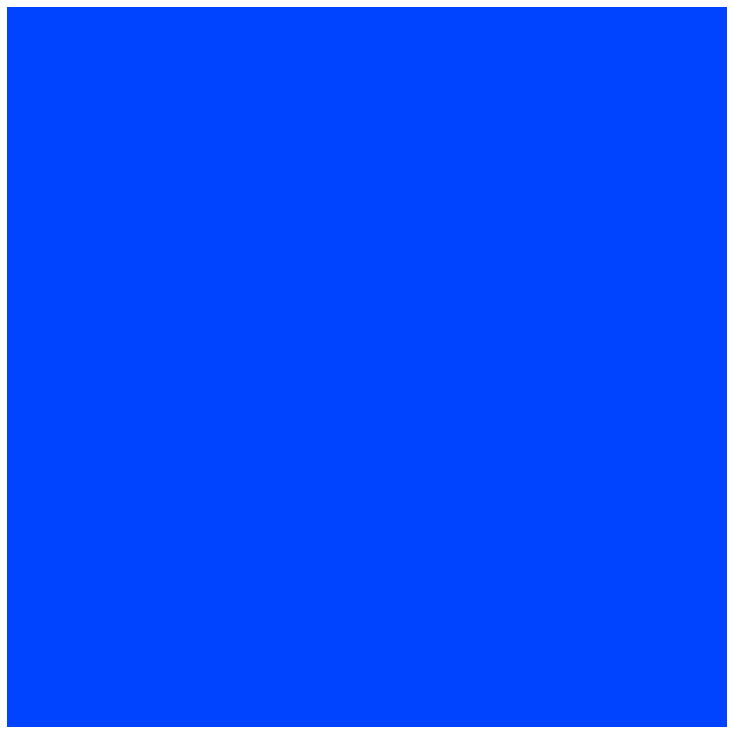

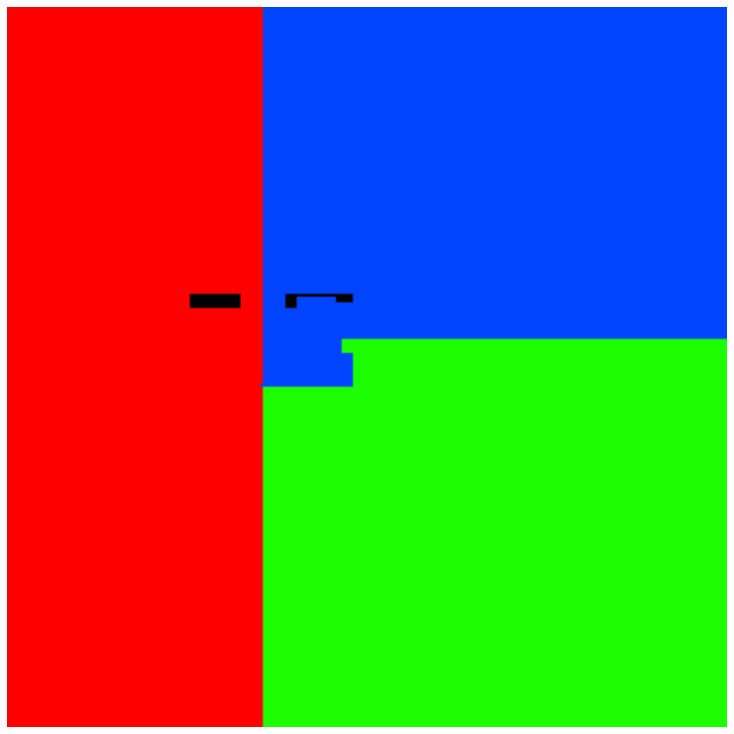

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


106
9794210
point chosen is: 107,102
8753810
coordinates are 4 4
7541744
coordinates are 4 87
6329678
coordinates are 4 88
5117612
coordinates are 4 89
3905546
coordinates are 4 90
3232176
coordinates are 4 91
2558806
coordinates are 4 92
1885436
coordinates are 4 93
1212066
coordinates are 4 94
0
coordinates are 4 95


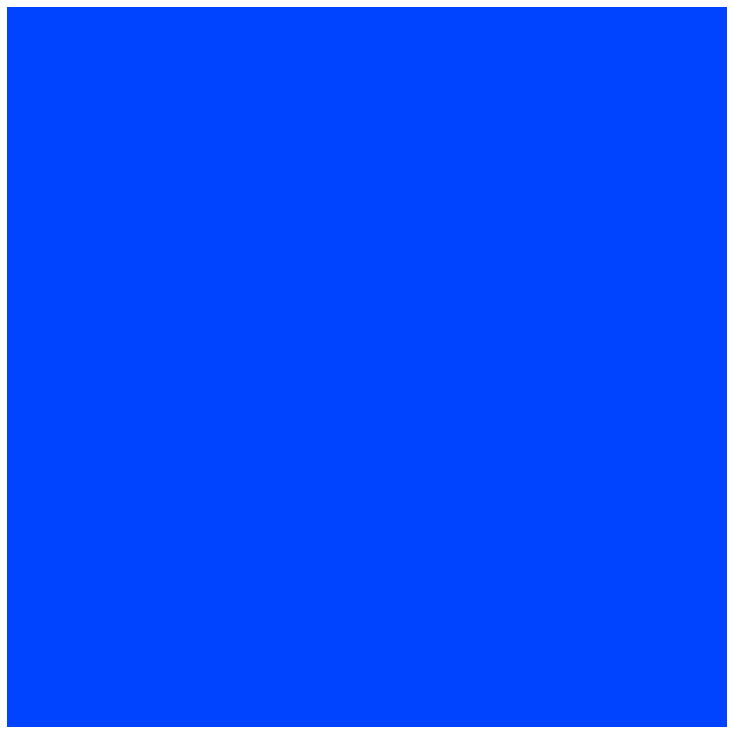

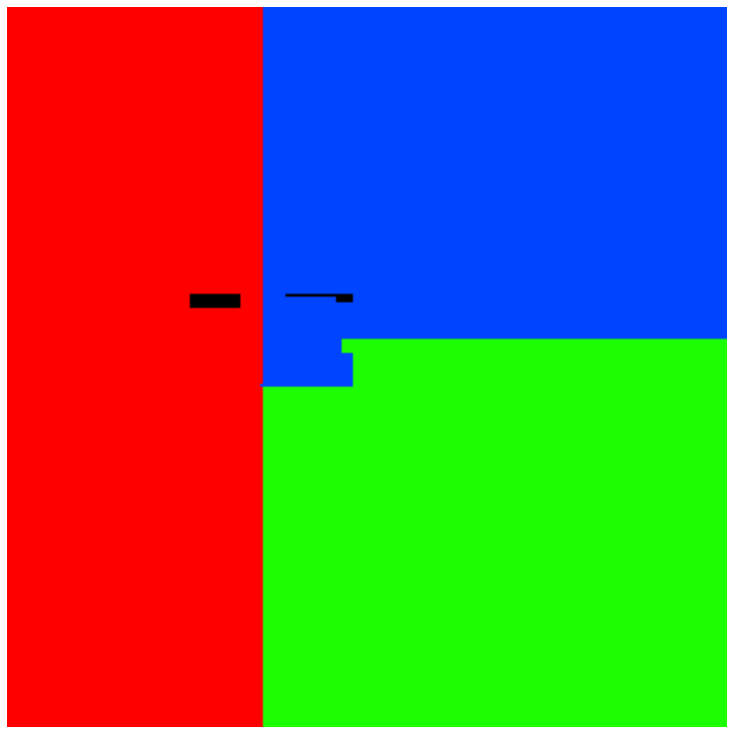

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


99
1300500
point chosen is: 107,82
0
coordinates are 4 4


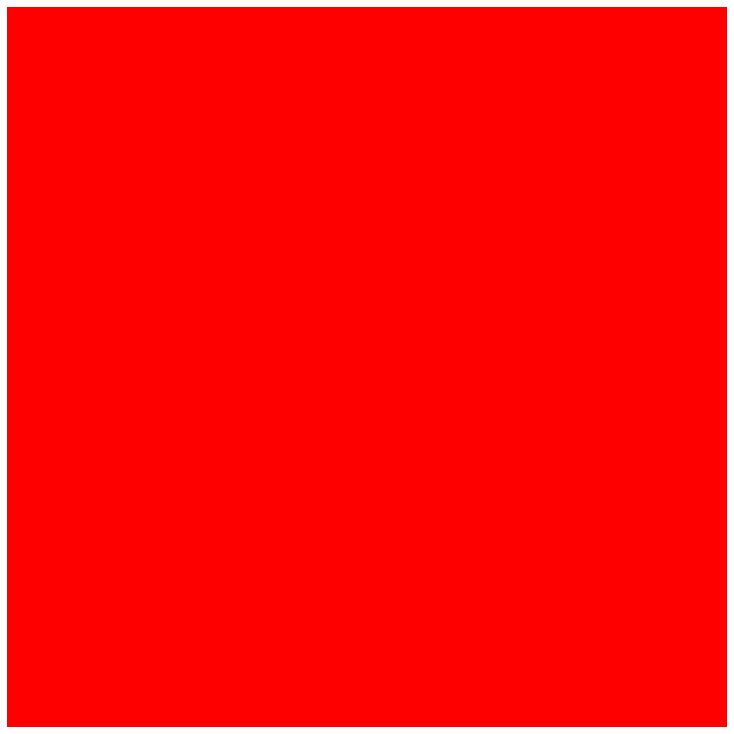

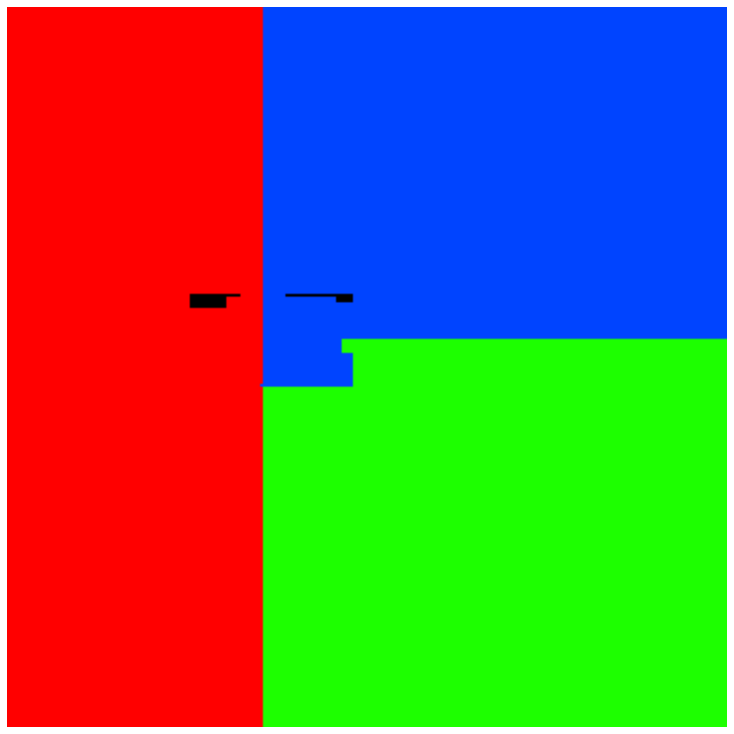

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


98
1300500
point chosen is: 107,77
0
coordinates are 4 4


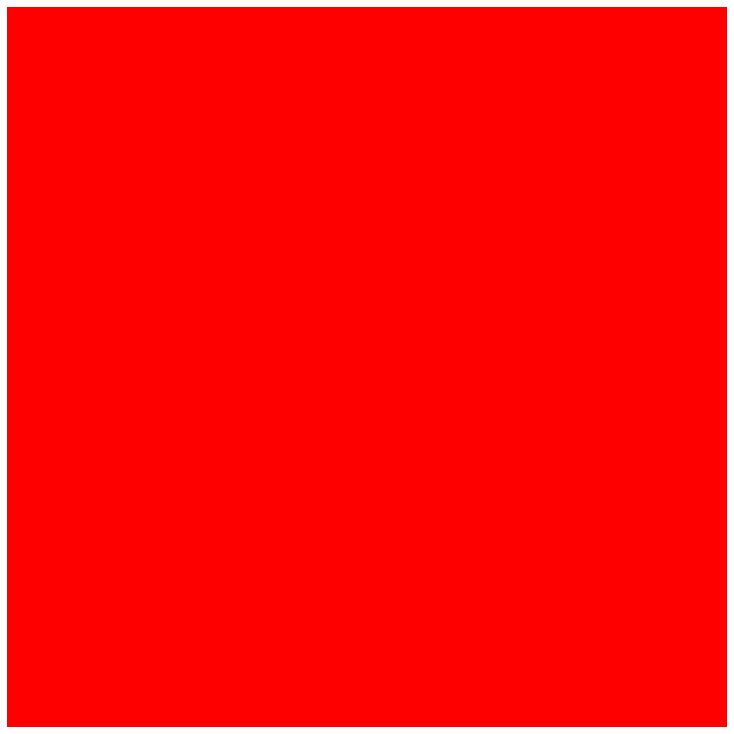

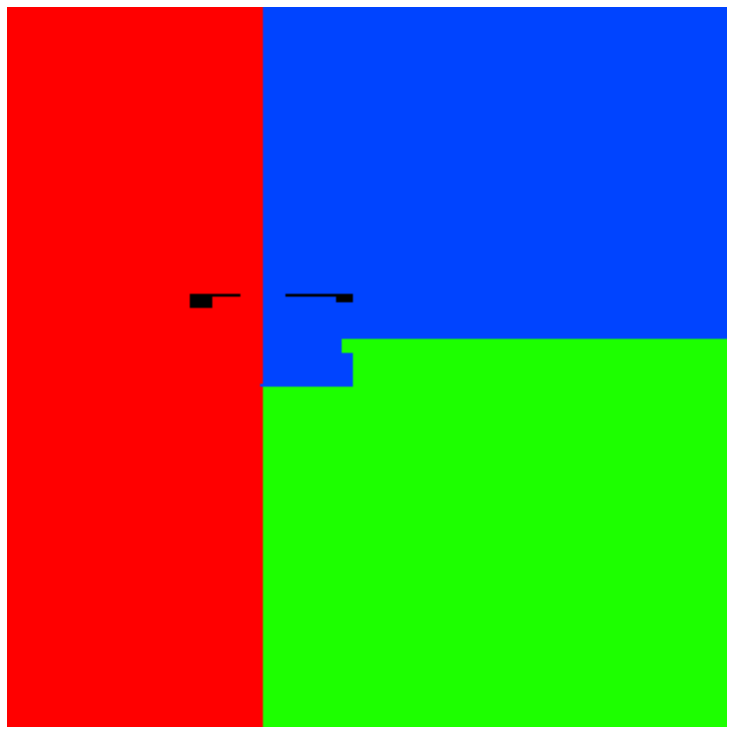

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


98
1300500
point chosen is: 107,72
0
coordinates are 4 4


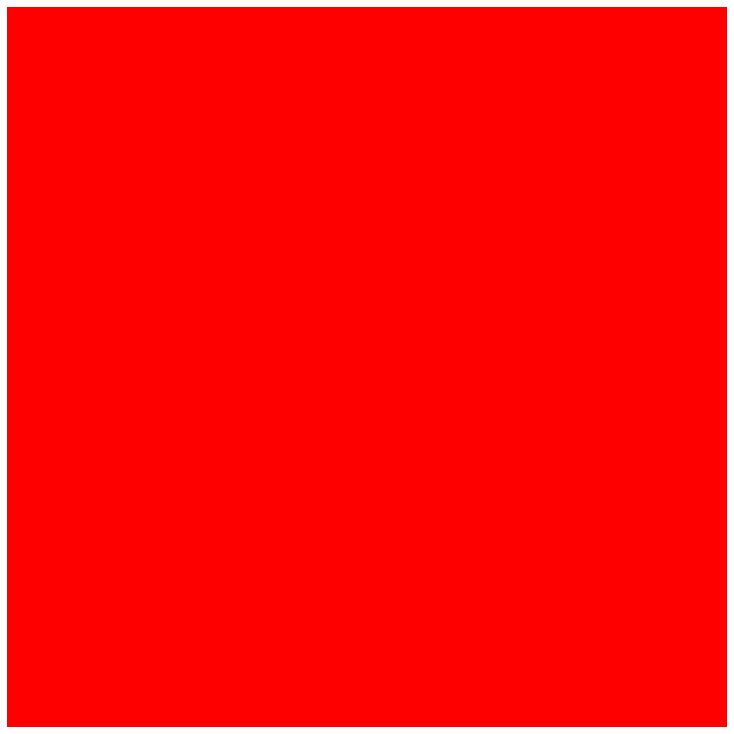

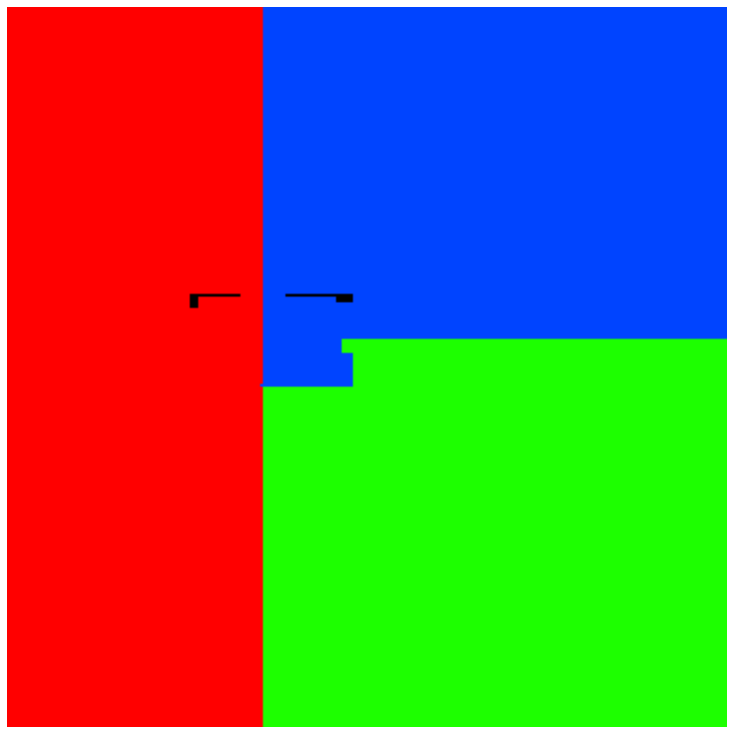

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


98
780300
point chosen is: 107,67
0
coordinates are 4 4


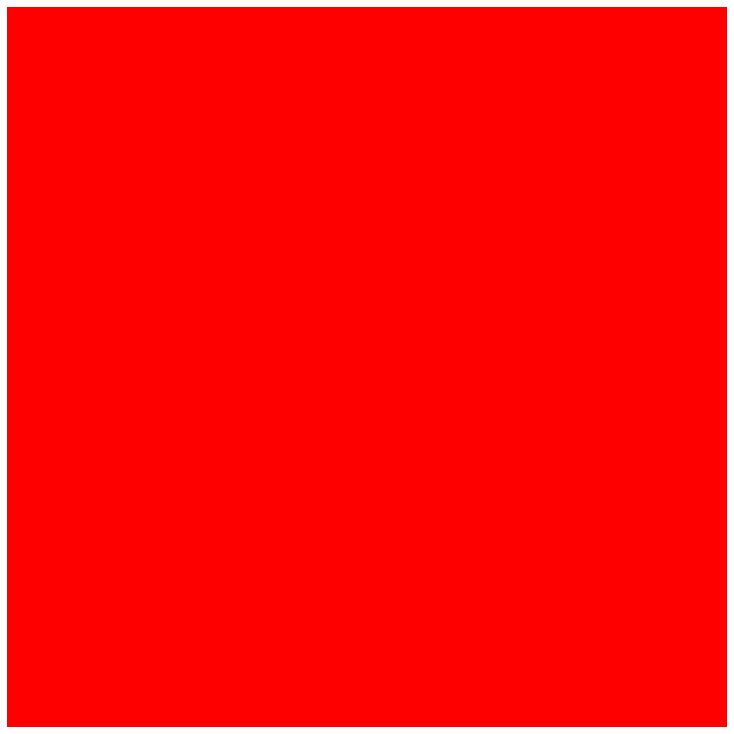

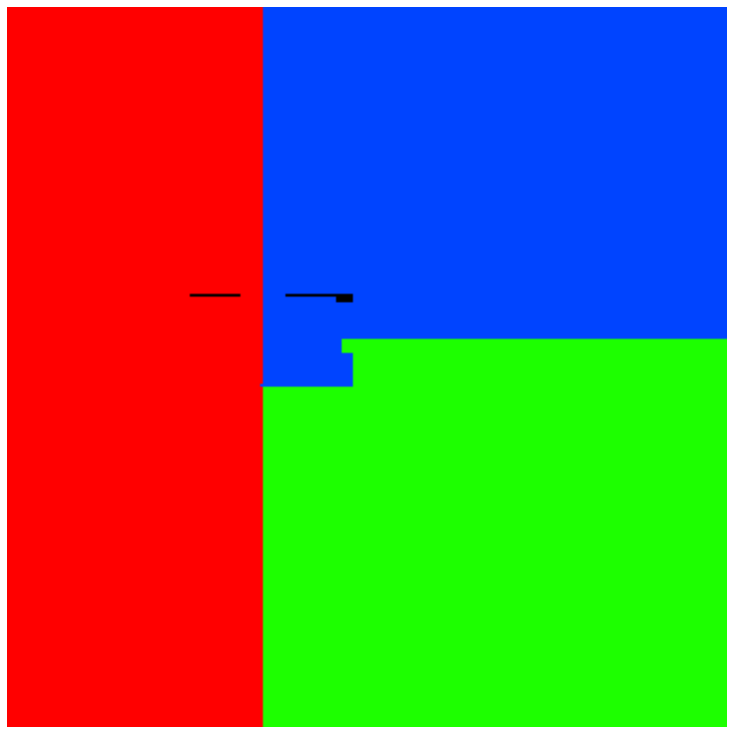

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


91
9863859
point chosen is: 105,122
8888484
coordinates are 4 4
7676418
coordinates are 4 87
6464352
coordinates are 4 88
5252286
coordinates are 4 89
4040220
coordinates are 4 90
3232176
coordinates are 4 91
2424132
coordinates are 4 92
1616088
coordinates are 4 93
808044
coordinates are 4 94
0
coordinates are 4 95


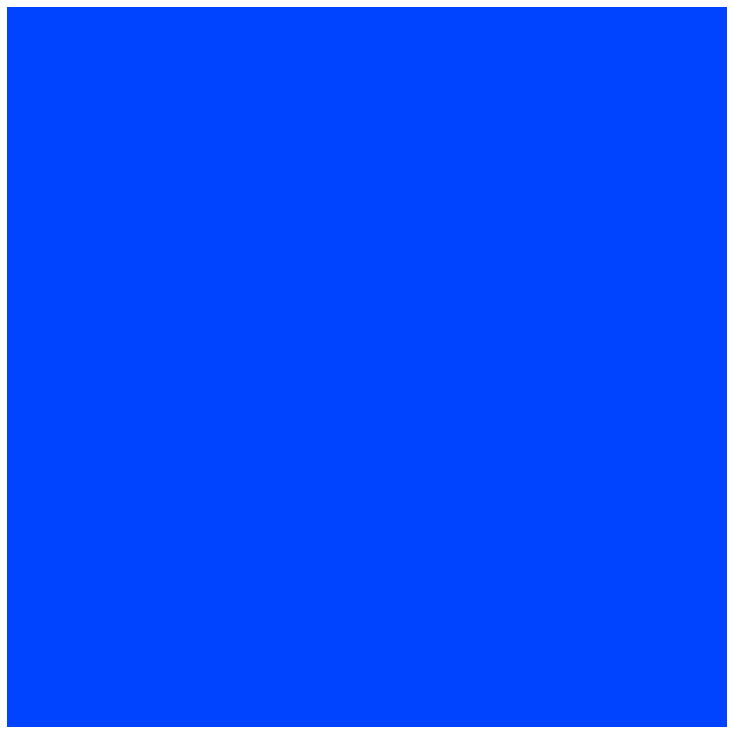

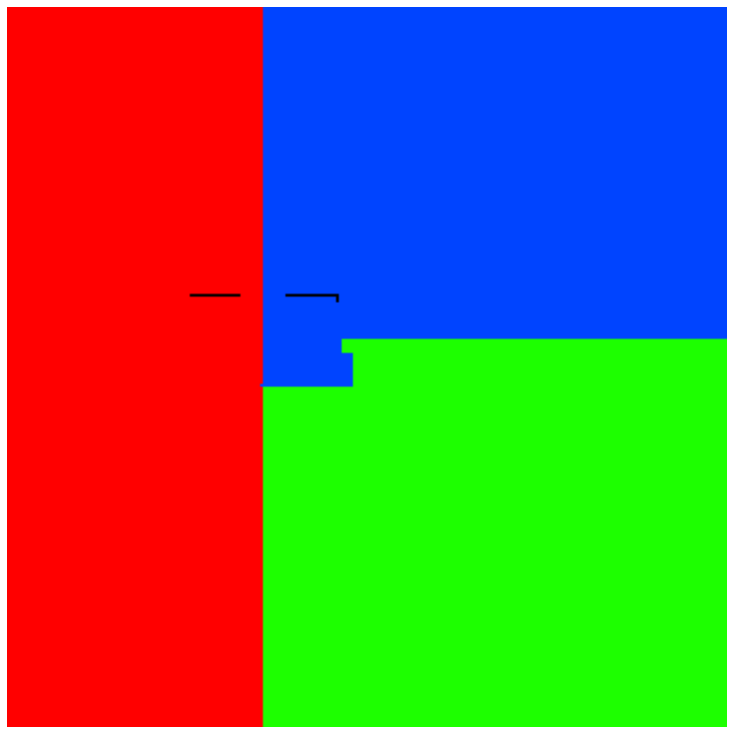

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


81
10421051
point chosen is: 105,117
9965876
coordinates are 4 4
8753810
coordinates are 4 87
7541744
coordinates are 4 88
6329678
coordinates are 4 89
5117612
coordinates are 4 90
4309568
coordinates are 4 91
3232176
coordinates are 4 92
2154784
coordinates are 4 93
1077392
coordinates are 4 94
0
coordinates are 4 95


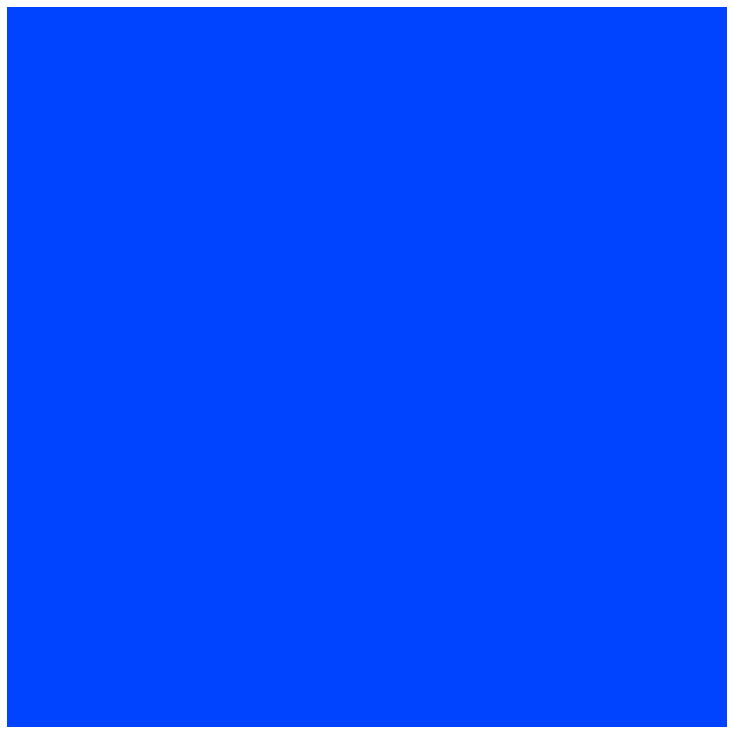

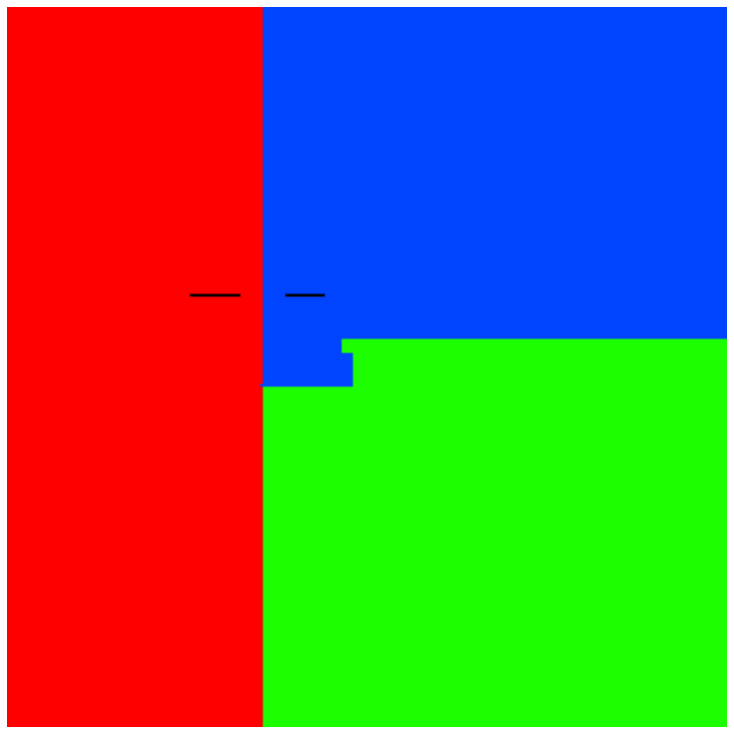

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


68
10560349
point chosen is: 103,112
10235224
coordinates are 4 4
9023158
coordinates are 4 87
7811092
coordinates are 4 88
6599026
coordinates are 4 89
5386960
coordinates are 4 90
4309568
coordinates are 4 91
3232176
coordinates are 4 92
2154784
coordinates are 4 93
1077392
coordinates are 4 94
0
coordinates are 4 95


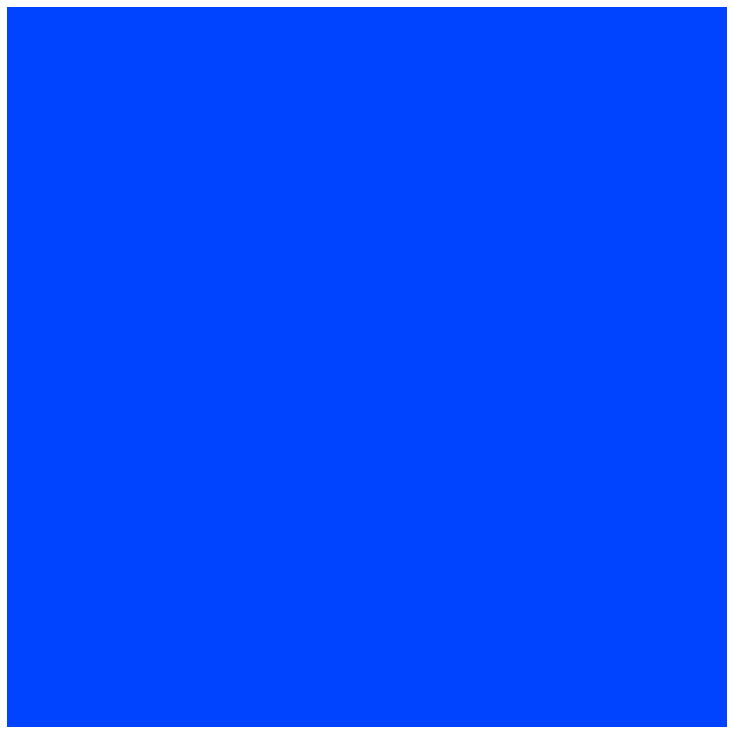

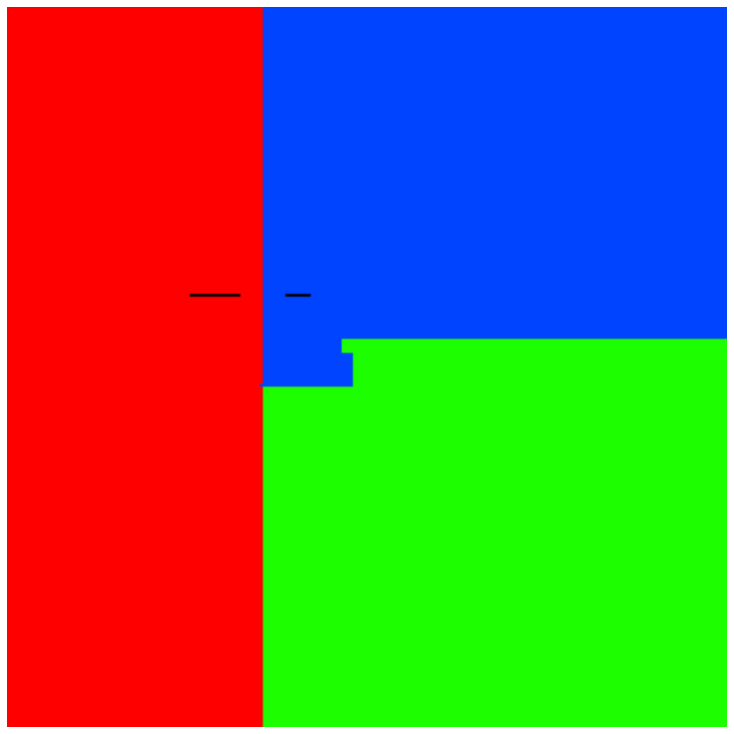

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


58
10560349
point chosen is: 103,107
10235224
coordinates are 4 4
9023158
coordinates are 4 87
7811092
coordinates are 4 88
6599026
coordinates are 4 89
5386960
coordinates are 4 90
4309568
coordinates are 4 91
3232176
coordinates are 4 92
2154784
coordinates are 4 93
1077392
coordinates are 4 94
0
coordinates are 4 95


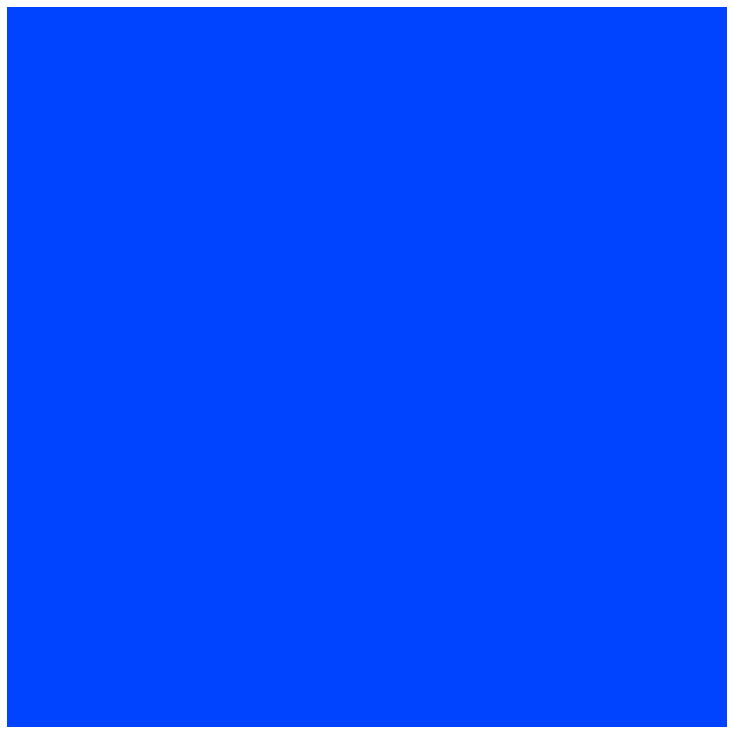

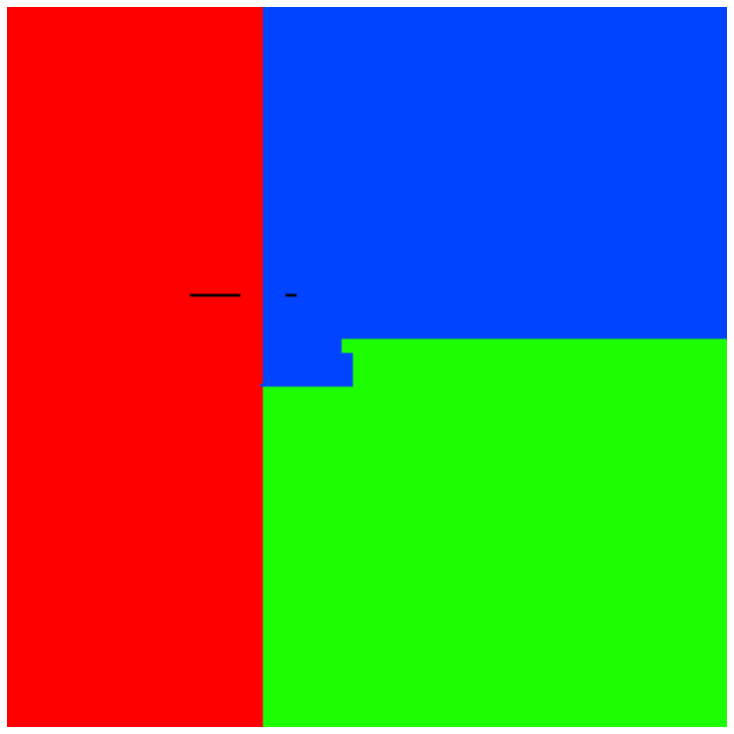

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


48
10629998
point chosen is: 103,102
10369898
coordinates are 4 4
9157832
coordinates are 4 87
7945766
coordinates are 4 88
6733700
coordinates are 4 89
5521634
coordinates are 4 90
4444242
coordinates are 4 91
3366850
coordinates are 4 92
2289458
coordinates are 4 93
1212066
coordinates are 4 94
0
coordinates are 4 95


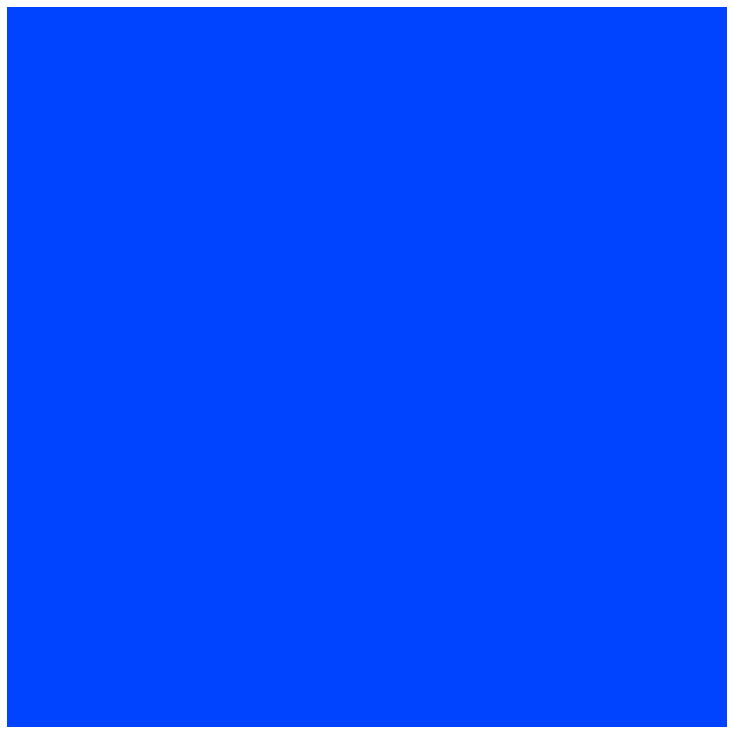

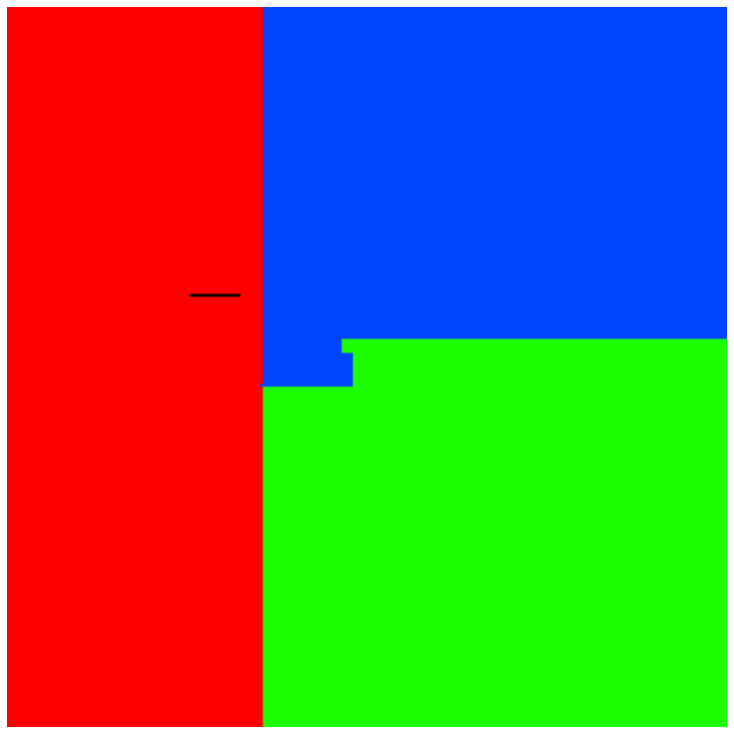

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


38
325125
point chosen is: 103,82
0
coordinates are 4 4


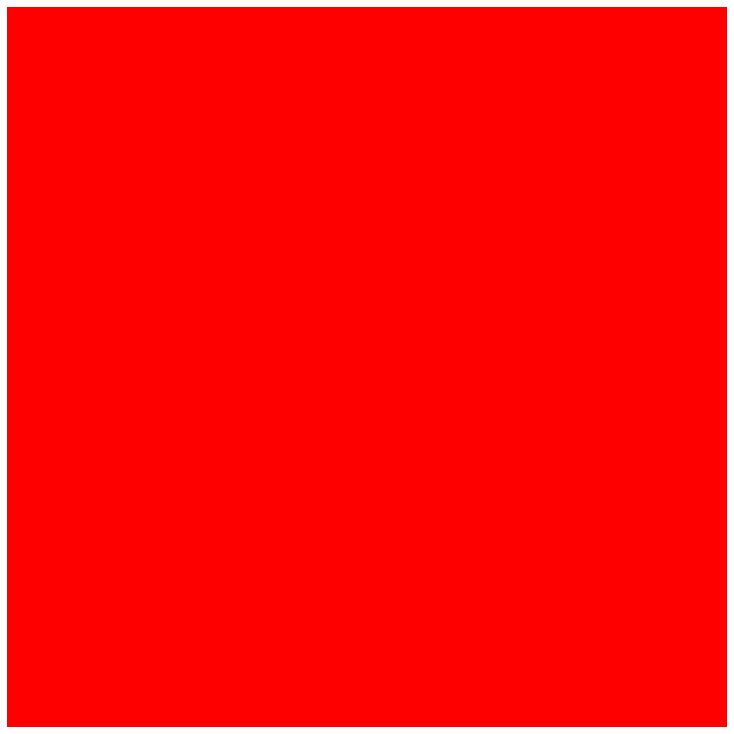

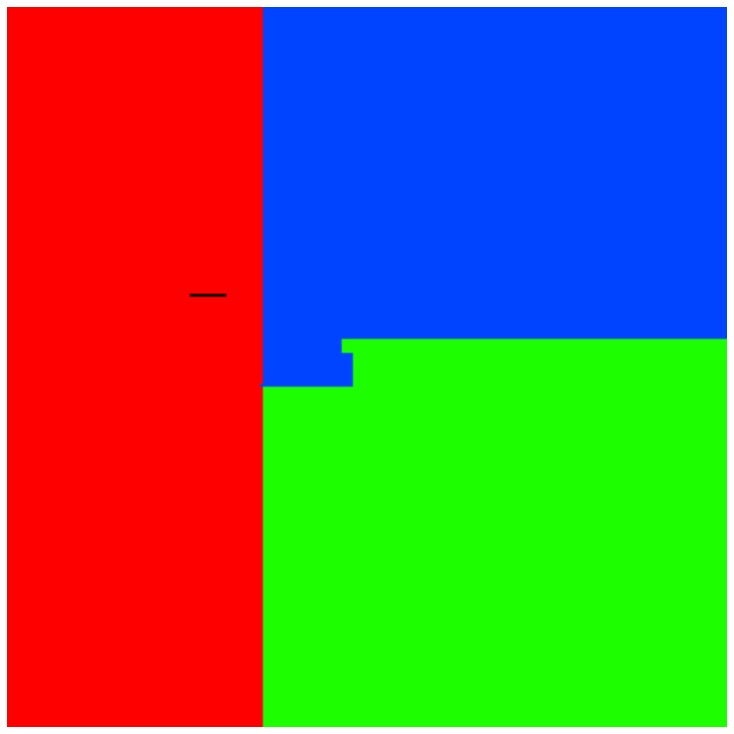

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


28
325125
point chosen is: 103,77
0
coordinates are 4 4


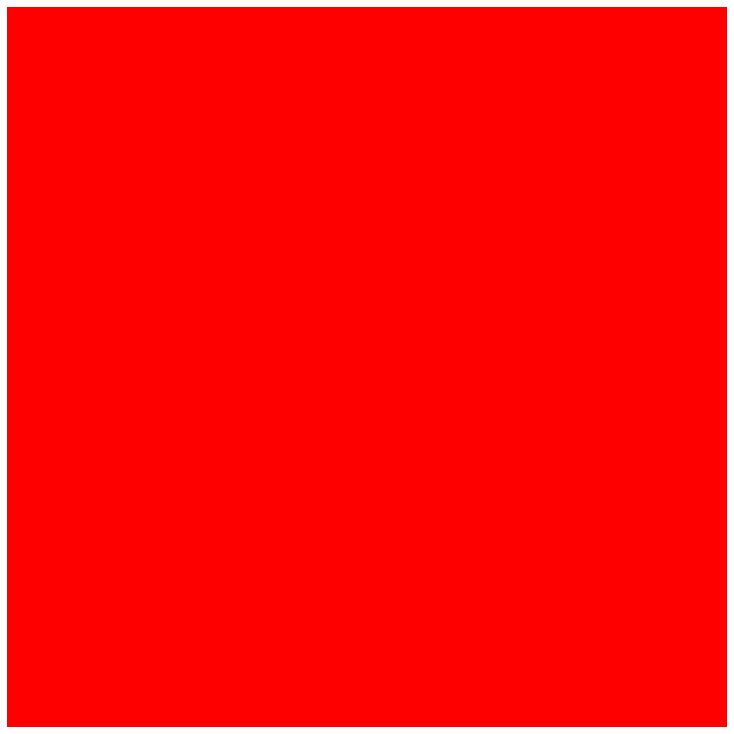

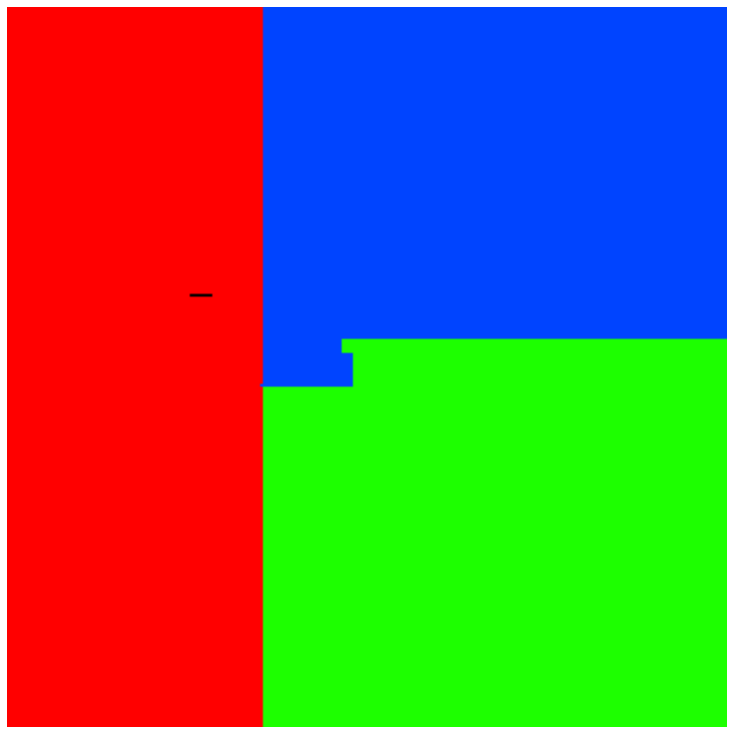

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


18
325125
point chosen is: 103,72
0
coordinates are 4 4


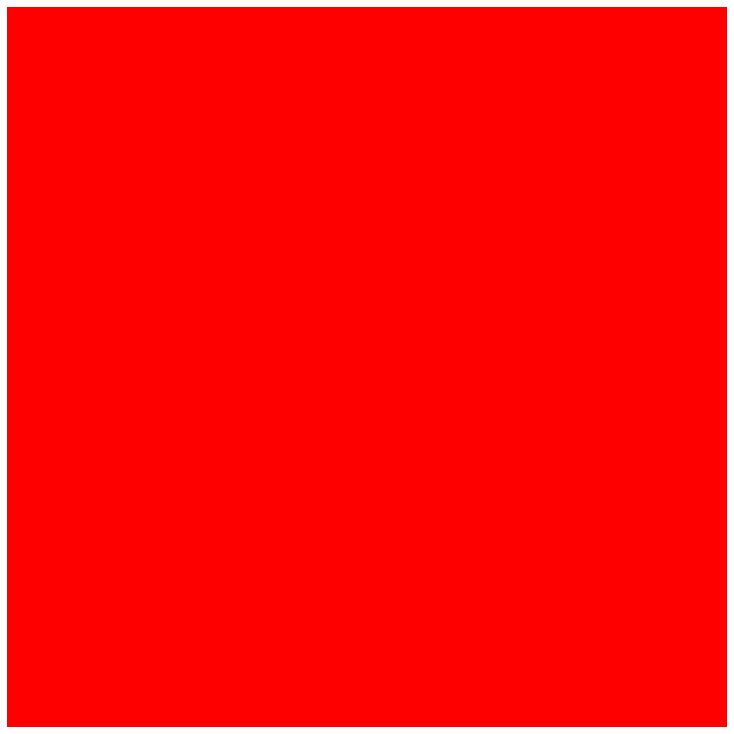

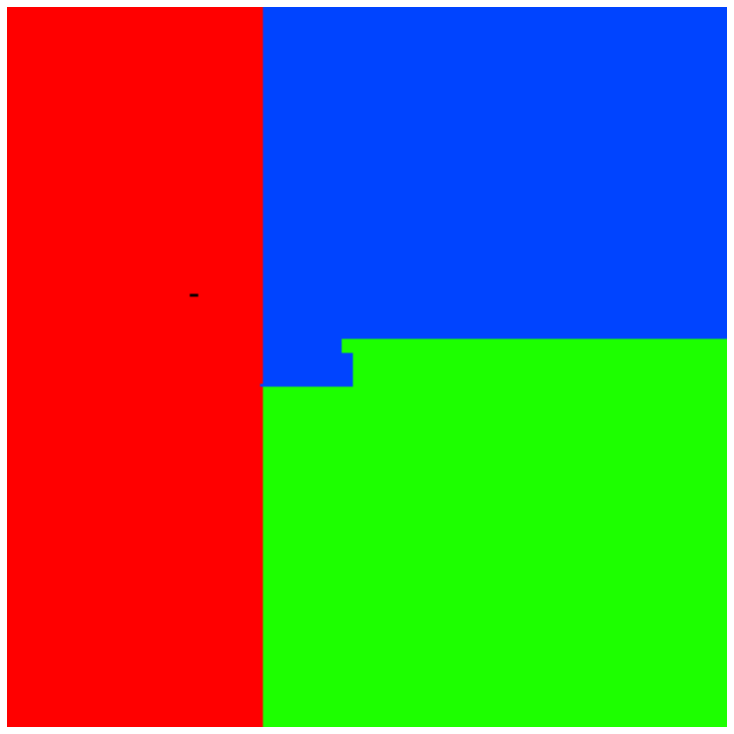

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


8
195075
point chosen is: 103,67
0
coordinates are 4 4


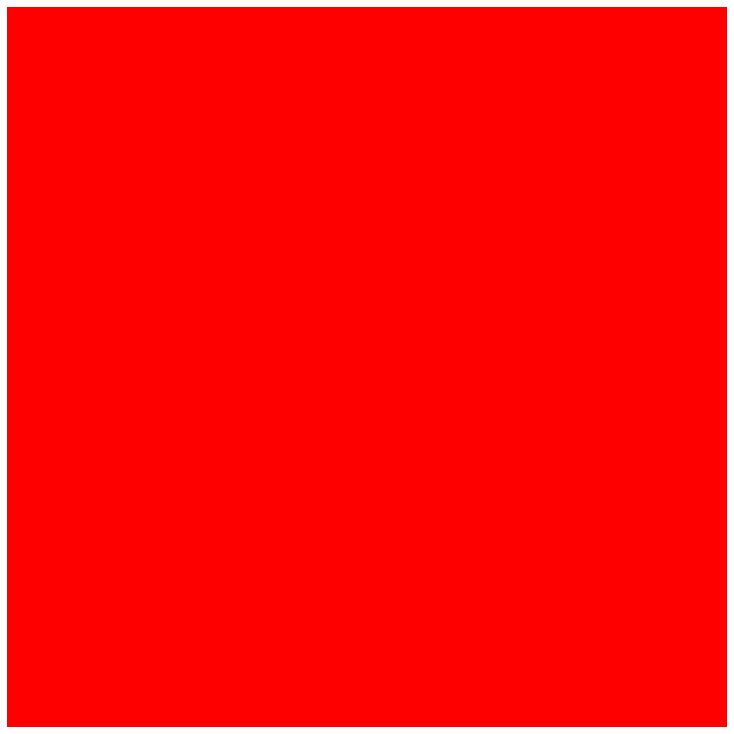

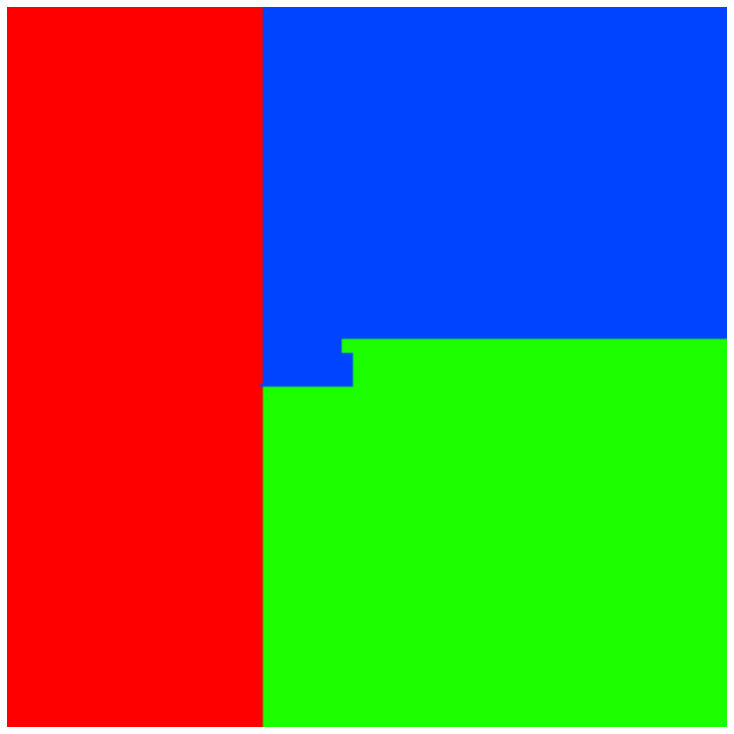

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


0


In [95]:
im=iio.imread('RGB.png')

iterate(im , mask_1)

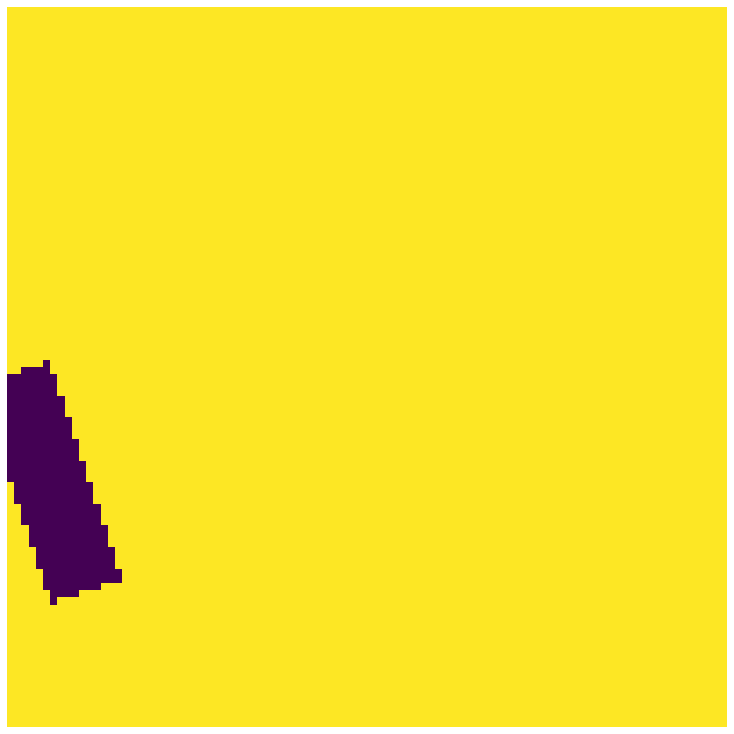

In [110]:
from PIL import ImageTk, Image, ImageDraw

mask = Image.new("L",(100 , 100),255)
array_mask = np.array(mask)
draw = ImageDraw.Draw(mask)

draw.line((0, 50, 10, 80), fill=0, width=10)


view(mask)